In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import ternary #DOI:10.5281/zenodo.2628066
import seaborn as sns # original distribution plots for figures 1 and 2 were made using seaborn 0.10.1; current version of seaborn (0.11.1) results in slightly different distributions.
from cycler import cycler #for mpl>2.2
from pandas.plotting import table
import scipy.stats as stats

In [2]:
# importing IAM data into data frame
df = pd.read_excel('iamc15_scenario_data_all_regions_r2.0.xlsx', sheet_name = 'data')

# importing metadata into data frame 2
df2 = pd.read_excel('sr15_metadata_indicators_r2.0.xlsx', sheet_name = 'meta')

In [3]:
# adding a column to the data that specifies each scenario's SSP. Takes several minutes.
def ssp(row):
    if 'SSP1' in row['Scenario']:
        return 'SSP1'
    if 'SSP2' in row['Scenario']:
        return 'SSP2'
    if 'SSP3' in row['Scenario']:
        return 'SSP3'
    if 'SSP4' in row['Scenario']:
        return 'SSP4'
    if 'SSP5' in row['Scenario']:
        return 'SSP5'
    return 'SSP0'
df['SSP'] = df.apply(lambda row: ssp(row), axis = 1)

In [4]:
# adding a column to the data that specifies each scenario's temp increase category. Takes several minutes.
def temp(row):
    model = row['Model']
    scenario = row['Scenario']
    meta = df2.loc[(df2['model'] == model) & (df2['scenario'] == scenario)]
    foo = meta['category'].values
    # print(type(foo))
    # print(foo)
    if '1.5C' in foo[0]:
        return '1.5C'
    if 'Lower 2C' in foo[0]:
        return '2C'
    if 'Higher 2C' in foo[0]:
        return '2C'
    if 'Above 2C' in foo[0]:
        return '>2C'
    
df['Temp'] = df.apply(lambda row: temp(row), axis = 1)

In [5]:
# now moving the SSP and temp columns to the beginning of the dataframe with the other categorical columns

# ONLY RUN THIS CELL ONCE after data is loaded; otherwise it will keep moving the last two columns to the front and will mess up the order.

i = 0
newcols = 2
cols = df.columns.tolist()
while i < newcols:
    cols = cols[-1:] + cols[:-1]
    i = i+1
df = df[cols] 
print(df)

         SSP  Temp              Model                Scenario  Region  \
0       SSP0  1.5C        AIM/CGE 2.0  ADVANCE_2020_1.5C-2100  R5ASIA   
1       SSP0  1.5C        AIM/CGE 2.0  ADVANCE_2020_1.5C-2100  R5ASIA   
2       SSP0  1.5C        AIM/CGE 2.0  ADVANCE_2020_1.5C-2100  R5ASIA   
3       SSP0  1.5C        AIM/CGE 2.0  ADVANCE_2020_1.5C-2100  R5ASIA   
4       SSP0  1.5C        AIM/CGE 2.0  ADVANCE_2020_1.5C-2100  R5ASIA   
...      ...   ...                ...                     ...     ...   
393361  SSP0   >2C  WITCH-GLOBIOM 4.4       CD-LINKS_NoPolicy   World   
393362  SSP0   >2C  WITCH-GLOBIOM 4.4       CD-LINKS_NoPolicy   World   
393363  SSP0   >2C  WITCH-GLOBIOM 4.4       CD-LINKS_NoPolicy   World   
393364  SSP0   >2C  WITCH-GLOBIOM 4.4       CD-LINKS_NoPolicy   World   
393365  SSP0   >2C  WITCH-GLOBIOM 4.4       CD-LINKS_NoPolicy   World   

                                        Variable   Unit  2000  2001  2002  \
0                   Capacity|Electricity|Bioma

In [6]:
# getting a list of all unique scenarios (SSP and others) that reach net-zero CO2 emissions by 2100
import scipy as sp
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline

# Set ei = 1 if looking at when just energy and industry reaches net-zero CO2 (not incl. land use)
# If ei = 0, net-zero is defined as net-zero from all sources an sinks (including land use)
ei = 0

nz_combo_all = pd.DataFrame()
nz_combo_all3 = pd.DataFrame()
nz_combo_ei = pd.DataFrame()
nz_combo_ei3 = pd.DataFrame()
nz_reg = pd.DataFrame()
nz_reg3 = pd.DataFrame()
nz_models_plt = pd.DataFrame()
nz_scenarios_plt = pd.DataFrame()
filteredco2all1 = pd.DataFrame()
interp_data_all = pd.DataFrame()

co2_emiss = df.groupby('Variable').get_group('Emissions|CO2').groupby('Region').get_group('World')
netzero_co2 = co2_emiss[co2_emiss['2100']<=0]
# print(len(netzero_co2))
# print(netzero_co2)

nz_models_all = netzero_co2['Model']
models2 = np.unique(netzero_co2['Model'])
# print(models2)
nz_scenarios_all = netzero_co2['Scenario']
scenarios2 = np.unique(nz_scenarios_all)
# print(list(scenarios2))


# list of all model-scenarios that reach net-zero CO2 emissions
nz_combo_all1 = nz_models_all.to_frame('Model').join(nz_scenarios_all.to_frame('Scenario'), how='outer')
traj = 10 * len(nz_combo_all1)
pd.set_option('display.max_rows', traj)
# print(nz_combo_all1)



co2_emiss_ei = df.groupby('Variable').get_group('Emissions|CO2|Energy and Industrial Processes').groupby('Region').get_group('World')
# print(co2_emiss)
netzero_co2_ei = co2_emiss_ei[co2_emiss_ei['2100']<=0]

nz_models_ei = netzero_co2_ei['Model']
models2_ei = np.unique(netzero_co2_ei['Model'])
# print(models2)
nz_scenarios_ei = netzero_co2_ei['Scenario']
scenarios2_ei = np.unique(nz_scenarios_ei)
# print(list(scenarios2))

# list of all model-scenarios that reach net-zero CO2 in ENERGY+INDUSTRY only
nz_combo_ei1 = nz_models_ei.to_frame('Model').join(nz_scenarios_ei.to_frame('Scenario'), how='outer')
traj = 10 * len(nz_combo_ei1)
pd.set_option('display.max_rows', traj)
# print(nz_combo_all1)
# print(len(nz_combo_all1))




# Getting a dataframe of data starting in 2010 only for scenarios with all required outputs that reach net-zero CO2
filteredco2all = df.merge(nz_combo_all1, on = ['Model','Scenario'], how = 'inner')

if ei == 1:
    filteredco2ei = df.merge(nz_combo_ei1, on = ['Model','Scenario'], how = 'inner')
    filteredco2all = filteredco2ei
# print(filteredco2all.index)
filteredco2all = filteredco2all.drop(['2000','2001','2002','2003','2004','2005','2006','2007',
                                             '2008','2009'], axis = 1)


# Interpolating for all variables of interest

groups = ['Emissions|CO2','Emissions|CO2|AFOLU','Emissions|CO2|Energy and Industrial Processes', 
          'Emissions|CO2|Energy|Demand|Industry','Emissions|CO2|Energy|Demand|Residential and Commercial', 
          'Emissions|CO2|Energy|Demand|Transportation','Emissions|CO2|Industrial Processes', 
          'Emissions|CO2|Energy|Supply','Emissions|CO2|Energy|Supply|Electricity','Emissions|CO2|Energy|Demand',
          'Emissions|CO2|Energy|Demand|Industry','Population','GDP|PPP','Primary Energy','Primary Energy|Fossil',
          'Primary Energy|Gas','Primary Energy|Oil','Primary Energy|Coal','Primary Energy|Nuclear',
          'Primary Energy|Biomass','Carbon Sequestration|CCS|Biomass','Carbon Sequestration|Land Use',
          'Final Energy','Final Energy|Electricity','Final Energy|Liquids','Final Energy|Solids',
          'Final Energy|Gases','Final Energy|Heat','Secondary Energy|Electricity|Solar',
          'Secondary Energy|Electricity|Wind','Price|Carbon','Investment|Energy Supply|Electricity|Non-fossil',
          'Investment|Energy Efficiency','Capacity|Electricity|Solar','Capacity|Electricity|Wind',
          'Capacity|Electricity|Hydro','Capacity|Electricity|Biomass']

for group in groups:
    interp_var = filteredco2all.groupby('Variable').get_group(group).loc[:, '2010':'2100']
    interp_var.columns = interp_var.columns.astype(int)
    interp_var = interp_var.interpolate(method='polynomial', limit_direction='both', axis=1, order=2)
    interp_var.columns = interp_var.columns.astype(str)
    filteredco2all.update(interp_var)


# Getting list of unique scenarios, global:
scenarios = np.unique(filteredco2all['Scenario'])
scenarios1 = len(scenarios)
# print(scenarios)

# Getting data by warming category:

filtered1p5 = filteredco2all[filteredco2all['Temp']=='1.5C']
scenarios1p5 = np.unique(filtered1p5['Scenario'])

filtered2 = filteredco2all[filteredco2all['Temp']=='2C']
scenarios2 = np.unique(filtered2['Scenario'])

filteredplus2 = filteredco2all[filteredco2all['Temp']=='>2C']
scenariosplus2 = np.unique(filteredplus2['Scenario'])

# nz_combo_ei_test1 = nz_combo_ei.merge(nz_combo_all, on = ['Model','Scenario'], how = 'inner')
# print(len(nz_combo_ei_test1))
# nz_combo_ei_test2 = nz_combo_all.merge(nz_combo_ei, on = ['Model','Scenario'], how = 'inner')
# print(len(nz_combo_ei_test1))

In [7]:
# for making scatter plots of primary energy sources/mixes, energy demand, trajectories, and residual ems
# from cycler import cycler # for mpl>2.2

import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
pd.options.mode.chained_assignment = None

scat_var = np.array(['Population', 'GDP|PPP', 'Primary Energy', 'Primary Energy|Fossil', 'Primary Energy|Nuclear', 'Primary Energy|Biomass', 'Primary Energy|Solar', 'Primary Energy|Wind', 'Final Energy'])


# Defining dataframes that will be used to store different categories of data prior to merging into full plotting dataframe.

all_nz_index = pd.DataFrame()
all_nz_indexnew = pd.DataFrame()
all_nz_indexdetail = pd.DataFrame()
nz_index = pd.DataFrame()
nz_indexnew = pd.DataFrame()
nz_indexnew2 = pd.DataFrame()
nz_index_ref = pd.DataFrame()
nz_index_refnew = pd.DataFrame()
nz_index_refnew2 = pd.DataFrame()
all_max_index = pd.DataFrame()
all_max_finen = pd.DataFrame()
all_max_gdp = pd.DataFrame()
temp_cat_all = pd.DataFrame()
temp_cat_allnew = pd.DataFrame()
temp_cat_allnew2 = pd.DataFrame()
temp_cat_alldetail = pd.DataFrame()
ssp_cat_all = pd.DataFrame()
ssp_cat_allnew = pd.DataFrame()
ssp_cat_alldetail = pd.DataFrame()
reg_cat_all = pd.DataFrame()
reg_cat_allnew = pd.DataFrame()
reg_cat_alldetail = pd.DataFrame()
model_ver_all = pd.DataFrame()
model_ver_alldetail = pd.DataFrame()
pop2 = pd.DataFrame()
pop4 = pd.DataFrame()
pop22 = pd.DataFrame()
pop24 = pd.DataFrame()
res21 = pd.DataFrame()
res41 = pd.DataFrame()
res22 = pd.DataFrame()
res42 = pd.DataFrame()
res21new = pd.DataFrame()
res41new = pd.DataFrame()
res22new = pd.DataFrame()
res42new = pd.DataFrame()
gdp2 = pd.DataFrame()
gdp4 = pd.DataFrame()
penergy4 = pd.DataFrame()
fossil4 = pd.DataFrame()
nuc4 = pd.DataFrame()
bio4 = pd.DataFrame()
ccs_bio2 = pd.DataFrame()
ccs_bio4 = pd.DataFrame()
finen2 = pd.DataFrame()
finen4 = pd.DataFrame()
finen_gdp2 = pd.DataFrame()
finen_gdp4 = pd.DataFrame()
finelec2 = pd.DataFrame()
finelec4 = pd.DataFrame()
liquid2 = pd.DataFrame()
liquid4 = pd.DataFrame()
solid2 = pd.DataFrame()
solid4 = pd.DataFrame()
gas2 = pd.DataFrame()
gas4 = pd.DataFrame()
secsol2 = pd.DataFrame()
secsol4 = pd.DataFrame()
secwind2 = pd.DataFrame()
secwind4 = pd.DataFrame()
cprice2 = pd.DataFrame()
cprice4 = pd.DataFrame()
invest2 = pd.DataFrame()
invest4 = pd.DataFrame()
landuse2 = pd.DataFrame()
landuse4 = pd.DataFrame()
beccs2 = pd.DataFrame()
beccs4 = pd.DataFrame()
ccs_cumulative2 = pd.DataFrame()
ccs_cumulative4 = pd.DataFrame()
energyindustry2 = pd.DataFrame()
energyindustry4 = pd.DataFrame()
transport2 = pd.DataFrame()
transport4 = pd.DataFrame()
industry2 = pd.DataFrame()
industry4 = pd.DataFrame()
rescom2 = pd.DataFrame()
rescom4 = pd.DataFrame()
supply2 = pd.DataFrame()
supply4 = pd.DataFrame()
demand2 = pd.DataFrame()
demand4 = pd.DataFrame()
resip2 = pd.DataFrame()
resip4 = pd.DataFrame()
more_vars51 = pd.DataFrame()
color_dict = { '1.5C':'blue', '2C':'orange', '>2C':'red' }
warmcat = ['1.5C', '2C', '>2C']
timing = ['Early', 'Late']


# Getting data for scenarios with required output variables

full_co2_data = filteredco2all.groupby('Variable').get_group('Emissions|CO2').groupby('Region').get_group('World')
full_co2_data = full_co2_data.sort_values(by=['Scenario','Model'], ascending=True)
full_elec_ems = filteredco2all.groupby('Variable').get_group('Emissions|CO2|Energy|Supply|Electricity').groupby('Region').get_group('World')
full_elec_ems = full_elec_ems.sort_values(by=['Scenario','Model'], ascending=True)
full_residual_data1 = filteredco2all.groupby('Variable').get_group('Emissions|CO2|AFOLU').groupby('Region').get_group('World')
full_residual_data1 = full_residual_data1.sort_values(by=['Scenario','Model'], ascending=True)
full_residual_data2 = filteredco2all.groupby('Variable').get_group('Emissions|CO2|Energy and Industrial Processes').groupby('Region').get_group('World')
full_residual_data2 = full_residual_data2.sort_values(by=['Scenario','Model'], ascending=True)
full_pop_data = filteredco2all.groupby('Variable').get_group('Population').groupby('Region').get_group('World')
full_pop_data = full_pop_data.sort_values(by=['Scenario','Model'], ascending=True)
full_gdp_data = filteredco2all.groupby('Variable').get_group('GDP|PPP').groupby('Region').get_group('World')
full_gdp_data = full_gdp_data.sort_values(by=['Scenario','Model'], ascending=True)
full_penergy_data  = filteredco2all.groupby('Variable').get_group('Primary Energy').groupby('Region').get_group('World')
full_penergy_data = full_penergy_data.sort_values(by=['Scenario','Model'], ascending=True)
full_fossil_data = filteredco2all.groupby('Variable').get_group('Primary Energy|Fossil').groupby('Region').get_group('World')
full_fossil_data = full_fossil_data.sort_values(by=['Scenario','Model'], ascending=True)
full_nuc_data = filteredco2all.groupby('Variable').get_group('Primary Energy|Nuclear').groupby('Region').get_group('World')
full_nuc_data = full_nuc_data.sort_values(by=['Scenario','Model'], ascending=True)
full_bio_data = filteredco2all.groupby('Variable').get_group('Primary Energy|Biomass').groupby('Region').get_group('World')
full_bio_data = full_bio_data.sort_values(by=['Scenario','Model'], ascending=True)
full_ccs_bio_data = filteredco2all.groupby('Variable').get_group('Carbon Sequestration|CCS|Biomass').groupby('Region').get_group('World')
full_ccs_bio_data = full_ccs_bio_data.sort_values(by=['Scenario','Model'], ascending=True)
full_finen = filteredco2all.groupby('Variable').get_group('Final Energy').groupby('Region').get_group('World')
full_finen = full_finen.sort_values(by=['Scenario','Model'], ascending=True)
full_finelec = filteredco2all.groupby('Variable').get_group('Final Energy|Electricity').groupby('Region').get_group('World')
full_finelec = full_finelec.sort_values(by=['Scenario','Model'], ascending=True)
full_liquid = filteredco2all.groupby('Variable').get_group('Final Energy|Liquids').groupby('Region').get_group('World')
full_liquid = full_liquid.sort_values(by=['Scenario','Model'], ascending=True)
full_solid = filteredco2all.groupby('Variable').get_group('Final Energy|Solids').groupby('Region').get_group('World')
full_solid = full_solid.sort_values(by=['Scenario','Model'], ascending=True)
full_gas = filteredco2all.groupby('Variable').get_group('Final Energy|Gases').groupby('Region').get_group('World')
full_gas = full_gas.sort_values(by=['Scenario','Model'], ascending=True)
full_sec_sol = filteredco2all.groupby('Variable').get_group('Secondary Energy|Electricity|Solar').groupby('Region').get_group('World')
full_sec_sol = full_sec_sol.sort_values(by=['Scenario','Model'], ascending=True)
full_sec_wind = filteredco2all.groupby('Variable').get_group('Secondary Energy|Electricity|Wind').groupby('Region').get_group('World')
full_sec_wind = full_sec_wind.sort_values(by=['Scenario','Model'], ascending=True)
full_cprice = filteredco2all.groupby('Variable').get_group('Price|Carbon').groupby('Region').get_group('World')
full_cprice = full_cprice.sort_values(by=['Scenario','Model'], ascending=True)
full_scenario_data = filteredco2all.groupby('Region').get_group('World')
full_scenario_data = full_scenario_data.sort_values(by=['Scenario','Model'], ascending=True)

# print('working...')
# picking list of model/scenario combos to merge with individual dataframes:

# this is necessary because variables are selected by scenario, but not all model/scenario combos have all output variables
# example: getting 'Primary Energy|Biomass' from scenario 'ADVANCE_2020_1.5C-2100' will return all models that ran 'ADVANCE_2020_1.5C-2100' and have that output variable.
# example continued: if five models ran 'ADVANCE_2020_1.5C-2100' but only three have a 'Primary Energy|Biomass' output...
# example continued: ...but for 'Final Energy', all five models for 'ADVANCE_2020_1.5C-2100' have a 'Final Energy' output...
# example continued: ...then the list of model/scenarios for each variable is not the same and must be merged on the shortest list...
# example continued: ...so that only the three model/scenarios that these two varaibles have in common are assessed.

# even after the first merge, the list of model/scenarios still might not match across all variables. 
# Why? Going back to our example, considering models A-E, let's say that for 'ADVANCE_2020_1.5C-2100', models A, B, and C have 'Primary Energy|Biomass' data...
# example continued: ...but models B, C, D, and E have data for 'GDP|PPP'. After the first merge...
# example continued: ...the variables are merged on the shortest list of models (in this case, models A,B, and C)...
# example continued: ...and the variable with the shorter length only keeps the rows that have models in common. So, since 'GDP\PPP' has models B and C...
# example continued: ...but not model A, then our 'GDP\PPP' list will only have B and C, while 'Primary Energy|Biomass' has A-C.
# example continued: ...so by doing one more round of selecting the shortest list of model/scenarios and merging all variables with that list...
# example continued: ...we guarantee that the model/scenarios will match across all variables.
# example continued: For our example, we would then select the model/scenario list from 'GDP|PPP' since it is the shortest...
# example continued: ...and merge that list with 'Primary Energy|Biomass' so that the final 'Primary Energy|Biomass' list only has common model/scenarios with 'GDP|PPP' ('ADVANCE_2020_1.5C-2100, model B' and 'ADVANCE_2020_1.5C-2100, model C')

# So, we need to keep merging on the shortest model/scenario list for each iteration until all model/scenarios match (until length of new shortest list is the same as the length of the previous shortest list):
j=0
while j==0 or j > len(model_scenario_listvar):
    varlist = [full_co2_data, full_residual_data1, full_residual_data2, full_pop_data, full_gdp_data, full_penergy_data, \
           full_fossil_data, full_nuc_data, full_bio_data, full_ccs_bio_data, full_finen, full_finelec, full_liquid, \
           full_solid, full_gas, full_sec_sol, full_sec_wind, full_cprice]
    # print(varlist[0])
    if j==0:
        hold = ['1'] * len(varlist)
        model_scenario_listvar = varlist[0]
    for i in range(len(varlist)):
        # print(i)
        if i==0 or len(varlist[i]) < len(model_scenario_listvar):
            hold[i] = model_scenario_listvar
            j=len(hold[i])
            model_scenario_listvar = varlist[i]
            # print(varlist_tracker[i+1])
    # print(j)
    # print(len(model_scenario_listvar))
    
    nz_models_world1 = model_scenario_listvar['Model']
    nz_models_world = nz_models_world1.reset_index(drop=True)
    # print(nz_models_all)
    nz_scenarios_world1 = model_scenario_listvar['Scenario']
    nz_scenarios_world = nz_scenarios_world1.reset_index(drop=True)
    # print(full_scenario_data)

    nz_combo_world = nz_models_world.to_frame('Model').join(nz_scenarios_world.to_frame('Scenario'), how='outer')
    nz_combo_world = nz_combo_world.sort_values(by=['Scenario','Model'], ascending=True)
    
    full_residual_data1 = full_residual_data1.merge(nz_combo_world, on = ['Scenario','Model'], how = 'inner')
    full_residual_data1= full_residual_data1.sort_values(by=['Scenario','Model'], ascending=True)
    full_residual_data2 = full_residual_data2.merge(nz_combo_world, on = ['Scenario','Model'], how = 'inner')
    full_residual_data2 = full_residual_data2.sort_values(by=['Scenario','Model'], ascending=True)
    full_pop_data = full_pop_data.merge(nz_combo_world, on = ['Scenario','Model'], how = 'inner')
    full_pop_data = full_pop_data.sort_values(by=['Scenario','Model'], ascending=True)
    full_gdp_data = full_gdp_data.merge(nz_combo_world, on = ['Scenario','Model'], how = 'inner')
    full_gdp_data = full_gdp_data.sort_values(by=['Scenario','Model'], ascending=True)
    full_co2_data = full_co2_data.merge(nz_combo_world, on = ['Scenario','Model'], how = 'inner')
    full_co2_data = full_co2_data.sort_values(by=['Scenario','Model'], ascending=True)
    full_penergy_data = full_penergy_data.merge(nz_combo_world, on = ['Scenario','Model'], how = 'inner')
    full_penergy_data = full_penergy_data.sort_values(by=['Scenario','Model'], ascending=True)
    full_fossil_data = full_fossil_data.merge(nz_combo_world, on = ['Scenario','Model'], how = 'inner')
    full_fossil_data = full_fossil_data.sort_values(by=['Scenario','Model'], ascending=True)
    full_nuc_data = full_nuc_data.merge(nz_combo_world, on = ['Scenario','Model'], how = 'inner')
    full_nuc_data = full_nuc_data.sort_values(by=['Scenario','Model'], ascending=True)
    full_bio_data = full_bio_data.merge(nz_combo_world, on = ['Scenario','Model'], how = 'inner')
    full_bio_data = full_bio_data.sort_values(by=['Scenario','Model'], ascending=True)
    full_ccs_bio_data = full_ccs_bio_data.merge(nz_combo_world, on = ['Scenario','Model'], how = 'inner')
    full_ccs_bio_data = full_ccs_bio_data.sort_values(by=['Scenario','Model'], ascending=True)
    full_finen = full_finen.merge(nz_combo_world, on = ['Scenario','Model'], how = 'inner')
    full_finen = full_finen.sort_values(by=['Scenario','Model'], ascending=True)
    full_finelec = full_finelec.merge(nz_combo_world, on = ['Scenario','Model'], how = 'inner')
    full_finelec = full_finelec.sort_values(by=['Scenario','Model'], ascending=True)
    full_liquid = full_liquid.merge(nz_combo_world, on = ['Scenario','Model'], how = 'inner')
    full_liquid = full_liquid.sort_values(by=['Scenario','Model'], ascending=True)
    full_solid = full_solid.merge(nz_combo_world, on = ['Scenario','Model'], how = 'inner')
    full_solid = full_solid.sort_values(by=['Scenario','Model'], ascending=True)
    full_gas = full_gas.merge(nz_combo_world, on = ['Scenario','Model'], how = 'inner')
    full_gas = full_gas.sort_values(by=['Scenario','Model'], ascending=True)
    full_sec_sol = full_sec_sol.merge(nz_combo_world, on = ['Scenario','Model'], how = 'inner')
    full_sec_sol = full_sec_sol.sort_values(by=['Scenario','Model'], ascending=True)
    full_sec_wind = full_sec_wind.merge(nz_combo_world, on = ['Scenario','Model'], how = 'inner')
    full_sec_wind = full_sec_wind.sort_values(by=['Scenario','Model'], ascending=True)
    full_cprice = full_cprice.merge(nz_combo_world, on = ['Scenario','Model'], how = 'inner')
    full_cprice = full_cprice.sort_values(by=['Scenario','Model'], ascending=True)

# getting list of net-zero years, max emissions years, and other data for all scenarios
nz_index = full_co2_data.loc[:, '2010':'2100'].le(0).idxmax(axis=1).astype(str) #.abs().idxmin(axis=1)
# print(nz_index)
full_co2_data['nz_index_test'] = nz_index
# print(full_co2_data)
nz_index_ref = pd.concat([all_nz_index, nz_index]).astype(str)
all_nz_index = pd.concat([all_nz_index, nz_index]).astype(int)
# nz_index = full_residual_data2.loc[:, '2010':'2100'].le(0).idxmax(axis=1).astype(str) #.abs().idxmin(axis=1)
# nz_index_ref = pd.concat([all_nz_index, nz_index]).astype(str)
# all_nz_index = pd.concat([all_nz_index, nz_index]).astype(int)
max_index = full_co2_data.loc[:, '2010':'2100'].idxmax(axis=1)
all_max_index = pd.concat([all_max_index, max_index]).astype(int)
# max_index = full_residual_data2.loc[:, '2010':'2100'].idxmax(axis=1)
# all_max_index = pd.concat([all_max_index, max_index]).astype(int)
max_finen = full_finen.loc[:, '2010':'2100'].max(axis=1)
all_max_finen = pd.concat([all_max_finen, max_finen]).astype(float)
max_gdp = full_gdp_data.loc[:, '2010':'2100'].max(axis=1)
all_max_gdp = pd.concat([all_max_gdp, max_gdp]).astype(float)
temp_cat = full_co2_data['Temp']
temp_cat_all = pd.concat([temp_cat_all, temp_cat])
# temp_cat = full_residual_data2['Temp']
# temp_cat_all = pd.concat([temp_cat_all, temp_cat])
ssp_cat = full_co2_data['SSP']
ssp_cat_all = pd.concat([ssp_cat_all, ssp_cat])
# ssp_cat = full_residual_data2['SSP']
# ssp_cat_all = pd.concat([ssp_cat_all, ssp_cat])
reg_cat = full_co2_data['Region']
reg_cat_all = pd.concat([reg_cat_all, reg_cat])
# reg_cat = full_residual_data2['Region']
# reg_cat_all = pd.concat([reg_cat_all, reg_cat])

# for getting sectoral residual emissions and industrial decarbonization rates for 40 scenarios with more detailed residual emissions outputs by sector:

full_co2_detail = filteredco2all.groupby('Variable').get_group('Emissions|CO2').groupby('Region').get_group('World')
full_co2_detail = full_co2_detail.sort_values(by=['Scenario','Model'], ascending=True)
full_pop_detail = filteredco2all.groupby('Variable').get_group('Population').groupby('Region').get_group('World')
full_pop_detail = full_pop_detail.sort_values(by=['Scenario','Model'], ascending=True)
full_res_ei = filteredco2all.groupby('Variable').get_group('Emissions|CO2|Energy and Industrial Processes').groupby('Region').get_group('World')
full_res_ei = full_res_ei.sort_values(by=['Scenario','Model'], ascending=True)
full_res_transport = filteredco2all.groupby('Variable').get_group('Emissions|CO2|Energy|Demand|Transportation').groupby('Region').get_group('World')
full_res_transport = full_res_transport.sort_values(by=['Scenario','Model'], ascending=True)
full_res_industry = filteredco2all.groupby('Variable').get_group('Emissions|CO2|Energy|Demand|Industry').groupby('Region').get_group('World')
full_res_industry = full_res_industry.sort_values(by=['Scenario','Model'], ascending=True)
full_res_rescom = filteredco2all.groupby('Variable').get_group('Emissions|CO2|Energy|Demand|Residential and Commercial').groupby('Region').get_group('World')
full_res_rescom = full_res_rescom.sort_values(by=['Scenario','Model'], ascending=True)
full_res_ip = filteredco2all.groupby('Variable').get_group('Emissions|CO2|Industrial Processes').groupby('Region').get_group('World')
full_res_ip = full_res_ip.sort_values(by=['Scenario','Model'], ascending=True)
full_res_supply = filteredco2all.groupby('Variable').get_group('Emissions|CO2|Energy|Supply').groupby('Region').get_group('World')
full_res_supply = full_res_supply.sort_values(by=['Scenario','Model'], ascending=True)
full_res_demand = filteredco2all.groupby('Variable').get_group('Emissions|CO2|Energy|Demand').groupby('Region').get_group('World')
full_res_demand = full_res_demand.sort_values(by=['Scenario','Model'], ascending=True)

j=0
while j==0 or j > len(model_scenario_listvar_detail):
    varlist_detail = [full_co2_detail, full_pop_detail, full_res_ei, full_res_transport, full_res_industry, full_res_rescom, \
                      full_res_ip, full_res_supply, full_res_demand]
    if j==0:
        hold_detail = ['1'] * len(varlist_detail)
        model_scenario_listvar_detail = varlist_detail[0]
    for i in range(len(varlist_detail)):
        # print(i)
        if i == 0 or len(varlist_detail[i]) < len(model_scenario_listvar_detail):
            hold_detail[i] = model_scenario_listvar_detail
            j=len(hold_detail[i])
            model_scenario_listvar_detail = varlist_detail[i]

    nz_models_world1detail = model_scenario_listvar_detail['Model']
    nz_models_worlddetail = nz_models_world1detail.reset_index(drop=True)
    nz_scenarios_world1detail = model_scenario_listvar_detail['Scenario']
    nz_scenarios_worlddetail = nz_scenarios_world1detail.reset_index(drop=True)
    nz_combo_worlddetail = nz_models_worlddetail.to_frame('Model').join(nz_scenarios_worlddetail.to_frame('Scenario'), how='outer')
    nz_combo_worlddetail = nz_combo_worlddetail.sort_values(by=['Scenario','Model'], ascending=True)
    # print(nz_combo_worlddetail)

    full_co2_detail = full_co2_detail.merge(nz_combo_worlddetail, on = ['Scenario','Model'], how = 'inner')
    full_co2_detail = full_co2_detail.sort_values(by=['Scenario','Model'], ascending=True)
    full_pop_detail = full_pop_detail.merge(nz_combo_worlddetail, on = ['Scenario','Model'], how = 'inner')
    full_pop_detail = full_pop_detail.sort_values(by=['Scenario','Model'], ascending=True)
    full_res_ei = full_res_ei.merge(nz_combo_worlddetail, on = ['Scenario','Model'], how = 'inner')
    full_res_ei = full_res_ei.sort_values(by=['Scenario','Model'], ascending=True)
    full_res_transport = full_res_transport.merge(nz_combo_worlddetail, on = ['Scenario','Model'], how = 'inner')
    full_res_transport = full_res_transport.sort_values(by=['Scenario','Model'], ascending=True)
    full_res_industry = full_res_industry.merge(nz_combo_worlddetail, on = ['Scenario','Model'], how = 'inner')
    full_res_industry = full_res_industry.sort_values(by=['Scenario','Model'], ascending=True)
    full_res_rescom = full_res_rescom.merge(nz_combo_worlddetail, on = ['Scenario','Model'], how = 'inner')
    full_res_rescom = full_res_rescom.sort_values(by=['Scenario','Model'], ascending=True)
    full_res_ip = full_res_ip.merge(nz_combo_worlddetail, on = ['Scenario','Model'], how = 'inner')
    full_res_ip = full_res_ip.sort_values(by=['Scenario','Model'], ascending=True)
    full_res_supply = full_res_supply.merge(nz_combo_worlddetail, on = ['Scenario','Model'], how = 'inner')
    full_res_supply = full_res_supply.sort_values(by=['Scenario','Model'], ascending=True)
    full_res_demand = full_res_demand.merge(nz_combo_worlddetail, on = ['Scenario','Model'], how = 'inner')
    full_res_demand = full_res_demand.sort_values(by=['Scenario','Model'], ascending=True)
    
nz_indexdetail = full_co2_detail.loc[:, '2010':'2100'].le(0).idxmax(axis=1).astype(str) #.abs().idxmin(axis=1)
# nz_index_refdetail = nz_indexdetail
all_nz_indexdetail = pd.concat([all_nz_indexdetail, nz_indexdetail]).astype(str)
# print(all_nz_indexdetail)
temp_catdetail = full_co2_detail['Temp']
temp_cat_alldetail = pd.concat([temp_cat_alldetail, temp_catdetail])
ssp_catdetail = full_co2_detail['SSP']
ssp_cat_alldetail = pd.concat([ssp_cat_alldetail, ssp_catdetail])
reg_catdetail = full_co2_detail['Region']
reg_cat_alldetail = pd.concat([reg_cat_alldetail, reg_catdetail])

# print(list(nz_scenarios_worlddetail))
# print(full_res_rescom)
# print(full_res_demand)

# print(full_res_industry)
pd.set_option('display.max_columns', 10)
res_industry_rate = full_res_industry.loc[:, '2010':'2100'].div(full_res_industry['2010'], axis=0)
res_industry_rate2 = res_industry_rate.diff(axis='columns')
res_industry_rate2['average rate'] = res_industry_rate2.loc[:, '2011':'2100'].mean(axis='columns')
res_industry_rate2['average rate %'] = res_industry_rate2['average rate'] * 100
# print(full_res_industry)
# print(res_industry_rate)
# print(res_industry_rate2)
full_res_industry['Average Decarbonization Rate, %/year'] = res_industry_rate2['average rate %']
industry_energy_rate = full_res_industry[['Model','Scenario','Region','Variable','Unit','Average Decarbonization Rate, %/year']]
# print(industry_energy_rate)

# print(full_res_ip)
pd.set_option('display.max_columns', None)
res_ip_rate = full_res_ip.loc[:, '2010':'2100'].div(full_res_ip['2010'], axis=0)
res_ip_rate2 = res_ip_rate.diff(axis='columns')
res_ip_rate2['average rate'] = res_ip_rate2.loc[:, '2011':'2100'].mean(axis='columns')
res_ip_rate2['average rate %'] = res_ip_rate2['average rate'] * 100
# print(full_res_ip)
# print(res_ip_rate)
# print(res_ip_rate2)
full_res_ip['Average Decarbonization Rate, %/year'] = res_ip_rate2['average rate %']
industry_ip_rate = full_res_ip[['Model','Scenario','Region','Variable','Unit','Average Decarbonization Rate, %/year']]
# print(industry_ip_rate)


# Back to main global nz scenarios, not industrial decarbonization specific scenarios anymore
# Assigning each model-scenario combo a number 0-177 to match up with corresponding net-zero year in object nz_years

full_co2_data['traj number'] = np.arange(len(full_co2_data))
# print(full_co2_data)
full_residual_data1['traj number'] = np.arange(len(full_residual_data1))
full_residual_data2['traj number'] = np.arange(len(full_residual_data2))
full_pop_data['traj number'] = np.arange(len(full_pop_data))
full_gdp_data['traj number'] = np.arange(len(full_gdp_data))
full_penergy_data['traj number'] = np.arange(len(full_penergy_data))
full_fossil_data['traj number'] = np.arange(len(full_fossil_data))
full_nuc_data['traj number'] = np.arange(len(full_nuc_data))
full_bio_data['traj number'] = np.arange(len(full_bio_data))
full_ccs_bio_data['traj number'] = np.arange(len(full_ccs_bio_data))
full_finen['traj number'] = np.arange(len(full_finen))
full_finelec['traj number'] = np.arange(len(full_finelec))
full_liquid['traj number'] = np.arange(len(full_liquid))
full_solid['traj number'] = np.arange(len(full_solid))
full_gas['traj number'] = np.arange(len(full_gas))
full_sec_sol['traj number'] = np.arange(len(full_sec_sol))
full_sec_wind['traj number'] = np.arange(len(full_sec_wind))
full_cprice['traj number'] = np.arange(len(full_cprice))

full_co2_detail['traj number'] = np.arange(len(full_co2_detail))
full_pop_detail['traj number'] = np.arange(len(full_pop_detail))
full_res_ei['traj number'] = np.arange(len(full_res_ei))
full_res_transport['traj number'] = np.arange(len(full_res_transport))
full_res_industry['traj number'] = np.arange(len(full_res_industry))
full_res_rescom['traj number'] = np.arange(len(full_res_rescom))
full_res_ip['traj number'] = np.arange(len(full_res_ip))
full_res_supply['traj number'] = np.arange(len(full_res_supply))
full_res_demand['traj number'] = np.arange(len(full_res_demand))



# Reformatting to get final list of net-zero years
all_nz_index2 = pd.DataFrame(all_nz_index)
# all_nz_index3 = all_nz_index2.rename(columns={'0': 'Net-Zero Year'})
# print(all_nz_index2)
full_nz_index = all_nz_index2.reset_index(drop=True)
full_nz_index.columns = ['Net-Zero Year']
full_nz_index2 = full_nz_index.transpose()
nz_years_hold = full_nz_index2.to_numpy()
# nz_years = list(nz_years_hold)
# print(nz_years)

# Reformatting to get final list of net-zero years
nz_index_ref2 = pd.DataFrame(nz_index_ref)
# all_nz_index3 = all_nz_index2.rename(columns={'0': 'Net-Zero Year'})
# print(all_nz_index2)
full_nz_ref = nz_index_ref2.reset_index(drop=True)
full_nz_ref.columns = ['Net-Zero Year REF']
full_nz_ref2 = full_nz_ref.transpose()
nz_ref = full_nz_ref2.to_numpy()
# print(full_nz_ref)
nz_years_hold = list(nz_ref)
nz_years = np.array(nz_years_hold, dtype=object).ravel()
# nz_years = nz_years.ravel()
# print(nz_years)


# Reformatting to get final list of net-zero years for more detailed scenarios (pltscenarios_detail object)
all_nz_index2detail = pd.DataFrame(all_nz_indexdetail)
all_nz_index3 = all_nz_index2.rename(columns={'0': 'Net-Zero Year'})
# print(all_nz_index2)
full_nz_indexdetail = all_nz_index2detail.reset_index(drop=True)
full_nz_indexdetail.columns = ['Net-Zero Year']
full_nz_indexdetail2 = full_nz_indexdetail.transpose()
nz_detail = full_nz_indexdetail2.to_numpy()
# print(full_nz_indexdetail)
nz_detail_hold = list(nz_detail)
nz_yearsdetail = np.array(nz_detail_hold, dtype=object).ravel()
# print(list(nz_detail))



# Resetting indices and setting column names for descriptive categories

all_max_index2 = pd.DataFrame(all_max_index)
full_max_index = all_max_index2.reset_index(drop=True)
full_max_index.columns = ['Max Emissions Year']
# print(full_max_index)

all_max_finen2 = pd.DataFrame(all_max_finen)
full_max_finen = all_max_finen2.reset_index(drop=True)
full_max_finen.columns = ['Max Final Energy (EJ)']
# print(full_max_finen)

all_max_gdp2 = pd.DataFrame(all_max_gdp)
full_max_gdp = all_max_gdp2.reset_index(drop=True)
full_max_gdp.columns = ['Max GDP ($billion US$2010/year)']
# print(full_max_gdp)
    
temp_cat_all2 = pd.DataFrame(temp_cat_all)
full_temp_cat = temp_cat_all2.reset_index(drop=True)
full_temp_cat.columns = ['Warming']
# print(full_temp_cat)

temp_cat_all2detail = pd.DataFrame(temp_cat_alldetail)
full_temp_catdetail = temp_cat_all2detail.reset_index(drop=True)
full_temp_catdetail.columns = ['Warming']
# print(full_temp_catdetail)

ssp_cat_all2 = pd.DataFrame(ssp_cat_all)
full_ssp_cat = ssp_cat_all2.reset_index(drop=True)
full_ssp_cat.columns = ['SSP_Group']
# print(full_ssp_cat)

ssp_cat_all2detail = pd.DataFrame(ssp_cat_alldetail)
full_ssp_catdetail = ssp_cat_all2detail.reset_index(drop=True)
full_ssp_catdetail.columns = ['SSP_Group']
# print(full_ssp_catdetail)
                                                            
reg_cat_all2 = pd.DataFrame(reg_cat_all)
full_reg_cat = reg_cat_all2.reset_index(drop=True)
full_reg_cat.columns = ['Region']
# print(full_reg_cat)

reg_cat_all2detail = pd.DataFrame(reg_cat_alldetail)
full_reg_catdetail = reg_cat_all2detail.reset_index(drop=True)
full_reg_catdetail.columns = ['Region']
# print(full_reg_catdetail)

# getting 2020 data for secondary energy variables to compare with 2020 observed values
for i in range(len(full_sec_sol)):
    # print(i)
    # print(full_sec_sol)
    secsol1 = full_sec_sol.groupby('traj number').get_group(i)['2020']
    # print(secsol1)
    secsol2 = pd.DataFrame(secsol1)
    secsol3 = secsol2.rename(columns={'2020': '2020 Secondary Energy|Electricity|Solar'})
    secsol4 = pd.concat([secsol4, secsol3])
    secsol = secsol4.reset_index(drop=True)
# print(secsol['2020 Secondary Energy|Electricity|Solar'].min())
# print(secsol['2020 Secondary Energy|Electricity|Solar'].max())
# print(secsol['2020 Secondary Energy|Electricity|Solar'].median())
# print(secsol['2020 Secondary Energy|Electricity|Solar'].mean())

for i in range(len(full_sec_wind)):
    secwind1 = full_sec_wind.groupby('traj number').get_group(i)['2020']
    # print(secsol1)
    secwind2 = pd.DataFrame(secwind1)
    secwind3 = secwind2.rename(columns={'2020': '2020 Secondary Energy|Electricity|Wind'})
    secwind4 = pd.concat([secwind4, secwind3])
    secwind = secwind4.reset_index(drop=True)
# print(secwind['2020 Secondary Energy|Electricity|Wind'].min())
# print(secwind['2020 Secondary Energy|Electricity|Wind'].max())
# print(secwind['2020 Secondary Energy|Electricity|Wind'].median())
# print(secwind['2020 Secondary Energy|Electricity|Wind'].mean())


# Getting data for each parameter for just the net-zero year for each scenario

for i in range(len(full_pop_data)):
    pop1 = full_pop_data.groupby('traj number').get_group(i)[nz_years[i]]
    # print(pop1)
    pop2 = pd.DataFrame(pop1)
    pop3 = pop2.rename(columns={nz_years[i]: 'Population in Net-Zero Year'})
    pop4 = pd.concat([pop4, pop3])
    pop = pop4.reset_index(drop=True)
# print(pop)

for i in range(len(full_residual_data1)):
    res11 = full_residual_data1.groupby('traj number').get_group(i)[nz_years[i]]
    # print(pop1)
    res21 = pd.DataFrame(res11)
    res31 = res21.rename(columns={nz_years[i]: 'Emissions|CO2|AFOLU in Net-Zero Year'})
    res41 = pd.concat([res41, res31])
    res1 = res41.reset_index(drop=True)
# print(res1)

for i in range(len(full_residual_data2)):
    res12 = full_residual_data2.groupby('traj number').get_group(i)[nz_years[i]]
    # print(pop1)
    res22 = pd.DataFrame(res12)
    res32 = res22.rename(columns={nz_years[i]: 'Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'})
    res42 = pd.concat([res42, res32])
    res2 = res42.reset_index(drop=True)
# print(res2)

for i in range(len(full_gdp_data)):
    gdp1 = full_gdp_data.groupby('traj number').get_group(i)[nz_years[i]]
    # print(gdp1)
    gdp2 = pd.DataFrame(gdp1)
    gdp3 = gdp2.rename(columns={nz_years[i]: 'GDP|PPP in Net-Zero Year'})
    gdp4 = pd.concat([gdp4, gdp3])
    gdp = gdp4.reset_index(drop=True)
# print(gdp)

for i in range(len(full_penergy_data)):
    penergy1 = full_penergy_data.groupby('traj number').get_group(i)[nz_years[i]]
    penergy2 = pd.DataFrame(penergy1)
    penergy3 = penergy2.rename(columns={nz_years[i]: 'Primary Energy in Net-Zero Year'})
    penergy4 = pd.concat([penergy4, penergy3])
    penergy = penergy4.reset_index(drop=True)
# print(penergy)

for i in range(len(full_fossil_data)):
    fossil1 = full_fossil_data.groupby('traj number').get_group(i)[nz_years[i]]
    fossil2 = pd.DataFrame(fossil1)
    fossil3 = fossil2.rename(columns={nz_years[i]: 'Primary Energy|Fossil in Net-Zero Year'})
    fossil4 = pd.concat([fossil4, fossil3])
    fossil = fossil4.reset_index(drop=True)
# print(fossil)

for i in range(len(full_nuc_data)):
    nuc1 = full_nuc_data.groupby('traj number').get_group(i)[nz_years[i]]
    nuc2 = pd.DataFrame(nuc1)
    nuc3 = nuc2.rename(columns={nz_years[i]: 'Primary Energy|Nuclear in Net-Zero Year'})
    nuc4 = pd.concat([nuc4, nuc3])
    nuc = nuc4.reset_index(drop=True)
# print(nuc)

for i in range(len(full_bio_data)):
    bio1 = full_bio_data.groupby('traj number').get_group(i)[nz_years[i]]
    bio2 = pd.DataFrame(bio1)
    bio3 = bio2.rename(columns={nz_years[i]: 'Primary Energy|Biomass in Net-Zero Year'})
    bio4 = pd.concat([bio4, bio3])
    bio = bio4.reset_index(drop=True)
# print(bio)

for i in range(len(full_ccs_bio_data)):
    ccs_bio1 = full_ccs_bio_data.groupby('traj number').get_group(i)[nz_years[i]]
    ccs_bio2 = pd.DataFrame(ccs_bio1)
    ccs_bio3 = ccs_bio2.rename(columns={nz_years[i]: 'Carbon Sequestration|CCS|Biomass in Net-Zero Year'})
    ccs_bio4 = pd.concat([ccs_bio4, ccs_bio3])
    ccs_bio = ccs_bio4.reset_index(drop=True)
# print(ccs_bio)

for i in range(len(full_ccs_bio_data)):
    ccs_cumulative1 = full_ccs_bio_data.groupby('traj number').get_group(i)
    ccs_cumulative2 = pd.DataFrame(ccs_cumulative1)
    # print(investelec2)
    cols = ccs_cumulative2.columns
    ccs_nz_index = cols.get_loc(nz_years[i])
    ccs_cumulative_cols = ccs_cumulative2.iloc[:,0:ccs_nz_index]
    # print(investelec_cols)
    ccs_cumulative_hold = ccs_cumulative_cols.sum(axis=1)
    ccs_cumulative3 = pd.DataFrame(ccs_cumulative_hold)
    ccs_cumulative3.columns = ['Cumulative Carbon Sequestration|CCS|Biomass up to Net-Zero Year (Mt CO2)']
    ccs_cumulative4 = pd.concat([ccs_cumulative4, ccs_cumulative3])
    ccs_cumulative = ccs_cumulative4.reset_index(drop=True)
# print(ccs_cumulative)
# print(len(ccs_cumulative))
# print(len(ccs_cumulative))
# ccs_cumulative['Model'] = full_ccs_bio_data['Model']
# ccs_cumulative['Scenario'] = full_ccs_bio_data['Scenario']
# ccs_cumulative['Region'] = full_ccs_bio_data['Region']

for i in range(len(full_finen)):
    finen1 = full_finen.groupby('traj number').get_group(i)[nz_years[i]]
    finen2 = pd.DataFrame(finen1)
    finen3 = finen2.rename(columns={nz_years[i]: 'Final Energy in Net-Zero Year'})
    finen4 = pd.concat([finen4, finen3])
    finen = finen4.reset_index(drop=True)
# print(finen)

finen_gdp4 = pd.DataFrame()

for i in range(len(full_finen)):
    finen_rate1 = full_finen.groupby('traj number').get_group(i)
    finen_rate2 = pd.DataFrame(finen_rate1)
    # print(investelec2)
    cols = finen_rate2.columns
    finen_rate_index = cols.get_loc(nz_years[i])
    finen_rate_cols = finen_rate2.iloc[:,0:finen_rate_index]
    finen_rate_cols = finen_rate_cols.select_dtypes(include=[np.number])
    # print(finen_rate_cols)
    finen_rate3 = finen_rate_cols.pct_change(axis='columns')
    finen_rate_mean = finen_rate3.mean(axis=1)
    # print(finen_rate_mean)
    gdp_rate1 = full_gdp_data.groupby('traj number').get_group(i)
    gdp_rate2 = pd.DataFrame(gdp_rate1)
    # print(investelec2)
    cols = gdp_rate2.columns
    gdp_rate_index = cols.get_loc(nz_years[i])
    gdp_rate_cols = gdp_rate2.iloc[:,0:gdp_rate_index]
    gdp_rate_cols = gdp_rate_cols.select_dtypes(include=[np.number])
    # print(gdp_rate_cols)
    gdp_rate3 = gdp_rate_cols.pct_change(axis='columns')
    gdp_rate_mean = gdp_rate3.mean(axis=1)
    # print(gdp_rate_mean)
    finen_gdp_hold = gdp_rate_mean - finen_rate_mean
    finen_gdp_hold.iloc[0] = finen_gdp_hold.iloc[0] * 100;
    # print(finen_gdp_hold)
    # finen_gdp_hold = ccs_cumulative_cols.sum(axis=1)
    finen_gdp3 = pd.DataFrame(finen_gdp_hold, index=[i], \
        columns=['Decoupling of GDP and Final Energy Increase (Average ann. % change in GDP - Average ann. % Change in Final Energy)'])
    # finen_gdp3.columns = ['Decoupling of GDP and Final Energy Increase (Average % change in GDP - Average % Change in FinEn)']
    # print(finen_gdp3)
    finen_gdp4 = pd.concat([finen_gdp4, finen_gdp3])
    # print(finen_gdp4)
    finen_gdp = finen_gdp4.reset_index(drop=True)
# print(finen_gdp)

renewable_rate4 = pd.DataFrame()

for i in range(len(full_penergy_data)):
    penergy_rate1 = full_penergy_data.groupby('traj number').get_group(i)
    penergy_rate2 = pd.DataFrame(penergy_rate1)
    # print(investelec2)
    cols = penergy_rate2.columns
    penergy_rate_index = cols.get_loc(nz_years[i])
    penergy_rate_cols = penergy_rate2.iloc[:,0:penergy_rate_index]
    penergy_rate_cols = penergy_rate_cols.select_dtypes(include=[np.number])
    # print(penergy_rate_cols)
    # penergy_rate3 = penergy_rate_cols.pct_change(axis='columns')
    # penergy_rate_mean = penergy_rate3.mean(axis=1)
    fossil_rate1 = full_fossil_data.groupby('traj number').get_group(i)
    fossil_rate2 = pd.DataFrame(fossil_rate1)
    # print(investelec2)
    cols = fossil_rate2.columns
    fossil_rate_index = cols.get_loc(nz_years[i])
    fossil_rate_cols = fossil_rate2.iloc[:,0:fossil_rate_index]
    fossil_rate_cols = fossil_rate_cols.select_dtypes(include=[np.number])
    # print(fossil_rate_cols)
    # fossil_rate3 = fossil_rate_cols.pct_change(axis='columns')
    # fossil_rate_mean = fossil_rate3.mean(axis=1)
    renewable_rate_cols1 = penergy_rate_cols - fossil_rate_cols
    # print(renewable_rate_cols1)
    renewable_rate_cols = renewable_rate_cols1 / penergy_rate_cols
    # print(renewable_rate_cols)
    renewable_rate_hold = renewable_rate_cols.pct_change(axis='columns')
    # print(renewable_rate_hold)
    renewable_rate_hold.iloc[0] = renewable_rate_hold.iloc[0] * 100;
    # print(renewable_rate_hold)
    renewable_rate_mean = renewable_rate_hold.mean(axis=1)
    renewable_rate3 = pd.DataFrame(renewable_rate_mean, index=[i], \
        columns=['Average Annual % Change in Renewable Energy Share of Primary Energy'])
    renewable_rate4 = pd.concat([renewable_rate4, renewable_rate3])
    # print(renewable_rate4)
    renewable_rate = renewable_rate4.reset_index(drop=True)
    # print(renewable_rate)
# print(renewable_rate_cols)
# print(renewable_rate_hold)
# print(renewable_rate)

for i in range(len(full_finelec)):
    finelec1 = full_finelec.groupby('traj number').get_group(i)[nz_years[i]]
    finelec2 = pd.DataFrame(finelec1)
    finelec3 = finelec2.rename(columns={nz_years[i]: 'Final Energy|Electricity in Net-Zero Year'})
    finelec4 = pd.concat([finelec4, finelec3])
    finelec = finelec4.reset_index(drop=True)
# print(finelec)

for i in range(len(full_liquid)):
    liquid1 = full_liquid.groupby('traj number').get_group(i)[nz_years[i]]
    liquid2 = pd.DataFrame(liquid1)
    liquid3 = liquid2.rename(columns={nz_years[i]: 'Final Energy|Liquids in Net-Zero Year'})
    liquid4 = pd.concat([liquid4, liquid3])
    liquid = liquid4.reset_index(drop=True)
# print(liquid)

for i in range(len(full_solid)):
    solid1 = full_solid.groupby('traj number').get_group(i)[nz_years[i]]
    solid2 = pd.DataFrame(solid1)
    solid3 = solid2.rename(columns={nz_years[i]: 'Final Energy|Solids in Net-Zero Year'})
    solid4 = pd.concat([solid4, solid3])
    solid = solid4.reset_index(drop=True)
# print(solid)

for i in range(len(full_gas)):
    gas1 = full_gas.groupby('traj number').get_group(i)[nz_years[i]]
    gas2 = pd.DataFrame(gas1)
    gas3 = gas2.rename(columns={nz_years[i]: 'Final Energy|Gases in Net-Zero Year'})
    gas4 = pd.concat([gas4, gas3])
    gas = gas4.reset_index(drop=True)
# print(gas)

for i in range(len(full_cprice)):
    cprice1 = full_cprice.groupby('traj number').get_group(i)[nz_years[i]]
    cprice2 = pd.DataFrame(cprice1)
    cprice3 = cprice2.rename(columns={nz_years[i]: 'Carbon Price in Net-Zero Year'})
    cprice4 = pd.concat([cprice4, cprice3])
    cprice = cprice4.reset_index(drop=True)
# print(cprice)

# print(full_res_ei)
for i in range(len(full_res_ei)):
    energyindustry1 = full_res_ei.groupby('traj number').get_group(i)[nz_yearsdetail[i]]
    energyindustry2 = pd.DataFrame(energyindustry1)
    energyindustry3 = energyindustry2.rename(columns={nz_yearsdetail[i]: 'Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'})
    energyindustry4 = pd.concat([energyindustry4, energyindustry3])
    energyindustry = energyindustry4.reset_index(drop=True)
# print(energyindustry)

for i in range(len(full_res_transport)):
    transport1 = full_res_transport.groupby('traj number').get_group(i)[nz_yearsdetail[i]]
    transport2 = pd.DataFrame(transport1)
    transport3 = transport2.rename(columns={nz_yearsdetail[i]: 'Emissions|CO2|Energy|Demand|Transportation in Net-Zero Year'})
    transport4 = pd.concat([transport4, transport3])
    transport = transport4.reset_index(drop=True)
# print(transport)

for i in range(len(full_res_industry)):
    industry1 = full_res_industry.groupby('traj number').get_group(i)[nz_yearsdetail[i]]
    industry2 = pd.DataFrame(industry1)
    industry3 = industry2.rename(columns={nz_yearsdetail[i]: 'Emissions|CO2|Energy|Demand|Industry in Net-Zero Year'})
    industry4 = pd.concat([industry4, industry3])
    industry = industry4.reset_index(drop=True)
# print(industry)

for i in range(len(full_res_rescom)):
    rescom1 = full_res_rescom.groupby('traj number').get_group(i)[nz_yearsdetail[i]]
    rescom2 = pd.DataFrame(rescom1)
    rescom3 = rescom2.rename(columns={nz_yearsdetail[i]: 'Emissions|CO2|Energy|Demand|Residential and Commercial in Net-Zero Year'})
    rescom4 = pd.concat([rescom4, rescom3])
    rescom = rescom4.reset_index(drop=True)
# print(rescom)

for i in range(len(full_res_ip)):
    resip1 = full_res_ip.groupby('traj number').get_group(i)[nz_yearsdetail[i]]
    resip2 = pd.DataFrame(resip1)
    resip3 = resip2.rename(columns={nz_yearsdetail[i]: 'Emissions|CO2|Industrial Processes in Net-Zero Year'})
    resip4 = pd.concat([resip4, resip3])
    resip = resip4.reset_index(drop=True)
# print(resip)

for i in range(len(full_res_supply)):
    supply1 = full_res_supply.groupby('traj number').get_group(i)[nz_yearsdetail[i]]
    supply2 = pd.DataFrame(supply1)
    supply3 = supply2.rename(columns={nz_yearsdetail[i]: 'Emissions|CO2|Energy|Supply in Net-Zero Year'})
    supply4 = pd.concat([supply4, supply3])
    supply = supply4.reset_index(drop=True)
# print(supply)

for i in range(len(full_res_demand)):
    demand1 = full_res_demand.groupby('traj number').get_group(i)[nz_yearsdetail[i]]
    demand2 = pd.DataFrame(demand1)
    demand3 = demand2.rename(columns={nz_yearsdetail[i]: 'Emissions|CO2|Energy|Demand in Net-Zero Year'})
    demand4 = pd.concat([demand4, demand3])
    demand = demand4.reset_index(drop=True)
# print(demand)

for i in range(len(full_pop_detail)):
    pop21 = full_pop_detail.groupby('traj number').get_group(i)[nz_yearsdetail[i]]
    pop22 = pd.DataFrame(pop21)
    pop23 = pop22.rename(columns={nz_yearsdetail[i]: 'Population in Net-Zero Year'})
    pop24 = pd.concat([pop24, pop23])
    popdetail = pop24.reset_index(drop=True)
# print(popdetail)


# making dataframes for plotting 
# supplementary fig. 1 dataframe (not in net-zero year, in max emissions year)
supfig_vars = pd.merge(nz_scenarios_world, nz_models_world, left_index = True, right_index = True)
supfig_vars = pd.merge(supfig_vars, full_reg_cat, left_index = True, right_index = True)
supfig_vars = pd.merge(supfig_vars, full_temp_cat, left_index = True, right_index = True)
supfig_vars = pd.merge(supfig_vars, full_max_finen, left_index = True, right_index = True)
supfig_vars = pd.merge(supfig_vars, full_max_gdp, left_index = True, right_index = True)

# more detailed scenarios dataframe
detail_vars = pd.merge(nz_scenarios_worlddetail, nz_models_worlddetail, left_index = True, right_index = True)
detail_vars = pd.merge(detail_vars, full_reg_catdetail, left_index = True, right_index = True)
detail_vars = pd.merge(detail_vars, full_temp_catdetail, left_index = True, right_index = True)
detail_vars = pd.merge(detail_vars, full_ssp_catdetail, left_index = True, right_index = True)
detail_vars = pd.merge(detail_vars, full_nz_indexdetail, left_index = True, right_index = True)
detail_vars = pd.merge(detail_vars, popdetail, left_index = True, right_index = True)
detail_vars = pd.merge(detail_vars, energyindustry, left_index = True, right_index = True)
detail_vars = pd.merge(detail_vars, supply, left_index = True, right_index = True)
detail_vars = pd.merge(detail_vars, demand, left_index = True, right_index = True)
detail_vars = pd.merge(detail_vars, transport, left_index = True, right_index = True)
detail_vars = pd.merge(detail_vars, rescom, left_index = True, right_index = True)
detail_vars = pd.merge(detail_vars, industry, left_index = True, right_index = True)
detail_vars = pd.merge(detail_vars, resip, left_index = True, right_index = True)

detail_vars['Emissions|CO2|Industrial Processes in Net-Zero Year Per Million People'] = detail_vars['Emissions|CO2|Industrial Processes in Net-Zero Year'] / \
            detail_vars['Population in Net-Zero Year']
detail_vars['Emissions|CO2|Energy|Demand|Transportation in Net-Zero Year Per Million People'] = detail_vars['Emissions|CO2|Energy|Demand|Transportation in Net-Zero Year'] / \
            detail_vars['Population in Net-Zero Year']
detail_vars['Emissions|CO2|Energy|Demand|Residential and Commercial in Net-Zero Year Per Million People'] = detail_vars['Emissions|CO2|Energy|Demand|Residential and Commercial in Net-Zero Year'] / \
            detail_vars['Population in Net-Zero Year']
detail_vars['Emissions|CO2|Energy|Demand|Industry in Net-Zero Year Per Million People'] = detail_vars['Emissions|CO2|Energy|Demand|Industry in Net-Zero Year'] / \
            detail_vars['Population in Net-Zero Year']

# print(detail_vars)

# main scenario plotting dataframe
some_vars = pd.merge(nz_scenarios_world, nz_models_world, left_index = True, right_index = True)
secelec_vars = pd.merge(some_vars, secsol, left_index = True, right_index = True)
secelec_vars = pd.merge(secelec_vars, secwind, left_index = True, right_index = True)
# print(secelec_vars)
demand_vars1 = pd.merge(some_vars, gdp, left_index = True, right_index = True)
demand_vars2 = pd.merge(demand_vars1, pop, left_index = True, right_index = True)
more_vars = pd.merge(demand_vars2, penergy, left_index = True, right_index = True)
more_vars2 = pd.merge(more_vars, fossil, left_index = True, right_index = True)
more_vars3 = pd.merge(more_vars2, nuc, left_index = True, right_index = True)
more_vars4 = pd.merge(more_vars3, bio, left_index = True, right_index = True)
more_vars5 = pd.merge(more_vars4, full_nz_index, left_index = True, right_index = True)
more_vars6 = pd.merge(more_vars5, full_max_index, left_index = True, right_index = True)
more_vars7 = pd.merge(more_vars6, full_temp_cat, left_index = True, right_index = True)
more_vars8 = pd.merge(more_vars7, res1, left_index = True, right_index = True)
more_vars9 = pd.merge(more_vars8, res2, left_index = True, right_index = True)
more_vars10 = pd.merge(more_vars9, full_ssp_cat, left_index = True, right_index = True)
more_vars10 = pd.merge(more_vars10, full_reg_cat, left_index = True, right_index = True)
more_vars10 = pd.merge(more_vars10, ccs_bio, left_index = True, right_index = True)
more_vars10 = pd.merge(more_vars10, ccs_cumulative, left_index = True, right_index = True)
more_vars10 = pd.merge(more_vars10, finen, left_index = True, right_index = True)
more_vars10 = pd.merge(more_vars10, finen_gdp, left_index = True, right_index = True)
more_vars10 = pd.merge(more_vars10, renewable_rate, left_index = True, right_index = True)
more_vars10 = pd.merge(more_vars10, finelec, left_index = True, right_index = True)
more_vars10 = pd.merge(more_vars10, liquid, left_index = True, right_index = True)
more_vars10 = pd.merge(more_vars10, solid, left_index = True, right_index = True)
more_vars10 = pd.merge(more_vars10, gas, left_index = True, right_index = True)
more_vars10 = pd.merge(more_vars10, cprice, left_index = True, right_index = True)

# Function to cross-check more_vars10 plotting dataframe against original dataframe (filteredco2all) to make sure that data was sorted and compiled correctly for net-zero year
def datacheck(row):
    model = row['Model']
    scenario = row['Scenario']
    netzero_year = str(row['Net-Zero Year'])
    meta1 = filteredco2all.loc[(filteredco2all['Scenario'] == scenario) & (filteredco2all['Model'] == model)]
    meta1 = meta1.sort_values(by=['Scenario','Model'], ascending=True)
    meta = meta1.groupby('Region').get_group('World').groupby('Variable').get_group('Primary Energy')[netzero_year].values
    # meta = meta.ravel()
    plot_data = row['Primary Energy in Net-Zero Year']
    # print(type(nz_year))
    print(plot_data)
    print(meta)
    if plot_data == meta:
        print('Data imported correctly.')
    else:
        print('WARNING: Data in plotting dataframe does not match original dataframe for each model/scenario.')  

# Uncomment lines below to check against original file that plotting dataframe was compiled correctly
# more_vars10.apply(lambda row: datacheck(row), axis = 1)
# print('Data checks complete.')  



# Adding additional columns with calculations based on existing columns

more_vars10['Primary Energy|Non-Biomass Renewables in Net-Zero Year'] = more_vars10['Primary Energy in Net-Zero Year'] - \
                                            more_vars10['Primary Energy|Fossil in Net-Zero Year'] - \
                                            more_vars10['Primary Energy|Nuclear in Net-Zero Year'] - \
                                            more_vars10['Primary Energy|Biomass in Net-Zero Year']
more_vars10['Primary Energy|Renewables in Net-Zero Year'] = more_vars10['Primary Energy in Net-Zero Year'] - \
                                            more_vars10['Primary Energy|Fossil in Net-Zero Year'] - \
                                            more_vars10['Primary Energy|Nuclear in Net-Zero Year']

# Residual Emissions calculations
# first 6 lines here are just to create columns of the right size which are then filled in with correct data in for-loop below
more_vars10['Residual Emissions in Net-Zero Year'] = more_vars10[['Emissions|CO2|AFOLU in Net-Zero Year','Emissions|CO2|Energy and Industrial Processes in Net-Zero Year']].max(axis=1)
more_vars10['Residual Emissions|Energy and Industrial Processes in Net-Zero Year'] = more_vars10[['Emissions|CO2|AFOLU in Net-Zero Year','Emissions|CO2|Energy and Industrial Processes in Net-Zero Year']].max(axis=1)
more_vars10['Residual Emissions|AFOLU in Net-Zero Year'] = more_vars10[['Emissions|CO2|AFOLU in Net-Zero Year','Emissions|CO2|Energy and Industrial Processes in Net-Zero Year']].max(axis=1)
more_vars10['Negative Emissions|BECCS'] = more_vars10[['Emissions|CO2|AFOLU in Net-Zero Year','Emissions|CO2|Energy and Industrial Processes in Net-Zero Year']].max(axis=1)
more_vars10['Negative Emissions|AFOLU'] = more_vars10[['Emissions|CO2|AFOLU in Net-Zero Year','Emissions|CO2|Energy and Industrial Processes in Net-Zero Year']].max(axis=1)
more_vars10['Negative Emissions in Net-Zero Year'] = more_vars10[['Emissions|CO2|AFOLU in Net-Zero Year','Emissions|CO2|Energy and Industrial Processes in Net-Zero Year']].max(axis=1)
for i in range(len(more_vars10)):
    if more_vars10['Emissions|CO2|AFOLU in Net-Zero Year'][i] < more_vars10['Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'][i]:
        more_vars10['Residual Emissions in Net-Zero Year'][i] = more_vars10['Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'][i] \
        + more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'][i]
        more_vars10['Residual Emissions|Energy and Industrial Processes in Net-Zero Year'][i] = more_vars10['Residual Emissions in Net-Zero Year'][i]
        more_vars10['Residual Emissions|AFOLU in Net-Zero Year'][i] = 0
        more_vars10['Negative Emissions|BECCS'][i] = -1 * more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'][i]
        more_vars10['Negative Emissions|AFOLU'][i] = more_vars10['Emissions|CO2|AFOLU in Net-Zero Year'][i]
        more_vars10['Negative Emissions in Net-Zero Year'][i] = more_vars10['Negative Emissions|BECCS'][i] + more_vars10['Negative Emissions|AFOLU'][i]
    elif more_vars10['Emissions|CO2|AFOLU in Net-Zero Year'][i] > more_vars10['Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'][i]: 
        more_vars10['Residual Emissions in Net-Zero Year'][i] = more_vars10['Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'][i] \
        + more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'][i] + more_vars10['Emissions|CO2|AFOLU in Net-Zero Year'][i]
        more_vars10['Residual Emissions|Energy and Industrial Processes in Net-Zero Year'][i] = more_vars10['Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'][i] \
        + more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'][i]
        more_vars10['Residual Emissions|AFOLU in Net-Zero Year'][i] = more_vars10['Emissions|CO2|AFOLU in Net-Zero Year'][i]
        more_vars10['Negative Emissions|BECCS'][i] = -1 * more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'][i]
        more_vars10['Negative Emissions|AFOLU'][i] = 0
        more_vars10['Negative Emissions in Net-Zero Year'][i] = more_vars10['Negative Emissions|BECCS'][i]

more_vars10['Residual Emissions in Net-Zero Year'] = more_vars10['Residual Emissions in Net-Zero Year'].mask(more_vars10['Residual Emissions in Net-Zero Year'].lt(0),0)

more_vars10['Ratio Residual Emissions:Primary Energy'] = more_vars10['Residual Emissions in Net-Zero Year'] / \
                                                    more_vars10['Primary Energy in Net-Zero Year']
more_vars10['Ratio Residual Emissions:Final Energy'] = more_vars10['Residual Emissions in Net-Zero Year'] / \
                                                    more_vars10['Final Energy in Net-Zero Year']

# More additional columns/calculations
more_vars10['Ratio Primary Energy:GDP'] = more_vars10['Primary Energy in Net-Zero Year'] / \
                                    more_vars10['GDP|PPP in Net-Zero Year']
more_vars10['Ratio Final Energy:GDP'] = (more_vars10['Final Energy in Net-Zero Year'] / \
                                    more_vars10['GDP|PPP in Net-Zero Year']) * 1000
more_vars10['Per Capita GDP in Net-Zero Year'] = more_vars10['GDP|PPP in Net-Zero Year'] / \
                                    more_vars10['Population in Net-Zero Year']
more_vars10['Percent of Primary Energy from Nuclear'] = (more_vars10['Primary Energy|Nuclear in Net-Zero Year'] / \
                                    more_vars10['Primary Energy in Net-Zero Year']) * 100
more_vars10['Percent of Primary Energy from Fossil'] = (more_vars10['Primary Energy|Fossil in Net-Zero Year'] / \
                                    more_vars10['Primary Energy in Net-Zero Year']) * 100
more_vars10['Percent of Primary Energy from Renewables'] = (more_vars10['Primary Energy|Renewables in Net-Zero Year'] / \
                                    more_vars10['Primary Energy in Net-Zero Year']) * 100
more_vars10['Percent of Primary Energy from Non-Biomass Renewables'] = (more_vars10['Primary Energy|Non-Biomass Renewables in Net-Zero Year'] / \
                                    more_vars10['Primary Energy in Net-Zero Year']) * 100
more_vars10['Percent of Renewable Energy from Biomass'] = (more_vars10['Primary Energy|Biomass in Net-Zero Year'] / \
                                    more_vars10['Primary Energy|Renewables in Net-Zero Year']) * 100
more_vars10['Percent of Renewable Energy from Non-Biomass Renewables'] = (more_vars10['Primary Energy|Non-Biomass Renewables in Net-Zero Year'] / \
                                    more_vars10['Primary Energy|Renewables in Net-Zero Year']) * 100
more_vars10['Percent Primary Energy to Final Energy'] = (more_vars10['Final Energy in Net-Zero Year'] / \
                                    more_vars10['Primary Energy in Net-Zero Year']) * 100
more_vars10['Percent Final Energy as Electricity'] = (more_vars10['Final Energy|Electricity in Net-Zero Year'] / \
                                    more_vars10['Final Energy in Net-Zero Year']) * 100
more_vars10['Primary Energy Per Person'] = more_vars10['Primary Energy in Net-Zero Year'] / \
                                    more_vars10['Population in Net-Zero Year']
more_vars10['Final Energy Per Person'] = more_vars10['Final Energy in Net-Zero Year'] / \
                                    more_vars10['Population in Net-Zero Year']
more_vars10['Residual Carbon Intensity of Energy'] = more_vars10['Residual Emissions in Net-Zero Year'] / \
                                    more_vars10['Final Energy in Net-Zero Year']
more_vars10['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'] = \
                                    (more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'] + \
                                    more_vars10['Emissions|CO2|Energy and Industrial Processes in Net-Zero Year']) / \
                                    more_vars10['Population in Net-Zero Year']
more_vars10['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'] = \
                                    more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'] / \
                                    more_vars10['Population in Net-Zero Year'] 
more_vars10['Percent of Non-Electric Final Energy from Solids+other'] = (more_vars10['Final Energy in Net-Zero Year'] - \
                                    more_vars10['Final Energy|Electricity in Net-Zero Year'] - more_vars10['Final Energy|Liquids in Net-Zero Year'] - \
                                    more_vars10['Final Energy|Gases in Net-Zero Year']) / \
                                    (more_vars10['Final Energy in Net-Zero Year'] - more_vars10['Final Energy|Electricity in Net-Zero Year']) * 100
more_vars10['Percent of Non-Electric Final Energy from Liquids'] = (more_vars10['Final Energy|Liquids in Net-Zero Year']) / \
                                    (more_vars10['Final Energy in Net-Zero Year'] - more_vars10['Final Energy|Electricity in Net-Zero Year']) * 100
more_vars10['Percent of Non-Electric Final Energy from Gases'] = (more_vars10['Final Energy|Gases in Net-Zero Year']) / \
                                    (more_vars10['Final Energy in Net-Zero Year'] - more_vars10['Final Energy|Electricity in Net-Zero Year']) * 100

# Setting a copy (more_vars51) of this dataframe (more_vars10) to later use as reference for global values, since regional scenarios also use more_vars10 for regional values
more_vars51 = more_vars10

# print(more_vars10)
# Getting groups of data for different warming level categories

group1p5 = more_vars10.groupby('Warming').get_group('1.5C')
print('Number of 1.5C net-zero pathways with all outputs: ' + str(len(group1p5)))
group2 = more_vars10.groupby('Warming').get_group('2C')
print('Number of 2C net-zero pathways with all outputs: ' + str(len(group2)))
group2plus = more_vars10.groupby('Warming').get_group('>2C')
print('Number of >2C net-zero pathways with all outputs: ' + str(len(group2plus)))
above1p5frames = [group2, group2plus]
groupabove1p5 = pd.concat(above1p5frames)

supgroup1p5 = supfig_vars.groupby('Warming').get_group('1.5C')
supgroup2 = supfig_vars.groupby('Warming').get_group('2C')
supgroup2plus = supfig_vars.groupby('Warming').get_group('>2C')

# categorizing scenarios by early (up to median) or late (after median) net-zero year

def earlylate(row):
    if row['Warming'] == '1.5C':
        if row['Net-Zero Year'] <= group1p5['Net-Zero Year'].median():
            return 'Early 1.5C'
        return 'Late 1.5C'
    if row['Warming'] == '2C':
        if row['Net-Zero Year'] <= group2['Net-Zero Year'].median():
            return 'Early 2C'
        return 'Late 2C'
    if row['Warming'] == '>2C':
        if row['Net-Zero Year'] <= group2plus['Net-Zero Year'].median():
            return 'Early >2C'
        return 'Late >2C'

def earlylatev2(row):
    if row['Net-Zero Year'] <= more_vars10['Net-Zero Year'].median():
        return 'Early'
    return 'Late'


more_vars10['Early or Late Net-Zero by Warming Group'] = more_vars10.apply(lambda row: earlylate(row), axis = 1)
supfig_vars['Early or Late Net-Zero by Warming Group'] = more_vars10['Early or Late Net-Zero by Warming Group']
more_vars10['Early or Late Net-Zero Year'] = more_vars10.apply(lambda row: earlylatev2(row), axis = 1)
supfig_vars['Early or Late Net-Zero Year'] = more_vars10['Early or Late Net-Zero Year']

# more_vars10 = more_vars10.sort_values(by=['Warming','Early or Late Net-Zero by Warming Group'], ascending = [True,True])
# print(more_vars10['Early or Late Net-Zero by Warming Group'])
supfig_vars = supfig_vars.sort_values(by=['Warming','Early or Late Net-Zero by Warming Group'], ascending = [True,True])

groupearly = more_vars10.groupby('Early or Late Net-Zero Year').get_group('Early')
grouplate = more_vars10.groupby('Early or Late Net-Zero Year').get_group('Late')
supgroupearly = supfig_vars.groupby('Early or Late Net-Zero Year').get_group('Early')
supgrouplate = supfig_vars.groupby('Early or Late Net-Zero Year').get_group('Late')
# print(more_vars10[['Net-Zero Year','Early or Late Net-Zero Group']])

print('Total net-zero pathways with all outputs: ' + str(len(full_co2_data)))
print('\n')
print(more_vars10['Scenario'])

subvars = more_vars10[['Model','Scenario','Warming','Net-Zero Year','Final Energy in Net-Zero Year','Percent Final Energy as Electricity','Emissions|CO2|Energy and Industrial Processes in Net-Zero Year', 'Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year']]
# print(subvars)
# print(subvars['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].max())
# print(subvars['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].min())
# print(subvars)

detail_vars['Scenario-Model'] = detail_vars['Scenario'].str.cat(detail_vars['Model'],sep=", ")
detail_vars2 = detail_vars[['Scenario-Model', 'Emissions|CO2|Energy|Demand|Transportation in Net-Zero Year Per Million People', 
                         'Emissions|CO2|Energy|Demand|Residential and Commercial in Net-Zero Year Per Million People', \
                         'Emissions|CO2|Energy|Demand|Industry in Net-Zero Year Per Million People', \
                         'Emissions|CO2|Industrial Processes in Net-Zero Year Per Million People']]
# detail_vars3 = detail_vars2.iloc[[0,6,8,12,14,15,16],:]
detail_vars3 = detail_vars2
detail_vars3 = detail_vars3.set_index('Scenario-Model')
detail_vars3[detail_vars3 < 0] = 0
detail_vars3 = detail_vars3.sort_values(by=['Emissions|CO2|Energy|Demand|Transportation in Net-Zero Year Per Million People'])
# print(detail_vars3)
detail_vars4 = detail_vars3.apply(lambda x: x*100/sum(x), axis=1)
# print(detail_vars4)

# print(subvars)

# Plotting with descriptive stats for each plot

# sns.set(style="ticks")
temp_colors = ['tab:blue', 'limegreen', 'darkorange', 'palevioletred', 'mediumpurple']
temp_colors2 = ['xkcd:lightblue', 'tab:blue', 'yellowgreen', 'xkcd:green', 'xkcd:goldenrod','tab:orange']
temp_colors3 = ['tab:blue', 'darkorange']

# temp_colors = ['fuchsia', 'firebrick', 'mediumspringgreen']
sns.set(style="ticks")
sns.set_palette(sns.color_palette(temp_colors))

Number of 1.5C net-zero pathways with all outputs: 77
Number of 2C net-zero pathways with all outputs: 81
Number of >2C net-zero pathways with all outputs: 19
Total net-zero pathways with all outputs: 177


0                 ADVANCE_2020_1.5C-2100
1                 ADVANCE_2020_1.5C-2100
2                 ADVANCE_2020_1.5C-2100
3                 ADVANCE_2020_1.5C-2100
4                 ADVANCE_2020_1.5C-2100
5                 ADVANCE_2020_1.5C-2100
6                     ADVANCE_2020_Med2C
7                     ADVANCE_2020_Med2C
8                     ADVANCE_2020_Med2C
9                     ADVANCE_2020_Med2C
10                     ADVANCE_2020_WB2C
11                     ADVANCE_2020_WB2C
12                     ADVANCE_2020_WB2C
13                     ADVANCE_2020_WB2C
14                     ADVANCE_2020_WB2C
15                     ADVANCE_2020_WB2C
16                ADVANCE_2030_1.5C-2100
17                ADVANCE_2030_1.5C-2100
18                    ADVANCE_2030_Med2C
19            

Figure 1a, energy use


Median GDP per capita, Early: 27.98482922336527
Min GDP per capita, Early: 20.10346103722646
Max GDP per capita, Early: 47.53669999341608
Median GDP per capita, Late: 47.55862162684091
Min GDP per capita, Late: 20.29932715919607
Max GDP per capita, Late: 116.6660190740456
Median GDP per capita, 1.5C: 27.914068740481238
Min GDP per capita, 1.5C: 20.10346103722646
Max GDP per capita, 1.5C: 58.505746773400084
Median GDP per capita, 2C: 40.46791346815725
Min GDP per capita, 2C: 26.133410533060196
Max GDP per capita, 2C: 68.76588483272378
Median GDP per capita, >2C: 59.508818254456905
Min GDP per capita, >2C: 20.29932715919607
Max GDP per capita, >2C: 116.6660190740456
Median GDP per capita, all: 34.94746178964027
Min GDP per capita, all: 20.10346103722646
Max GDP per capita, all: 116.6660190740456
Median GDP per capita, above 1.5C: 43.64206515398138
Min GDP per capita, above 1.5C: 20.29932715919607
Max GDP per capita, above 1.5C: 116.6660190740456
F_onewayResult(sta

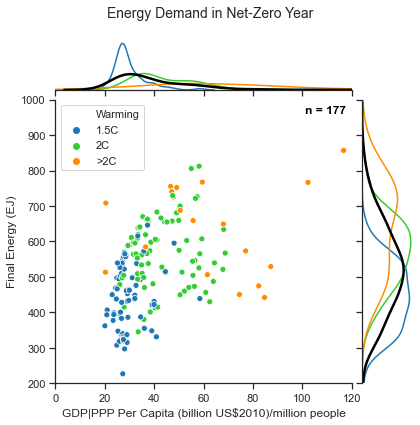

Figure 1b, trajectory


Median Net-Zero Year, Early: 2052.0
Min Net-Zero Year, Early: 2037
Max Net-Zero Year, Early: 2064
Median Net-Zero Year, Late: 2082.0
Min Net-Zero Year, Late: 2065
Max Net-Zero Year, Late: 2100


Median Net-Zero Year, 1.5C: 2052.0
Mean Net-Zero Year, 1.5C: 2054.194805194805
Min Net-Zero Year, 1.5C: 2037
Max Net-Zero Year, 1.5C: 2100


Median Net-Zero Year, 2C: 2073.0
Mean Net-Zero Year, 2C: 2075.2716049382716
Min Net-Zero Year, 2C: 2050
Max Net-Zero Year, 2C: 2100


Median Net-Zero Year, >2C: 2088.0
Mean Net-Zero Year, >2C: 2087.8947368421054
Min Net-Zero Year, >2C: 2066
Max Net-Zero Year, >2C: 2100


Median Net-Zero Year, all: 2064.0
Mean Net-Zero Year, all: 2067.4576271186443
Min Net-Zero Year, all: 2037
Max Net-Zero Year, all: 2100
F_onewayResult(statistic=105.00944651444443, pvalue=1.2277477579528146e-30)


Median Max Emissions Year, Early: 2018.0
Min Max Emissions Year, Early: 2014
Max Max Emissions Year, Early: 2029
Median Max Emissions Year, Late: 2019.0
M

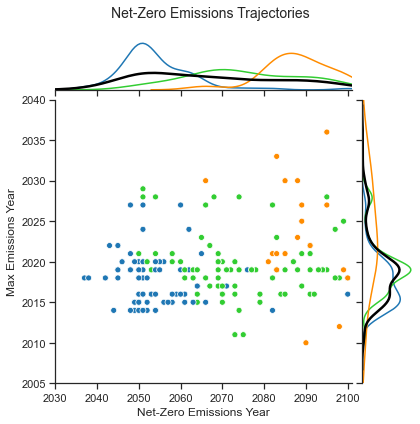

Figure 1c, energy sources


Median % primary energy from renewables, Early: 64.26113349460277
Minn % primary energy from renewables, Early: 25.8391810625474
Max % primary energy from renewables, Early: 78.25158668358884
Median % primary energy from renewables, Late: 58.582339841363044
Min % primary energy from renewables, Late: 33.50850321462268
Max % primary energy from renewables, Late: 93.6527456839288
Median % primary energy from renewables, 1.5C: 63.495927501904234
Min % primary energy from renewables, 1.5C: 27.99286828152176
Max % primary energy from renewables, 1.5C: 78.25158668358884
Median % primary energy from renewables, 2C: 59.36150452322446
Min % primary energy from renewables, 2C: 25.8391810625474
Max % primary energy from renewables, 2C: 93.6527456839288
Median % primary energy from renewables, >2C: 63.69425287924516
Min % primary energy from renewables, >2C: 33.50850321462268
Max % primary energy from renewables, >2C: 78.67826748762714
Median % primary energy from renew

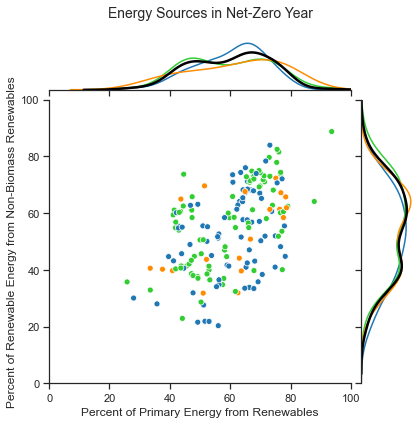

Figure 1d, residual ems


Median Ratio Final Energy:GDP, Early: 1.7384209641443995
Median Ratio Final Energy:GDP, Late: 1.386763156376217
Median Ratio Final Energy:GDP, 1.5C: 1.6526908871770465
Median Ratio Final Energy:GDP, 2C: 1.5372827060692835
Median Ratio Final Energy:GDP, >2C: 1.2815460803351848
Median Ratio Final Energy:GDP, all: 1.5535428551473545
F_onewayResult(statistic=6.238537513160291, pvalue=0.0024175228285191358)


Median Ratio Residual Emissions:Final Energy, Early: 20.229952176871123
Median Ratio Residual Emissions:Final Energy, Late: 18.969081165703084
Median Ratio Residual Emissions:Final Energy, 1.5C: 21.005434874073643
Median Ratio Residual Emissions:Final Energy, 2C: 18.841968141883957
Median Ratio Residual Emissions:Final Energy, >2C: 18.982782472978514
Median Ratio Residual Emissions:Final Energy, all: 19.59285098045622
F_onewayResult(statistic=2.3135089197123517, pvalue=0.10194894674931144)


Median Ratio Final Energy:GDP, all: 1.5535428551473545
Avg Ratio Fina

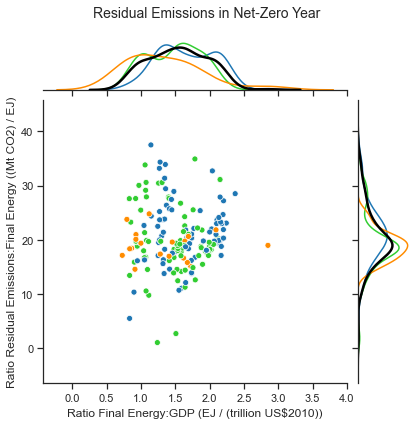

Figure 1e, electrification


Median Final Energy Per Person, Early: 0.050146899704221565
Min Final Energy Per Person, Early: 0.024538286835200568
Max Final Energy Per Person, Early: 0.0848900936695879
Median Final Energy Per Person, Late: 0.062339805173516366
Min Final Energy Per Person, Late: 0.03606558546357179
Max Final Energy Per Person, Late: 0.10813984241657948
Median Final Energy Per Person, 1.5C: 0.04740388505315754
Min Final Energy Per Person, 1.5C: 0.024538286835200568
Max Final Energy Per Person, 1.5C: 0.07621578729661009
Median Final Energy Per Person, 2C: 0.0628493114854467
Min Final Energy Per Person, 2C: 0.03606558546357179
Max Final Energy Per Person, 2C: 0.08873195383384154
Median Final Energy Per Person, >2C: 0.07536955060605106
Min Final Energy Per Person, >2C: 0.04248758805731452
Max Final Energy Per Person, >2C: 0.10813984241657948
Median Final Energy Per Person, all: 0.056648043497583477
Min Final Energy Per Person, all: 0.024538286835200568
Max Final Energy Per P

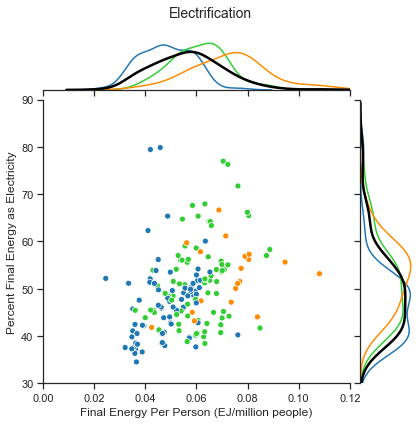

Figure 1ev2, electrification


Median Per Capita Residual E+I emissions, Early: 1.026972478180118
Median Per Capita Residual E+I emissions, Late: 1.186255002456146
Median Per Capita Residual E+I emissions, 1.5C: 0.9957603328145596
Median Per Capita Residual E+I emissions, 2C: 1.1625450449980879
Median Per Capita Residual E+I emissions, >2C: 1.2623524342416816
Median Per Capita Residual E+I emissions, all: 1.1043586911459207
Median Percent Final Energy as Electricity, Early: 47.32289305176114
Median Percent Final Energy as Electricity, Late: 49.07890851635139
Median Percent Final Energy as Electricity, 1.5C: 46.132884920919366
Median Percent Final Energy as Electricity, 2C: 50.867312707699476
Median Percent Final Energy as Electricity, >2C: 53.17508695402934
Median Percent Final Energy as Electricity, all: 48.50306095698603




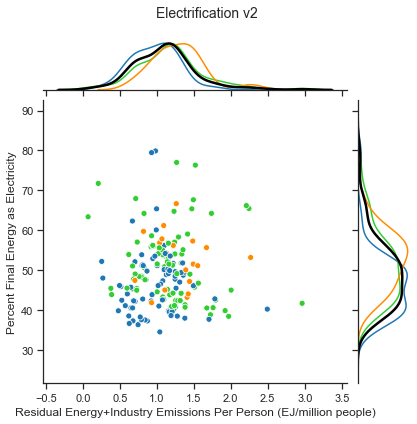

Figure 1f, policy


Median Carbon Price in Net-Zero Year, Early: 486.5325108231726
Median Carbon Price in Net-Zero Year, Late: 499.09599348772343
Median Carbon Price in Net-Zero Year, 1.5C: 640.1061803492858
Median Carbon Price in Net-Zero Year, 2C: 402.21000039185054
Median Carbon Price in Net-Zero Year, >2C: 505.37660212191724
Median Carbon Price in Net-Zero Year, all: 492.8153848535296
F_onewayResult(statistic=1.9090371044208632, pvalue=0.1513146875455807)


Median BECCS in Net-Zero Year, Early: 6425.2941
Median BECCS in Net-Zero Year Late: 8466.477041352917
Median BECCS in Net-Zero Year, 1.5C: 6356.807
Median BECCS in Net-Zero Year 2C: 7977.406938706754
Median BECCS in Net-Zero Year, >2C: 11260.362972993451
Median BECCS in Net-Zero Year, all: 7481.3174776205615
F_onewayResult(statistic=10.834623770553836, pvalue=3.675535180657545e-05)


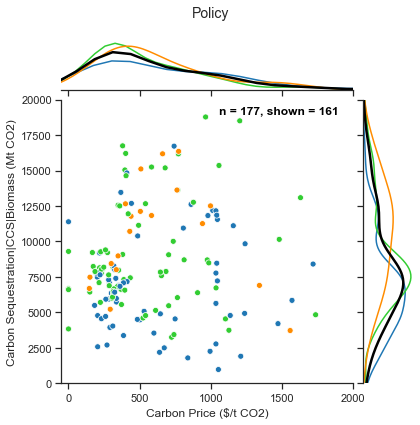

Figure S1, energy and economy max vs warming


Median Max GDP, Early: 565305.4
Median Max GDP, Late: 577757.125
Median Max GDP, 1.5C: 561780.23
Median Max GDP, 2C: 572753.5329999999
Median Max GDP, >2C: 585117.72
Median Max GDP, all: 569449.1
Median Max Final Energy, Early: 630.2297063999999
Median Max Final Energy, Late: 618.593949256247
Median Max Final Energy, 1.5C: 543.8104467999999
Median Max Final Energy, 2C: 675.0310357999999
Median Max Final Energy, >2C: 698.4
Median Max Final Energy, all: 624.033198512494


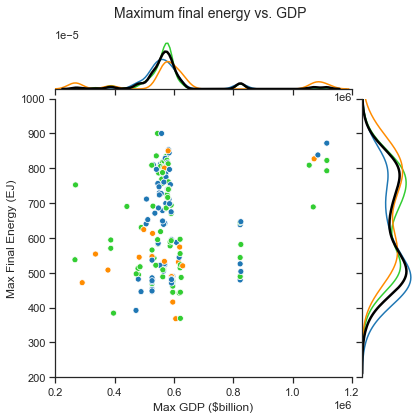

Figure XXX, per capita emissions vs. per capita BECCS by warming group


Median Per Capita Residual E+I emissions, Early: 1.026972478180118
Median Per Capita Residual E+I emissions, Late: 1.186255002456146
Median Per Capita Residual E+I emissions, 1.5C: 0.9957603328145596
Median Per Capita Residual E+I emissions, 2C: 1.1625450449980879
Median Per Capita Residual E+I emissions, >2C: 1.2623524342416816
Median Per Capita Residual E+I emissions, all: 1.1043586911459207
Median Per Capita BECCS, Early: 0.6910776122613606
Median Per Capita BECCS, Late: 0.9618767498211601
Median Per Capita BECCS, 1.5C: 0.6910776122613606
Median Per Capita BECCS, 2C: 0.8506819299314134
Median Per Capita BECCS, >2C: 1.1158760346463836
Median Per Capita BECCS, all: 0.8267476708328475


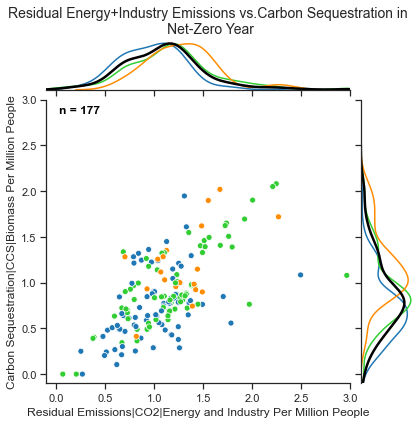

In [8]:
# plotting and printing summary data
xvar='Per Capita GDP in Net-Zero Year'
yvar='Final Energy in Net-Zero Year'
demgrid = sns.JointGrid(x=xvar, y=yvar, xlim=[0,120], ylim=[200,1000], data=more_vars10) #, ax=axd[1])
dem = demgrid.plot_joint(sns.scatterplot, hue='Warming', data=more_vars10) # hue='Early or Late Net-Zero Year'
grid = dem
for i in range(len(warmcat)):
    sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], xvar], ax=grid.ax_marg_x, legend=False)
    sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
# for i in range(len(timing)):
#     sns.kdeplot(more_vars10.loc[more_vars10['Early or Late Net-Zero Year']==timing[i], xvar], ax=grid.ax_marg_x, legend=False)
#     sns.kdeplot(more_vars10.loc[more_vars10['Early or Late Net-Zero Year']==timing[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', xvar], ax=grid.ax_marg_x, color='black', linewidth=2.5, legend=False)
sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', yvar], ax=grid.ax_marg_y, vertical=True, color='black', linewidth=2.5, legend=False)
plt.subplots_adjust(top=0.9)
dem.fig.suptitle('Energy Demand in Net-Zero Year', fontsize=14)
demgrid.set_axis_labels('GDP|PPP Per Capita (billion US$2010)/million people', scat_var[8]+' (EJ)', fontsize=12)
dem.fig.text(0.72, 0.7325, 'n = ' + str(len(more_vars10)), horizontalalignment='left', size='medium', color='black', weight='semibold')
# plt.savefig('Demand_NetZero_Energy_v2', bbox_inches='tight')
# plt.savefig('Demand_NetZero_Energy_v2.pdf', bbox_inches='tight')
# plt.savefig('Demand_NetZero_Energy_earlylate_v2.eps', format='eps', bbox_inches='tight')
print('Figure 1a, energy use')
print('\n')
print('Median GDP per capita, Early: '+ str(groupearly['Per Capita GDP in Net-Zero Year'].median()))
print('Min GDP per capita, Early: '+ str(groupearly['Per Capita GDP in Net-Zero Year'].min()))
print('Max GDP per capita, Early: '+ str(groupearly['Per Capita GDP in Net-Zero Year'].max()))
print('Median GDP per capita, Late: '+ str(grouplate['Per Capita GDP in Net-Zero Year'].median()))
print('Min GDP per capita, Late: '+ str(grouplate['Per Capita GDP in Net-Zero Year'].min()))
print('Max GDP per capita, Late: '+ str(grouplate['Per Capita GDP in Net-Zero Year'].max()))
print('Median GDP per capita, 1.5C: '+ str(group1p5['Per Capita GDP in Net-Zero Year'].median()))
print('Min GDP per capita, 1.5C: '+ str(group1p5['Per Capita GDP in Net-Zero Year'].min()))
print('Max GDP per capita, 1.5C: '+ str(group1p5['Per Capita GDP in Net-Zero Year'].max()))
print('Median GDP per capita, 2C: '+ str(group2['Per Capita GDP in Net-Zero Year'].median()))
print('Min GDP per capita, 2C: '+ str(group2['Per Capita GDP in Net-Zero Year'].min()))
print('Max GDP per capita, 2C: '+ str(group2['Per Capita GDP in Net-Zero Year'].max()))
print('Median GDP per capita, >2C: '+ str(group2plus['Per Capita GDP in Net-Zero Year'].median()))
print('Min GDP per capita, >2C: '+ str(group2plus['Per Capita GDP in Net-Zero Year'].min()))
print('Max GDP per capita, >2C: '+ str(group2plus['Per Capita GDP in Net-Zero Year'].max()))
print('Median GDP per capita, all: '+ str(more_vars10['Per Capita GDP in Net-Zero Year'].median()))
print('Min GDP per capita, all: '+ str(more_vars10['Per Capita GDP in Net-Zero Year'].min()))
print('Max GDP per capita, all: '+ str(more_vars10['Per Capita GDP in Net-Zero Year'].max()))
print('Median GDP per capita, above 1.5C: '+ str(groupabove1p5['Per Capita GDP in Net-Zero Year'].median()))
print('Min GDP per capita, above 1.5C: '+ str(groupabove1p5['Per Capita GDP in Net-Zero Year'].min()))
print('Max GDP per capita, above 1.5C: '+ str(groupabove1p5['Per Capita GDP in Net-Zero Year'].max()))
print(stats.f_oneway(more_vars10['Per Capita GDP in Net-Zero Year'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Per Capita GDP in Net-Zero Year'][more_vars10['Warming'] == '2C'],
               more_vars10['Per Capita GDP in Net-Zero Year'][more_vars10['Warming'] == '>2C']))
print('\n')
print(stats.ttest_ind(groupabove1p5['Per Capita GDP in Net-Zero Year'], group1p5['Per Capita GDP in Net-Zero Year']))
print('\n')
print('Percent scenarios <$40,000/person, 1.5 scenarios: '+ str((((group1p5['Per Capita GDP in Net-Zero Year'] < 40).sum())/(len(group1p5))) * 100) + ' %')
print('Percent scenarios <$40,000/person, 2.0 and >2.0 scenarios: '+ str((((groupabove1p5['Per Capita GDP in Net-Zero Year'] < 40).sum())/(len(groupabove1p5))) * 100) + ' %')
print('\n')
print('Median Final Energy, Early: '+ str(groupearly['Final Energy in Net-Zero Year'].median()))
print('Min Final Energy, Early: '+ str(groupearly['Final Energy in Net-Zero Year'].min()))
print('Max Final Energy, Early: '+ str(groupearly['Final Energy in Net-Zero Year'].max()))
print('Median Final Energy, Late: '+ str(grouplate['Final Energy in Net-Zero Year'].median()))
print('Min Final Energy, Late: '+ str(grouplate['Final Energy in Net-Zero Year'].min()))
print('Max Final Energy, Late: '+ str(grouplate['Final Energy in Net-Zero Year'].max()))
print('Median Final Energy, 1.5C: '+ str(group1p5['Final Energy in Net-Zero Year'].median()))
print('Min Final Energy, 1.5C: '+ str(group1p5['Final Energy in Net-Zero Year'].min()))
print('Max Final Energy, 1.5C: '+ str(group1p5['Final Energy in Net-Zero Year'].max()))
print('Median Final Energy, 2C: '+ str(group2['Final Energy in Net-Zero Year'].median()))
print('Min Final Energy, 2C: '+ str(group2['Final Energy in Net-Zero Year'].min()))
print('Max Final Energy, 2C: '+ str(group2['Final Energy in Net-Zero Year'].max()))
print('Median Final Energy, >2C: '+ str(group2plus['Final Energy in Net-Zero Year'].median()))
print('Min Final Energy, >2C: '+ str(group2plus['Final Energy in Net-Zero Year'].min()))
print('Max Final Energy, >2C: '+ str(group2plus['Final Energy in Net-Zero Year'].max()))
print('Median Final Energy, all: '+ str(more_vars10['Final Energy in Net-Zero Year'].median()))
print('Min Final Energy, all: '+ str(more_vars10['Final Energy in Net-Zero Year'].min()))
print('Max Final Energy, all: '+ str(more_vars10['Final Energy in Net-Zero Year'].max()))
print('Median Final Energy, above 1.5C: '+ str(groupabove1p5['Final Energy in Net-Zero Year'].median()))
print('Min Final Energy, above 1.5C: '+ str(groupabove1p5['Final Energy in Net-Zero Year'].min()))
print('Max Final Energy, above 1.5C: '+ str(groupabove1p5['Final Energy in Net-Zero Year'].max()))
print('\n')
print(stats.f_oneway(more_vars10['Final Energy in Net-Zero Year'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Final Energy in Net-Zero Year'][more_vars10['Warming'] == '2C'],
               more_vars10['Final Energy in Net-Zero Year'][more_vars10['Warming'] == '>2C']))
print('\n')
print(stats.ttest_ind(groupabove1p5['Final Energy in Net-Zero Year'], group1p5['Final Energy in Net-Zero Year']))
print('\n')
print('Percent scenarios <500EJ, 1.5 scenarios: '+ str((((group1p5['Final Energy in Net-Zero Year'] < 500).sum())/(len(group1p5))) * 100) + ' %')
print('Percent scenarios <500EJ, 2.0 and >2.0 scenarios: '+ str((((groupabove1p5['Final Energy in Net-Zero Year'] < 500).sum())/(len(groupabove1p5))) * 100) + ' %')
print('\n')
plt.show()



xvar='Net-Zero Year'
yvar='Max Emissions Year'
trajgrid = sns.JointGrid(x=xvar, y=yvar, xlim=[2030,2101], ylim=[2005,2040], data=more_vars10) #, ax=axd[1])
traj = trajgrid.plot_joint(sns.scatterplot, hue='Warming', legend=False, data=more_vars10) # hue='Early or Late Net-Zero Year'
grid = traj
for i in range(len(warmcat)):
    sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], xvar], ax=grid.ax_marg_x, legend=False)
    sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', xvar], ax=grid.ax_marg_x, color='black', linewidth=2.5, legend=False)
sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', yvar], ax=grid.ax_marg_y, vertical=True, color='black', linewidth=2.5, legend=False)
plt.subplots_adjust(top=0.9)
traj.fig.suptitle('Net-Zero Emissions Trajectories', fontsize=14)
trajgrid.set_axis_labels('Net-Zero Emissions Year', 'Max Emissions Year', fontsize=12)
# plt.savefig('Trajectory_NetZero_Energy', bbox_inches='tight')
# plt.savefig('Trajectory_NetZero_Energy.pdf', bbox_inches='tight')
# plt.savefig('Trajectory_NetZero_Energy_earlylate_v2.eps', format='eps', bbox_inches='tight')
print('Figure 1b, trajectory')
print('\n')
print('Median Net-Zero Year, Early: '+ str(groupearly['Net-Zero Year'].median()))
print('Min Net-Zero Year, Early: '+ str(groupearly['Net-Zero Year'].min()))
print('Max Net-Zero Year, Early: '+ str(groupearly['Net-Zero Year'].max()))
print('Median Net-Zero Year, Late: '+ str(grouplate['Net-Zero Year'].median()))
print('Min Net-Zero Year, Late: '+ str(grouplate['Net-Zero Year'].min()))
print('Max Net-Zero Year, Late: '+ str(grouplate['Net-Zero Year'].max()))
print('\n')
print('Median Net-Zero Year, 1.5C: '+ str(group1p5['Net-Zero Year'].median()))
print('Mean Net-Zero Year, 1.5C: '+ str(group1p5['Net-Zero Year'].mean()))
print('Min Net-Zero Year, 1.5C: '+ str(group1p5['Net-Zero Year'].min()))
print('Max Net-Zero Year, 1.5C: '+ str(group1p5['Net-Zero Year'].max()))
print('\n')
print('Median Net-Zero Year, 2C: '+ str(group2['Net-Zero Year'].median()))
print('Mean Net-Zero Year, 2C: '+ str(group2['Net-Zero Year'].mean()))
print('Min Net-Zero Year, 2C: '+ str(group2['Net-Zero Year'].min()))
print('Max Net-Zero Year, 2C: '+ str(group2['Net-Zero Year'].max()))
print('\n')
print('Median Net-Zero Year, >2C: '+ str(group2plus['Net-Zero Year'].median()))
print('Mean Net-Zero Year, >2C: '+ str(group2plus['Net-Zero Year'].mean()))
print('Min Net-Zero Year, >2C: '+ str(group2plus['Net-Zero Year'].min()))
print('Max Net-Zero Year, >2C: '+ str(group2plus['Net-Zero Year'].max()))
print('\n')
print('Median Net-Zero Year, all: '+ str(more_vars10['Net-Zero Year'].median()))
print('Mean Net-Zero Year, all: '+ str(more_vars10['Net-Zero Year'].mean()))
print('Min Net-Zero Year, all: '+ str(more_vars10['Net-Zero Year'].min()))
print('Max Net-Zero Year, all: '+ str(more_vars10['Net-Zero Year'].max()))
print(stats.f_oneway(more_vars10['Net-Zero Year'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Net-Zero Year'][more_vars10['Warming'] == '2C'],
               more_vars10['Net-Zero Year'][more_vars10['Warming'] == '>2C']))
print('\n')
print('Median Max Emissions Year, Early: '+ str(groupearly['Max Emissions Year'].median()))
print('Min Max Emissions Year, Early: '+ str(groupearly['Max Emissions Year'].min()))
print('Max Max Emissions Year, Early: '+ str(groupearly['Max Emissions Year'].max()))
print('Median Max Emissions Year, Late: '+ str(grouplate['Max Emissions Year'].median()))
print('Min Max Emissions Year, Late: '+ str(grouplate['Max Emissions Year'].min()))
print('Max Max Emissions Year, Late: '+ str(grouplate['Max Emissions Year'].max()))
print('Median Max Emissions Year, 1.5C: '+ str(group1p5['Max Emissions Year'].median()))
print('Min Max Emissions Year, 1.5C: '+ str(group1p5['Max Emissions Year'].min()))
print('Max Max Emissions Year, 1.5C: '+ str(group1p5['Max Emissions Year'].max()))
print('Median Max Emissions Year, 2C: '+ str(group2['Max Emissions Year'].median()))
print('Min Max Emissions Year, 2C: '+ str(group2['Max Emissions Year'].min()))
print('Max Max Emissions Year, 2C: '+ str(group2['Max Emissions Year'].max()))
print('Median Max Emissions Year, >2C: '+ str(group2plus['Max Emissions Year'].median()))
print('Min Max Emissions Year, >2C: '+ str(group2plus['Max Emissions Year'].min()))
print('Max Max Emissions Year, >2C: '+ str(group2plus['Max Emissions Year'].max()))
print('Median Max Emissions Year, all: '+ str(more_vars10['Max Emissions Year'].median()))
print('Min Max Emissions Year, all: '+ str(more_vars10['Max Emissions Year'].min()))
print('Max Max Emissions Year, all: '+ str(more_vars10['Max Emissions Year'].max()))
print(stats.f_oneway(more_vars10['Max Emissions Year'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Max Emissions Year'][more_vars10['Warming'] == '2C'],
               more_vars10['Max Emissions Year'][more_vars10['Warming'] == '>2C']))
plt.show()


xvar='Percent of Primary Energy from Renewables'
yvar='Percent of Renewable Energy from Non-Biomass Renewables'
supgrid = sns.JointGrid(x=xvar, y=yvar, xlim=[0,100], ylim=[0,100], data=more_vars10) #, ax=axd[1])
sup = supgrid.plot_joint(sns.scatterplot, hue='Warming', legend=False, data=more_vars10) # hue='Early or Late Net-Zero Year'
grid = sup
for i in range(len(warmcat)):
    sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], xvar], ax=grid.ax_marg_x, legend=False)
    sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', xvar], ax=grid.ax_marg_x, color='black', linewidth=2.5, legend=False)
sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', yvar], ax=grid.ax_marg_y, vertical=True, color='black', linewidth=2.5, legend=False)
plt.subplots_adjust(top=0.9)
sup.fig.suptitle('Energy Sources in Net-Zero Year', fontsize=14)
supgrid.set_axis_labels('Percent of Primary Energy from Renewables', 'Percent of Renewable Energy from Non-Biomass Renewables', fontsize=12)
# plt.savefig('Supply_NetZero_Energy', bbox_inches='tight')
# plt.savefig('Supply_NetZero_Energy.pdf', bbox_inches='tight')
# plt.savefig('Supply_NetZero_Energy_earlylate_v2.eps', format='eps', bbox_inches='tight')
print('Figure 1c, energy sources')
print('\n')
print('Median % primary energy from renewables, Early: '+ str(groupearly['Percent of Primary Energy from Renewables'].median()))
print('Minn % primary energy from renewables, Early: '+ str(groupearly['Percent of Primary Energy from Renewables'].min()))
print('Max % primary energy from renewables, Early: '+ str(groupearly['Percent of Primary Energy from Renewables'].max()))
print('Median % primary energy from renewables, Late: '+ str(grouplate['Percent of Primary Energy from Renewables'].median()))
print('Min % primary energy from renewables, Late: '+ str(grouplate['Percent of Primary Energy from Renewables'].min()))
print('Max % primary energy from renewables, Late: '+ str(grouplate['Percent of Primary Energy from Renewables'].max()))
print('Median % primary energy from renewables, 1.5C: '+ str(group1p5['Percent of Primary Energy from Renewables'].median()))
print('Min % primary energy from renewables, 1.5C: '+ str(group1p5['Percent of Primary Energy from Renewables'].min()))
print('Max % primary energy from renewables, 1.5C: '+ str(group1p5['Percent of Primary Energy from Renewables'].max()))
print('Median % primary energy from renewables, 2C: '+ str(group2['Percent of Primary Energy from Renewables'].median()))
print('Min % primary energy from renewables, 2C: '+ str(group2['Percent of Primary Energy from Renewables'].min()))
print('Max % primary energy from renewables, 2C: '+ str(group2['Percent of Primary Energy from Renewables'].max()))
print('Median % primary energy from renewables, >2C: '+ str(group2plus['Percent of Primary Energy from Renewables'].median()))
print('Min % primary energy from renewables, >2C: '+ str(group2plus['Percent of Primary Energy from Renewables'].min()))
print('Max % primary energy from renewables, >2C: '+ str(group2plus['Percent of Primary Energy from Renewables'].max()))
print('Median % primary energy from renewables, all: '+ str(more_vars10['Percent of Primary Energy from Renewables'].median()))
print('Min % primary energy from renewables, all: '+ str(more_vars10['Percent of Primary Energy from Renewables'].min()))
print('Max % primary energy from renewables, all: '+ str(more_vars10['Percent of Primary Energy from Renewables'].max()))
print(stats.f_oneway(more_vars10['Percent of Primary Energy from Renewables'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Percent of Primary Energy from Renewables'][more_vars10['Warming'] == '2C'],
               more_vars10['Percent of Primary Energy from Renewables'][more_vars10['Warming'] == '>2C']))
print('\n')
print('Percent scenarios >50% renewables: '+ str((((more_vars10['Percent of Primary Energy from Renewables'] > 50).sum())/(len(more_vars10))) * 100) + ' %')
print('\n')
print('Median % renewable energy, non-biomass, Early: '+ str(groupearly['Percent of Renewable Energy from Non-Biomass Renewables'].median()))
print('Min % renewable energy, non-biomass, Early: '+ str(groupearly['Percent of Renewable Energy from Non-Biomass Renewables'].min()))
print('Max % renewable energy, non-biomass, Early: '+ str(groupearly['Percent of Renewable Energy from Non-Biomass Renewables'].max()))
print('Median % renewable energy, non-biomass, Late: '+ str(grouplate['Percent of Renewable Energy from Non-Biomass Renewables'].median()))
print('Min % renewable energy, non-biomass, Late: '+ str(grouplate['Percent of Renewable Energy from Non-Biomass Renewables'].min()))
print('Max % renewable energy, non-biomass, Late: '+ str(grouplate['Percent of Renewable Energy from Non-Biomass Renewables'].max()))
print('Median % renewable energy, non-biomass, 1.5C: '+ str(group1p5['Percent of Renewable Energy from Non-Biomass Renewables'].median()))
print('Min % renewable energy, non-biomass, 1.5C: '+ str(group1p5['Percent of Renewable Energy from Non-Biomass Renewables'].min()))
print('Max % renewable energy, non-biomass, 1.5C: '+ str(group1p5['Percent of Renewable Energy from Non-Biomass Renewables'].max()))
print('Median % renewable energy, non-biomass, 2C: '+ str(group2['Percent of Renewable Energy from Non-Biomass Renewables'].median()))
print('Min % renewable energy, non-biomass, 2C: '+ str(group2['Percent of Renewable Energy from Non-Biomass Renewables'].min()))
print('Max % renewable energy, non-biomass, 2C: '+ str(group2['Percent of Renewable Energy from Non-Biomass Renewables'].max()))
print('Median % renewable energy, non-biomass, >2C: '+ str(group2plus['Percent of Renewable Energy from Non-Biomass Renewables'].median()))
print('Min % renewable energy, non-biomass, >2C: '+ str(group2plus['Percent of Renewable Energy from Non-Biomass Renewables'].min()))
print('Max % renewable energy, non-biomass, >2C: '+ str(group2plus['Percent of Renewable Energy from Non-Biomass Renewables'].max()))
print('Median % renewable energy, non-biomass, all: '+ str(more_vars10['Percent of Renewable Energy from Non-Biomass Renewables'].median()))
print('Min % renewable energy, non-biomass, all: '+ str(more_vars10['Percent of Renewable Energy from Non-Biomass Renewables'].min()))
print('Max % renewable energy, non-biomass, all: '+ str(more_vars10['Percent of Renewable Energy from Non-Biomass Renewables'].max()))
print(stats.f_oneway(more_vars10['Percent of Renewable Energy from Non-Biomass Renewables'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Percent of Renewable Energy from Non-Biomass Renewables'][more_vars10['Warming'] == '2C'],
               more_vars10['Percent of Renewable Energy from Non-Biomass Renewables'][more_vars10['Warming'] == '>2C']))
plt.show()


more_vars10['Ratio Final Energy:GDP'] = (more_vars10['Final Energy in Net-Zero Year'] / \
                                    more_vars10['GDP|PPP in Net-Zero Year']) * 1000
xvar='Ratio Final Energy:GDP'
yvar='Ratio Residual Emissions:Final Energy'
resgrid = sns.JointGrid(x=xvar, y=yvar, data=more_vars10) #, ax=axd[1]) xlim=[0.5,3], ylim=[0,40], 
res = resgrid.plot_joint(sns.scatterplot, hue='Warming', legend=False, data=more_vars10) # hue='Early or Late Net-Zero Year'
grid = res
for i in range(len(warmcat)):
    sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], xvar], ax=grid.ax_marg_x, legend=False)
    sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', xvar], ax=grid.ax_marg_x, color='black', linewidth=2.5, legend=False)
sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', yvar], ax=grid.ax_marg_y, vertical=True, color='black', linewidth=2.5, legend=False)
plt.subplots_adjust(top=0.9)
res.fig.suptitle('Residual Emissions in Net-Zero Year', fontsize=14)
resgrid.set_axis_labels('Ratio Final Energy:GDP (EJ / (trillion US$2010))', 'Ratio Residual Emissions:Final Energy ((Mt CO2) / EJ)', fontsize=12)
# plt.savefig('Residual_NetZero_Energy', bbox_inches='tight')
# plt.savefig('Residual_NetZero_Energy.pdf', bbox_inches='tight')
# plt.savefig('Residual_NetZero_Energy_earlylate_v2.eps', format='eps', bbox_inches='tight')
print('Figure 1d, residual ems')
print('\n')
print('Median Ratio Final Energy:GDP, Early: '+ str(groupearly['Ratio Final Energy:GDP'].median()))
print('Median Ratio Final Energy:GDP, Late: '+ str(grouplate['Ratio Final Energy:GDP'].median()))
print('Median Ratio Final Energy:GDP, 1.5C: '+ str(group1p5['Ratio Final Energy:GDP'].median()))
print('Median Ratio Final Energy:GDP, 2C: '+ str(group2['Ratio Final Energy:GDP'].median()))
print('Median Ratio Final Energy:GDP, >2C: '+ str(group2plus['Ratio Final Energy:GDP'].median()))
print('Median Ratio Final Energy:GDP, all: '+ str(more_vars10['Ratio Final Energy:GDP'].median()))
print(stats.f_oneway(more_vars10['Ratio Final Energy:GDP'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Ratio Final Energy:GDP'][more_vars10['Warming'] == '2C'],
               more_vars10['Ratio Final Energy:GDP'][more_vars10['Warming'] == '>2C']))
print('\n')
print('Median Ratio Residual Emissions:Final Energy, Early: '+ str(groupearly['Ratio Residual Emissions:Final Energy'].median()))
print('Median Ratio Residual Emissions:Final Energy, Late: '+ str(grouplate['Ratio Residual Emissions:Final Energy'].median()))
print('Median Ratio Residual Emissions:Final Energy, 1.5C: '+ str(group1p5['Ratio Residual Emissions:Final Energy'].median()))
print('Median Ratio Residual Emissions:Final Energy, 2C: '+ str(group2['Ratio Residual Emissions:Final Energy'].median()))
print('Median Ratio Residual Emissions:Final Energy, >2C: '+ str(group2plus['Ratio Residual Emissions:Final Energy'].median()))
print('Median Ratio Residual Emissions:Final Energy, all: '+ str(more_vars10['Ratio Residual Emissions:Final Energy'].median()))
print(stats.f_oneway(more_vars10['Ratio Residual Emissions:Final Energy'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Ratio Residual Emissions:Final Energy'][more_vars10['Warming'] == '2C'],
               more_vars10['Ratio Residual Emissions:Final Energy'][more_vars10['Warming'] == '>2C']))
print('\n')
print('Median Ratio Final Energy:GDP, all: '+ str(more_vars10['Ratio Final Energy:GDP'].median()))
print('Avg Ratio Final Energy:GDP, all: '+ str(more_vars10['Ratio Final Energy:GDP'].mean()))
print('Max Ratio Final Energy:GDP, all: '+ str(more_vars10['Ratio Final Energy:GDP'].max()))
print('Min Ratio Final Energy:GDP, all: '+ str(more_vars10['Ratio Final Energy:GDP'].min()))
print('\n')
print('Median Ratio Final Energy:GDP, 1.5C: '+ str(group1p5['Ratio Final Energy:GDP'].median()))
print('Avg Ratio Final Energy:GDP, 1.5C: '+ str(group1p5['Ratio Final Energy:GDP'].mean()))
print('Max Ratio Final Energy:GDP, 1.5C: '+ str(group1p5['Ratio Final Energy:GDP'].max()))
print('Min Ratio Final Energy:GDP, 1.5C: '+ str(group1p5['Ratio Final Energy:GDP'].min()))
print('\n')
print('Median Ratio Final Energy:GDP, 2C: '+ str(group2['Ratio Final Energy:GDP'].median()))
print('Avg Ratio Final Energy:GDP, 2C: '+ str(group2['Ratio Final Energy:GDP'].mean()))
print('Max Ratio Final Energy:GDP, 2C: '+ str(group2['Ratio Final Energy:GDP'].max()))
print('Min Ratio Final Energy:GDP, 2C: '+ str(group2['Ratio Final Energy:GDP'].min()))
print('\n')
print('Median Ratio Final Energy:GDP, >2C: '+ str(group2plus['Ratio Final Energy:GDP'].median()))
print('Avg Ratio Final Energy:GDP, >2C: '+ str(group2plus['Ratio Final Energy:GDP'].mean()))
print('Max Ratio Final Energy:GDP, >2C: '+ str(group2plus['Ratio Final Energy:GDP'].max()))
print('Min Ratio Final Energy:GDP, >2C: '+ str(group2plus['Ratio Final Energy:GDP'].min()))
print('\n')
plt.show()



xvar='Final Energy Per Person'
yvar='Percent Final Energy as Electricity'
elecgrid = sns.JointGrid(x=xvar, y=yvar, xlim=[0,0.12], ylim=[30,90], data=more_vars10) #, ax=axd[1])
elec = elecgrid.plot_joint(sns.scatterplot, hue='Warming', legend=False, data=more_vars10) # hue='Early or Late Net-Zero Year'
grid = elec
for i in range(len(warmcat)):
    sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], xvar], ax=grid.ax_marg_x, legend=False)
    sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', xvar], ax=grid.ax_marg_x, color='black', linewidth=2.5, legend=False)
sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', yvar], ax=grid.ax_marg_y, vertical=True, color='black', linewidth=2.5, legend=False)
plt.subplots_adjust(top=0.9)
elec.fig.suptitle('Electrification', fontsize=14)
elecgrid.set_axis_labels('Final Energy Per Person (EJ/million people)', 'Percent Final Energy as Electricity', fontsize=12)
# plt.savefig('Electric_NetZero_Energy', bbox_inches='tight')
# plt.savefig('Electric_NetZero_Energy.pdf', bbox_inches='tight')
# plt.savefig('Electric_NetZero_Energy_earlylate_v2.eps', format='eps', bbox_inches='tight')
print('Figure 1e, electrification')
print('\n')
print('Median Final Energy Per Person, Early: '+ str(groupearly['Final Energy Per Person'].median()))
print('Min Final Energy Per Person, Early: '+ str(groupearly['Final Energy Per Person'].min()))
print('Max Final Energy Per Person, Early: '+ str(groupearly['Final Energy Per Person'].max()))
print('Median Final Energy Per Person, Late: '+ str(grouplate['Final Energy Per Person'].median()))
print('Min Final Energy Per Person, Late: '+ str(grouplate['Final Energy Per Person'].min()))
print('Max Final Energy Per Person, Late: '+ str(grouplate['Final Energy Per Person'].max()))
print('Median Final Energy Per Person, 1.5C: '+ str(group1p5['Final Energy Per Person'].median()))
print('Min Final Energy Per Person, 1.5C: '+ str(group1p5['Final Energy Per Person'].min()))
print('Max Final Energy Per Person, 1.5C: '+ str(group1p5['Final Energy Per Person'].max()))
print('Median Final Energy Per Person, 2C: '+ str(group2['Final Energy Per Person'].median()))
print('Min Final Energy Per Person, 2C: '+ str(group2['Final Energy Per Person'].min()))
print('Max Final Energy Per Person, 2C: '+ str(group2['Final Energy Per Person'].max()))
print('Median Final Energy Per Person, >2C: '+ str(group2plus['Final Energy Per Person'].median()))
print('Min Final Energy Per Person, >2C: '+ str(group2plus['Final Energy Per Person'].min()))
print('Max Final Energy Per Person, >2C: '+ str(group2plus['Final Energy Per Person'].max()))
print('Median Final Energy Per Person, all: '+ str(more_vars10['Final Energy Per Person'].median()))
print('Min Final Energy Per Person, all: '+ str(more_vars10['Final Energy Per Person'].min()))
print('Max Final Energy Per Person, all: '+ str(more_vars10['Final Energy Per Person'].max()))
print('Avg Final Energy Per Person, all: '+ str(more_vars10['Final Energy Per Person'].mean()))
print(stats.f_oneway(more_vars10['Final Energy Per Person'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Final Energy Per Person'][more_vars10['Warming'] == '2C'],
               more_vars10['Final Energy Per Person'][more_vars10['Warming'] == '>2C']))
print('\n')
print('Median Percent Final Energy as Electricity, Early: '+ str(groupearly['Percent Final Energy as Electricity'].median()))
print('Min Percent Final Energy as Electricity, Early: '+ str(groupearly['Percent Final Energy as Electricity'].min()))
print('Max Percent Final Energy as Electricity, Early: '+ str(groupearly['Percent Final Energy as Electricity'].max()))
print('Median Percent Final Energy as Electricity, Late: '+ str(grouplate['Percent Final Energy as Electricity'].median()))
print('Min Percent Final Energy as Electricity, Late: '+ str(grouplate['Percent Final Energy as Electricity'].min()))
print('Max Percent Final Energy as Electricity, Late: '+ str(grouplate['Percent Final Energy as Electricity'].max()))
print('Median Percent Final Energy as Electricity, 1.5C: '+ str(group1p5['Percent Final Energy as Electricity'].median()))
print('Min Percent Final Energy as Electricity, 1.5C: '+ str(group1p5['Percent Final Energy as Electricity'].min()))
print('Max Percent Final Energy as Electricity, 1.5C: '+ str(group1p5['Percent Final Energy as Electricity'].max()))
print('Median Percent Final Energy as Electricity, 2C: '+ str(group2['Percent Final Energy as Electricity'].median()))
print('Min Percent Final Energy as Electricity, 2C: '+ str(group2['Percent Final Energy as Electricity'].min()))
print('Max Percent Final Energy as Electricity, 2C: '+ str(group2['Percent Final Energy as Electricity'].max()))
print('Median Percent Final Energy as Electricity, >2C: '+ str(group2plus['Percent Final Energy as Electricity'].median()))
print('Min Percent Final Energy as Electricity, >2C: '+ str(group2plus['Percent Final Energy as Electricity'].min()))
print('Max Percent Final Energy as Electricity, >2C: '+ str(group2plus['Percent Final Energy as Electricity'].max()))
print('Median Percent Final Energy as Electricity, all: '+ str(more_vars10['Percent Final Energy as Electricity'].median()))
print('Min Percent Final Energy as Electricity, all: '+ str(more_vars10['Percent Final Energy as Electricity'].min()))
print('Max Percent Final Energy as Electricity, all: '+ str(more_vars10['Percent Final Energy as Electricity'].max()))
print(stats.f_oneway(more_vars10['Percent Final Energy as Electricity'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Percent Final Energy as Electricity'][more_vars10['Warming'] == '2C'],
               more_vars10['Percent Final Energy as Electricity'][more_vars10['Warming'] == '>2C']))
plt.show()



xvar='Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'
yvar='Percent Final Energy as Electricity'
elecgrid = sns.JointGrid(x=xvar, y=yvar, data = more_vars10) #xlim=[0,0.12], ylim=[30,90], data=more_vars10) #, ax=axd[1])
elec = elecgrid.plot_joint(sns.scatterplot, hue='Warming', legend=False, data=more_vars10) # hue='Early or Late Net-Zero Year'
grid = elec
for i in range(len(warmcat)):
    sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], xvar], ax=grid.ax_marg_x, legend=False)
    sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', xvar], ax=grid.ax_marg_x, color='black', linewidth=2.5, legend=False)
sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', yvar], ax=grid.ax_marg_y, vertical=True, color='black', linewidth=2.5, legend=False)
plt.subplots_adjust(top=0.9)
elec.fig.suptitle('Electrification v2', fontsize=14)
elecgrid.set_axis_labels('Residual Energy+Industry Emissions Per Person (EJ/million people)', 'Percent Final Energy as Electricity', fontsize=12)
# plt.savefig('Electric_NetZero_Energy', bbox_inches='tight')
# plt.savefig('Electric_NetZero_Energy.pdf', bbox_inches='tight')
# plt.savefig('Electric_NetZero_Energy.eps', format='eps', bbox_inches='tight')
print('Figure 1ev2, electrification')
print('\n')
print('Median Per Capita Residual E+I emissions, Early: '+ str(groupearly['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
print('Median Per Capita Residual E+I emissions, Late: '+ str(grouplate['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
print('Median Per Capita Residual E+I emissions, 1.5C: '+ str(group1p5['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
print('Median Per Capita Residual E+I emissions, 2C: '+ str(group2['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
print('Median Per Capita Residual E+I emissions, >2C: '+ str(group2plus['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
print('Median Per Capita Residual E+I emissions, all: '+ str(more_vars10['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
print('Median Percent Final Energy as Electricity, Early: '+ str(groupearly['Percent Final Energy as Electricity'].median()))
print('Median Percent Final Energy as Electricity, Late: '+ str(grouplate['Percent Final Energy as Electricity'].median()))
print('Median Percent Final Energy as Electricity, 1.5C: '+ str(group1p5['Percent Final Energy as Electricity'].median()))
print('Median Percent Final Energy as Electricity, 2C: '+ str(group2['Percent Final Energy as Electricity'].median()))
print('Median Percent Final Energy as Electricity, >2C: '+ str(group2plus['Percent Final Energy as Electricity'].median()))
print('Median Percent Final Energy as Electricity, all: '+ str(more_vars10['Percent Final Energy as Electricity'].median()))
print('\n')
plt.show()



xvar='Carbon Price in Net-Zero Year'
yvar='Carbon Sequestration|CCS|Biomass in Net-Zero Year'
pricegrid = sns.JointGrid(x=xvar, y=yvar, xlim=[-50,2000], ylim=[0,20000], data=more_vars10) #, ax=axd[1])
price = pricegrid.plot_joint(sns.scatterplot, hue='Warming', legend=False, data=more_vars10) # hue='Early or Late Net-Zero Year'
grid = price
for i in range(len(warmcat)):
    sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], xvar], ax=grid.ax_marg_x, legend=False)
    sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', xvar], ax=grid.ax_marg_x, color='black', linewidth=2.5, legend=False)
sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', yvar], ax=grid.ax_marg_y, vertical=True, color='black', linewidth=2.5, legend=False)
plt.subplots_adjust(top=0.9)
price.fig.suptitle('Policy', fontsize=14)
pricegrid.set_axis_labels('Carbon Price ($/t CO2)', 'Carbon Sequestration|CCS|Biomass (Mt CO2)', fontsize=12)
price.fig.text(0.52, 0.7325, 'n = ' + str(len(more_vars10)) + ', shown = ' + str(len(more_vars10)-16), horizontalalignment='left', size='medium', color='black', weight='semibold')
# plt.savefig('Policy2_NetZero_Energy', bbox_inches='tight')
# plt.savefig('Policy2_NetZero_Energy.pdf', bbox_inches='tight')
# plt.savefig('Policy2_NetZero_Energy_earlylate_v2.eps', format='eps', bbox_inches='tight')
print('Figure 1f, policy')
print('\n')
print('Median Carbon Price in Net-Zero Year, Early: '+ str(groupearly['Carbon Price in Net-Zero Year'].median()))
print('Median Carbon Price in Net-Zero Year, Late: '+ str(grouplate['Carbon Price in Net-Zero Year'].median()))
print('Median Carbon Price in Net-Zero Year, 1.5C: '+ str(group1p5['Carbon Price in Net-Zero Year'].median()))
print('Median Carbon Price in Net-Zero Year, 2C: '+ str(group2['Carbon Price in Net-Zero Year'].median()))
print('Median Carbon Price in Net-Zero Year, >2C: '+ str(group2plus['Carbon Price in Net-Zero Year'].median()))
print('Median Carbon Price in Net-Zero Year, all: '+ str(more_vars10['Carbon Price in Net-Zero Year'].median()))
print(stats.f_oneway(more_vars10['Carbon Price in Net-Zero Year'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Carbon Price in Net-Zero Year'][more_vars10['Warming'] == '2C'],
               more_vars10['Carbon Price in Net-Zero Year'][more_vars10['Warming'] == '>2C']))
print('\n')
print('Median BECCS in Net-Zero Year, Early: '+ str(groupearly['Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
print('Median BECCS in Net-Zero Year Late: '+ str(grouplate['Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
print('Median BECCS in Net-Zero Year, 1.5C: '+ str(group1p5['Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
print('Median BECCS in Net-Zero Year 2C: '+ str(group2['Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
print('Median BECCS in Net-Zero Year, >2C: '+ str(group2plus['Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
print('Median BECCS in Net-Zero Year, all: '+ str(more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
print(stats.f_oneway(more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'][more_vars10['Warming'] == '2C'],
               more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'][more_vars10['Warming'] == '>2C']))
plt.show()


# For supplementary fig. S1, data points are NOT in net-zero year. They show the maximum GDP and Final Energy for each scenario through 2100.
xvar='Max GDP ($billion US$2010/year)'
yvar='Max Final Energy (EJ)'
resnewgrid = sns.JointGrid(x='Max GDP ($billion US$2010/year)', y='Max Final Energy (EJ)', xlim=[200000,1200000], ylim=[200,1000], data=supfig_vars) #, ax=axd[1])
resnew = resnewgrid.plot_joint(sns.scatterplot, hue='Warming', legend=False, data=more_vars10) # hue='Early or Late Net-Zero Year'
grid = resnew
for i in range(len(warmcat)):
    sns.kdeplot(supfig_vars.loc[supfig_vars['Warming']==warmcat[i], xvar], ax=grid.ax_marg_x, legend=False)
    sns.kdeplot(supfig_vars.loc[supfig_vars['Warming']==warmcat[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
sns.kdeplot(supfig_vars.loc[supfig_vars['Region']=='World', xvar], ax=grid.ax_marg_x, color='black', linewidth=2.5, legend=False)
sns.kdeplot(supfig_vars.loc[supfig_vars['Region']=='World', yvar], ax=grid.ax_marg_y, vertical=True, color='black', linewidth=2.5, legend=False)
plt.subplots_adjust(top=0.9)
resnew.fig.suptitle('Maximum final energy vs. GDP', fontsize=14)
resnewgrid.set_axis_labels('Max GDP ($billion)', 'Max Final Energy (EJ)', fontsize=12)
# plt.savefig('S4_NetZero_Energy', bbox_inches='tight')
# plt.savefig('S4_NetZero_Energy.pdf', bbox_inches='tight')
# plt.savefig('S4_NetZero_Energy_earlylate_v2.eps', format='eps', bbox_inches='tight')
print('Figure S1, energy and economy max vs warming')
print('\n')
print('Median Max GDP, Early: '+ str(supgroupearly['Max GDP ($billion US$2010/year)'].median()))
print('Median Max GDP, Late: '+ str(supgrouplate['Max GDP ($billion US$2010/year)'].median()))
print('Median Max GDP, 1.5C: '+ str(supgroup1p5['Max GDP ($billion US$2010/year)'].median()))
print('Median Max GDP, 2C: '+ str(supgroup2['Max GDP ($billion US$2010/year)'].median()))
print('Median Max GDP, >2C: '+ str(supgroup2plus['Max GDP ($billion US$2010/year)'].median()))
print('Median Max GDP, all: '+ str(supfig_vars['Max GDP ($billion US$2010/year)'].median()))
print('Median Max Final Energy, Early: '+ str(supgroupearly['Max Final Energy (EJ)'].median()))
print('Median Max Final Energy, Late: '+ str(supgrouplate['Max Final Energy (EJ)'].median()))
print('Median Max Final Energy, 1.5C: '+ str(supgroup1p5['Max Final Energy (EJ)'].median()))
print('Median Max Final Energy, 2C: '+ str(supgroup2['Max Final Energy (EJ)'].median()))
print('Median Max Final Energy, >2C: '+ str(supgroup2plus['Max Final Energy (EJ)'].median()))
print('Median Max Final Energy, all: '+ str(supfig_vars['Max Final Energy (EJ)'].median()))
plt.show()



xvar='Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'
yvar='Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'
resgrid2 = sns.JointGrid(x=xvar, y=yvar, xlim=[-0.1,3], ylim=[-0.1,3], data=more_vars10)
res2 = resgrid2.plot_joint(sns.scatterplot, hue='Warming', legend=False, data=more_vars10) # hue='Early or Late Net-Zero Year'
grid = res2
for i in range(len(warmcat)):
    sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], xvar], ax=grid.ax_marg_x, legend=False)
    sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', xvar], ax=grid.ax_marg_x, color='black', linewidth=2.5, legend=False)
sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', yvar], ax=grid.ax_marg_y, vertical=True, color='black', linewidth=2.5, legend=False)
plt.subplots_adjust(top=0.9)
res2.fig.suptitle('Residual Energy+Industry Emissions vs.Carbon Sequestration in \nNet-Zero Year', fontsize=14)
resgrid2.set_axis_labels('Residual Emissions|CO2|Energy and Industry Per Million People', 'Carbon Sequestration|CCS|Biomass Per Million People', fontsize=12)
res2.fig.text(0.15, 0.7325, 'n = ' + str(len(more_vars10)), horizontalalignment='left', size='medium', color='black', weight='semibold')
# plt.savefig('PerCapitaEms_NetZero_Energy', bbox_inches='tight')
# plt.savefig('PerCapitaEms_NetZero_Energy.pdf', bbox_inches='tight')
# plt.savefig('PerCapitaEms_NetZero_Energy_earlylate_v2.eps', format='eps', bbox_inches='tight')
print('Figure XXX, per capita emissions vs. per capita BECCS by warming group')
print('\n')
print('Median Per Capita Residual E+I emissions, Early: '+ str(groupearly['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
print('Median Per Capita Residual E+I emissions, Late: '+ str(grouplate['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
print('Median Per Capita Residual E+I emissions, 1.5C: '+ str(group1p5['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
print('Median Per Capita Residual E+I emissions, 2C: '+ str(group2['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
print('Median Per Capita Residual E+I emissions, >2C: '+ str(group2plus['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
print('Median Per Capita Residual E+I emissions, all: '+ str(more_vars10['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
print('Median Per Capita BECCS, Early: '+ str(groupearly['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
print('Median Per Capita BECCS, Late: '+ str(grouplate['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
print('Median Per Capita BECCS, 1.5C: '+ str(group1p5['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
print('Median Per Capita BECCS, 2C: '+ str(group2['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
print('Median Per Capita BECCS, >2C: '+ str(group2plus['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
print('Median Per Capita BECCS, all: '+ str(more_vars10['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


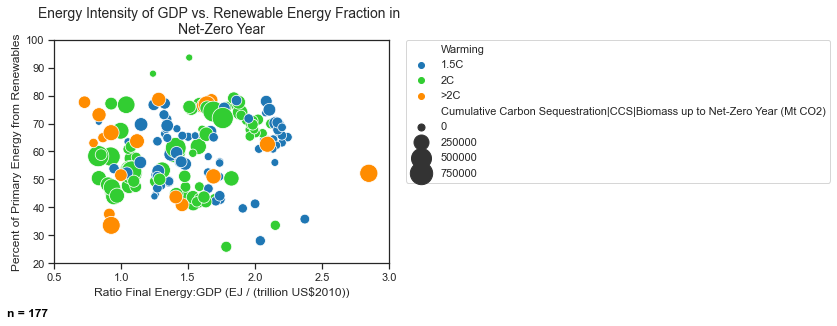

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


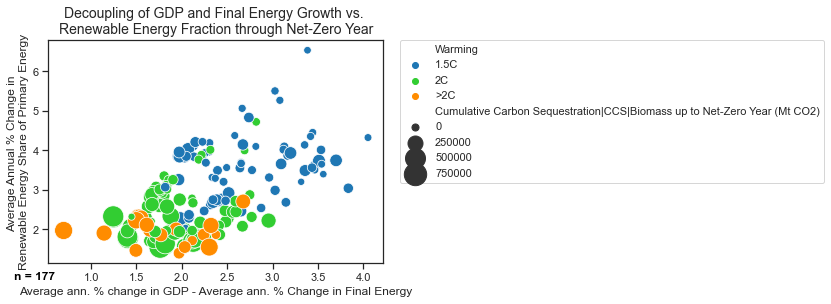

In [9]:
xvar='Ratio Final Energy:GDP'
yvar='Percent of Primary Energy from Renewables'
minsize=50
maxsize=500
res2 = sns.scatterplot(x=xvar, y=yvar, hue='Warming', \
                       size='Cumulative Carbon Sequestration|CCS|Biomass up to Net-Zero Year (Mt CO2)', \
                       sizes=(minsize,maxsize), legend='brief', data=more_vars10)
# resgrid2 = sns.JointGrid(x=xvar, y=yvar, data=more_vars10) # xlim=[-0.1,3], ylim=[-0.1,3], 
# res2 = resgrid2.plot_joint(sns.scatterplot, hue='Warming', s='Cumulative Carbon Sequestration|CCS|Biomass up to Net-Zero Year', legend=True, data=more_vars10) # hue='Early or Late Net-Zero Year'
# grid = res2
# for i in range(len(warmcat)):
#     sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], xvar], ax=grid.ax_marg_x, legend=False)
#     sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
# sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', xvar], ax=grid.ax_marg_x, color='black', linewidth=2.5, legend=False)
# sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', yvar], ax=grid.ax_marg_y, vertical=True, color='black', linewidth=2.5, legend=False)
plt.subplots_adjust(top=0.9)
plt.title('Energy Intensity of GDP vs. Renewable Energy Fraction in \nNet-Zero Year', fontsize=14)
plt.xlabel('Ratio Final Energy:GDP (EJ / (trillion US$2010))')
plt.ylabel('Percent of Primary Energy from Renewables')
plt.text(0.15, 0.7325, 'n = ' + str(len(more_vars10)), horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.xlim(0.5,3)
plt.ylim(20,100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# plt.savefig('PerCapitaEms_NetZero_Energy', bbox_inches='tight')
plt.savefig('CCS_energyintensity_vs_renewables_v1.pdf', bbox_inches='tight')
plt.savefig('CCS_energyintensity_vs_renewables_v1.eps', format='eps', bbox_inches='tight')
plt.show()



xvar='Decoupling of GDP and Final Energy Increase (Average ann. % change in GDP - Average ann. % Change in Final Energy)'
yvar='Average Annual % Change in Renewable Energy Share of Primary Energy'
minsize=50
maxsize=500
res2 = sns.scatterplot(x=xvar, y=yvar, hue='Warming', \
                       size='Cumulative Carbon Sequestration|CCS|Biomass up to Net-Zero Year (Mt CO2)', \
                       sizes=(minsize,maxsize), legend='brief', data=more_vars10)
# resgrid2 = sns.JointGrid(x=xvar, y=yvar, data=more_vars10) # xlim=[-0.1,3], ylim=[-0.1,3], 
# res2 = resgrid2.plot_joint(sns.scatterplot, hue='Warming', s='Cumulative Carbon Sequestration|CCS|Biomass up to Net-Zero Year', legend=True, data=more_vars10) # hue='Early or Late Net-Zero Year'
# grid = res2
# for i in range(len(warmcat)):
#     sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], xvar], ax=grid.ax_marg_x, legend=False)
#     sns.kdeplot(more_vars10.loc[more_vars10['Warming']==warmcat[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
# sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', xvar], ax=grid.ax_marg_x, color='black', linewidth=2.5, legend=False)
# sns.kdeplot(more_vars10.loc[more_vars10['Region']=='World', yvar], ax=grid.ax_marg_y, vertical=True, color='black', linewidth=2.5, legend=False)
plt.subplots_adjust(top=0.9)
plt.title('Decoupling of GDP and Final Energy Growth vs. \nRenewable Energy Fraction through Net-Zero Year', fontsize=14)
plt.xlabel('Average ann. % change in GDP - Average ann. % Change in Final Energy')
plt.ylabel('Average Annual % Change in \nRenewable Energy Share of Primary Energy')
plt.text(0.15, 0.7325, 'n = ' + str(len(more_vars10)), horizontalalignment='left', size='medium', color='black', weight='semibold')
# plt.xlim(0.5,3)
# plt.ylim(20,100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# plt.savefig('PerCapitaEms_NetZero_Energy', bbox_inches='tight')
plt.savefig('CCS_energyintensity_vs_renewables_v2.pdf', bbox_inches='tight')
plt.savefig('CCS_energyintensity_vs_renewables_v2.eps', format='eps', bbox_inches='tight')
plt.show()

In [10]:
# ANOVA analysis of variation across warming groups
print('Percent Final Energy as Electricity')
print(stats.f_oneway(more_vars10['Percent Final Energy as Electricity'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Percent Final Energy as Electricity'][more_vars10['Warming'] == '2C'],
               more_vars10['Percent Final Energy as Electricity'][more_vars10['Warming'] == '>2C']))
print('\n')
print('Percent of Primary Energy from Fossil')
print(stats.f_oneway(more_vars10['Percent of Primary Energy from Fossil'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Percent of Primary Energy from Fossil'][more_vars10['Warming'] == '2C'],
               more_vars10['Percent of Primary Energy from Fossil'][more_vars10['Warming'] == '>2C']))
print('\n')
print('Percent of Primary Energy from Nuclear')
print(stats.f_oneway(more_vars10['Percent of Primary Energy from Nuclear'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Percent of Primary Energy from Nuclear'][more_vars10['Warming'] == '2C'],
               more_vars10['Percent of Primary Energy from Nuclear'][more_vars10['Warming'] == '>2C']))
print('\n')
print('Percent of Primary Energy from Renewables')
print(stats.f_oneway(more_vars10['Percent of Primary Energy from Renewables'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Percent of Primary Energy from Renewables'][more_vars10['Warming'] == '2C'],
               more_vars10['Percent of Primary Energy from Renewables'][more_vars10['Warming'] == '>2C']))
print('\n')
print('Percent of Primary Energy from Non-Biomass Renewables')
print(stats.f_oneway(more_vars10['Percent of Primary Energy from Non-Biomass Renewables'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Percent of Primary Energy from Non-Biomass Renewables'][more_vars10['Warming'] == '2C'],
               more_vars10['Percent of Primary Energy from Non-Biomass Renewables'][more_vars10['Warming'] == '>2C']))
print('\n')
print('Final Energy Per Person')
print(stats.f_oneway(more_vars10['Final Energy Per Person'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Final Energy Per Person'][more_vars10['Warming'] == '2C'],
               more_vars10['Final Energy Per Person'][more_vars10['Warming'] == '>2C']))
print('\n')
print('Carbon Sequestration|CCS|Biomass in Net-Zero Year')
print(stats.f_oneway(more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'][more_vars10['Warming'] == '2C'],
               more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'][more_vars10['Warming'] == '>2C']))
print('\n')
print('Emissions|CO2|AFOLU in Net-Zero Year')
print(stats.f_oneway(more_vars10['Emissions|CO2|AFOLU in Net-Zero Year'][more_vars10['Warming'] == '1.5C'],
               more_vars10['Emissions|CO2|AFOLU in Net-Zero Year'][more_vars10['Warming'] == '2C'],
               more_vars10['Emissions|CO2|AFOLU in Net-Zero Year'][more_vars10['Warming'] == '>2C']))
print('\n')

Percent Final Energy as Electricity
F_onewayResult(statistic=7.568013995704526, pvalue=0.0007053807600965989)


Percent of Primary Energy from Fossil
F_onewayResult(statistic=0.619659934103057, pvalue=0.5393106201456559)


Percent of Primary Energy from Nuclear
F_onewayResult(statistic=0.9362828431057718, pvalue=0.3940487596042769)


Percent of Primary Energy from Renewables
F_onewayResult(statistic=0.2134271410798051, pvalue=0.8080221719948282)


Percent of Primary Energy from Non-Biomass Renewables
F_onewayResult(statistic=0.7534786784219106, pvalue=0.47225575850206347)


Final Energy Per Person
F_onewayResult(statistic=51.09654387768811, pvalue=3.48554372236425e-18)


Carbon Sequestration|CCS|Biomass in Net-Zero Year
F_onewayResult(statistic=10.834623770553836, pvalue=3.675535180657545e-05)


Emissions|CO2|AFOLU in Net-Zero Year
F_onewayResult(statistic=2.138476694573115, pvalue=0.12092104061554532)




Text(0.5, 1.0, 'Residual emissions model comparison for >2C Scenarios')

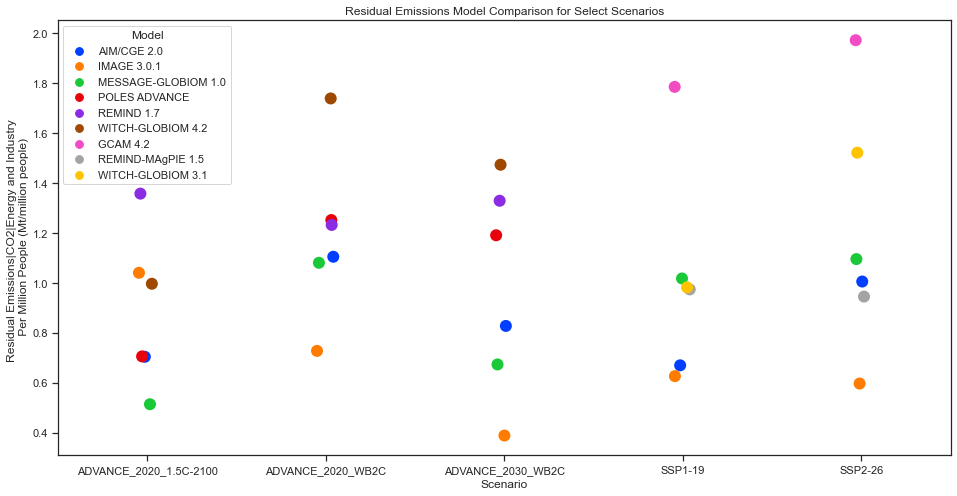

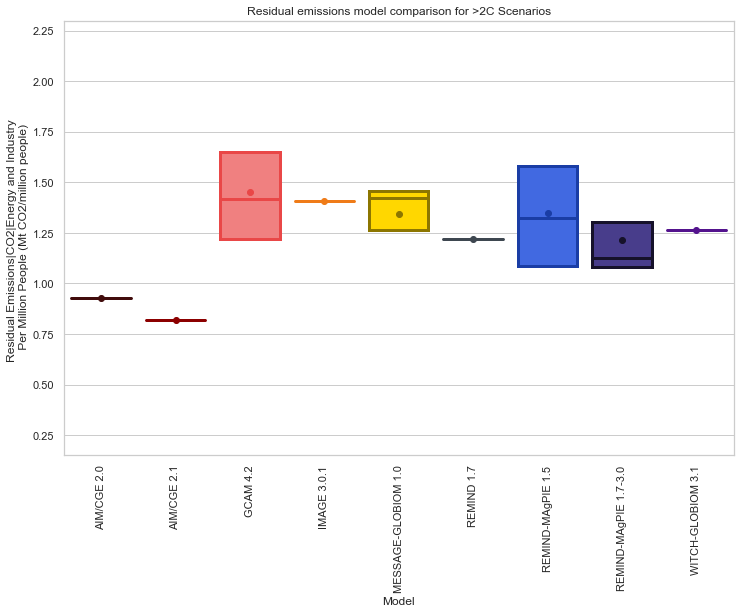

In [11]:
# Model comparison scatterplots

temp_colors = ['tab:blue', 'limegreen', 'darkorange', 'palevioletred', 'mediumpurple']
# temp_colors = ['fuchsia', 'firebrick', 'mediumspringgreen']
sns.set(style="ticks")
sns.set_palette(sns.color_palette(temp_colors))

scenarios1 = ['ADVANCE_2020_1.5C-2100','ADVANCE_2020_WB2C','ADVANCE_2030_WB2C', 'SSP1-19', 'SSP2-26']
model_comp = pd.DataFrame()
for i in range(len(scenarios1)):
    model_comp_data = more_vars10.groupby('Scenario').get_group(scenarios1[i])
    model_comp = pd.concat([model_comp, model_comp_data])
    
# print(model_comp)
markers = ['o','P','X','.','v','*','d','s','^','1','p','D','h','+']
fig,ax = plt.subplots(figsize=[16,8])
sns.stripplot(data=model_comp, x='Scenario', y='Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year', hue='Model', jitter=0.05, palette='bright', size=12) #, marker=markers[i]) #, col='Warming'# , markers=['o','P','X','.','v','*','d','s','^','1','p','D','h','+'])
ax.set_xlabel('Scenario')
ax.set_ylabel('Residual Emissions|CO2|Energy and Industry \n Per Million People (Mt/million people)')
ax.set_title('Residual Emissions Model Comparison for Select Scenarios')
# plt.savefig('Model_Scenario_Comparison.eps', format='eps', bbox_inches='tight')  


# Model comparison boxplots

temp_colors = ['tab:blue', 'limegreen', 'darkorange', 'palevioletred', 'mediumpurple']
# temp_colors = ['fuchsia', 'firebrick', 'mediumspringgreen']
sns.set(style="ticks")
sns.set_palette(sns.color_palette(temp_colors))

# scenarios1 = ['ADVANCE_2020_1.5C-2100','ADVANCE_2020_WB2C','ADVANCE_2030_WB2C', 'SSP1-19', 'SSP2-26']
model_comp = pd.DataFrame()
# for i in range(len(scenarios1)):
#     model_comp_data = more_vars10.groupby('Scenario').get_group(scenarios1[i])
#     model_comp = pd.concat([model_comp, model_comp_data])
    
model_comp1p5 = more_vars10.groupby('Warming').get_group('1.5C')
model_comp1p5 = model_comp1p5.sort_values(by=['Model'], ascending = True)
model_comp2 = more_vars10.groupby('Warming').get_group('2C')
model_comp2 = model_comp2.sort_values(by=['Model'], ascending = True)
model_comp2plus = more_vars10.groupby('Warming').get_group('>2C')
model_comp2plus = model_comp2plus.sort_values(by=['Model'], ascending = True)
    
boxprops = dict(linestyle='-')
flierprops = dict(marker='o', markerfacecolor='black', markersize=5,
                  linestyle='none')
medianprops = dict(linestyle='-', linewidth=3, color='black')
meanpointprops = dict(marker='o', markeredgecolor='black',
                      markerfacecolor='orchid', markersize=6)
meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(12,8))
ax.yaxis.grid(True)
ax.xaxis.grid(False)
my_pal = {'AIM/CGE 2.0':'firebrick', 'AIM/CGE 2.1':'red', 'GCAM 4.2':'lightcoral', 
          'IMAGE 3.0.1':'sandybrown', 'IMAGE 3.0.2':'tab:orange', 'MESSAGE-GLOBIOM 1.0':'gold', 
          'MESSAGEix-GLOBIOM 1.0':'yellowgreen', 'POLES ADVANCE':'seagreen', 'POLES CD-LINKS':'cadetblue', 
          'POLES EMF33':'steelblue', 'REMIND 1.7':'slategrey', 'REMIND-MAgPIE 1.5':'royalblue', 
          'REMIND-MAgPIE 1.7-3.0':'darkslateblue', 'WITCH-GLOBIOM 3.1':'blueviolet', 
          'WITCH-GLOBIOM 4.2':'orchid', 'WITCH-GLOBIOM 4.4':'mediumvioletred'}


# print(model_comp)
# 'Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'
# 'Percent of Renewable Energy from Non-Biomass Renewables'

sns.boxplot(data=model_comp2plus, x='Model', y='Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year', whis=[5,95], linewidth=3, notch=False, \
                 medianprops=medianprops, flierprops=flierprops, meanprops=meanpointprops, \
                 meanline=False, showmeans=True, showfliers=False, saturation=1, ax=ax, palette=my_pal)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.ylim(0.15,2.3)

# From StackOverflow:
import matplotlib.colors as mc
import colorsys

def lighten_color(color, amount=0.5):  
    # --------------------- SOURCE: @IanHincks ---------------------
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# --------------------- SOURCE: @tmdavison --------------------- 
for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    # col = artist.get_facecolor()
    col = lighten_color(artist.get_facecolor(), 1.45)
    artist.set_edgecolor(col)
    # artist.set_facecolor('None')

    # Each box has 7 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

# Also fix the legend
# for legpatch in ax.get_legend().get_patches():
    # col = legpatch.get_facecolor()
    # col = lighten_color(legpatch.get_facecolor(), 1.35)
    # legpatch.set_edgecolor(col)
    # legpatch.set_facecolor('None')
# ax = sns.swarmplot(x="value", y="Parameter", hue="Warming", data=mdf, color=".25")
# End section from StackOverflow


ax.set_xlabel('Model')
ax.set_ylabel('Residual Emissions|CO2|Energy and Industry \n Per Million People (Mt CO2/million people)')
ax.set_title('Residual emissions model comparison for >2C Scenarios')
# plt.savefig('Model_Comparison_2plus.eps', format='eps', bbox_inches='tight')  

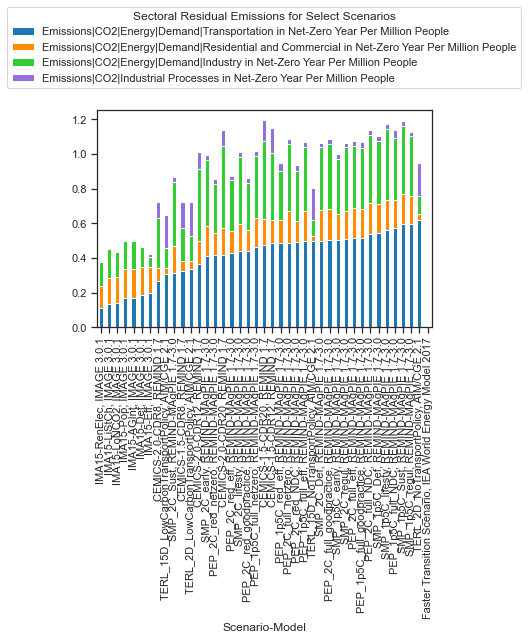

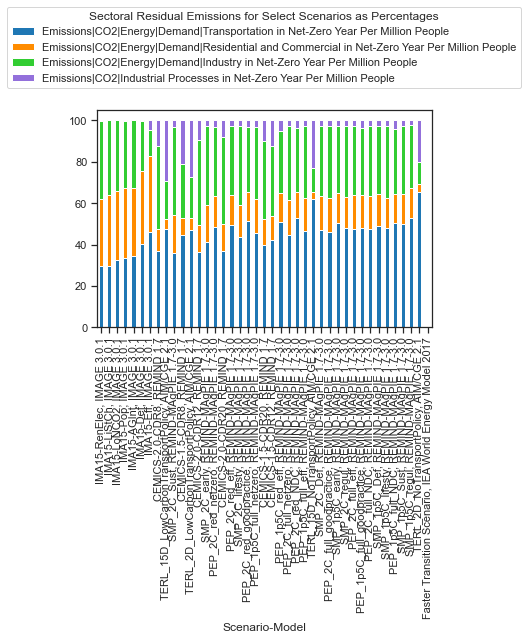

In [12]:
# Residual emissions SI fig bar plots, using more detailed scenario outputs

sns.set(style="ticks")

temp_colors = ['tab:blue', 'darkorange', 'limegreen', 'mediumpurple']
ax = detail_vars3.plot.bar(stacked=True, color=['tab:blue', 'darkorange', 'limegreen', 'mediumpurple']).legend(loc='upper center',bbox_to_anchor=(0.5, 1.5));
ax.set_title('Sectoral Residual Emissions for Select Scenarios')
# plt.savefig('Sectoral_Emissions.eps', format='eps', bbox_inches='tight')       
plt.show()

ax2 = detail_vars4.plot.bar(stacked=True, color=['tab:blue', 'darkorange', 'limegreen', 'mediumpurple']).legend(loc='upper center',bbox_to_anchor=(0.5, 1.5));
ax2.set_title('Sectoral Residual Emissions for Select Scenarios as Percentages')
# plt.savefig('Sectoral_Emissions_Percent.eps', format='eps', bbox_inches='tight')       
plt.show()

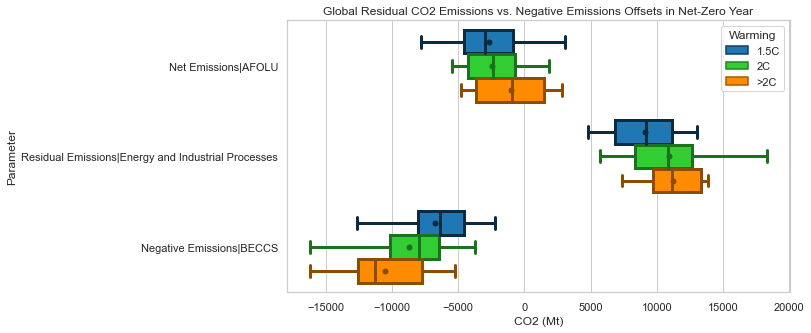

In [13]:
# Main text figure Boxplot code

import matplotlib.patches as mpatches
import matplotlib.colors as mc
import colorsys

x = range(len(full_co2_data))
more_vars11 = pd.DataFrame()
more_vars12 = pd.DataFrame()
more_vars13 = pd.DataFrame()
more_vars14 = pd.DataFrame()
more_vars15 = pd.DataFrame()
more_vars16 = pd.DataFrame()
more_vars17 = pd.DataFrame()
more_vars18 = pd.DataFrame()
more_vars19 = pd.DataFrame()
more_vars20 = pd.DataFrame()
more_vars21 = pd.DataFrame()
more_vars22 = pd.DataFrame()
more_vars23 = pd.DataFrame()
more_vars24 = pd.DataFrame()
more_vars25 = pd.DataFrame()
more_vars26 = pd.DataFrame()


more_vars11['1.5C'] \
    = more_vars10.groupby('Warming').get_group('1.5C')['Carbon Sequestration|CCS|Biomass in Net-Zero Year'] * -1
more_vars12['2C'] \
    = more_vars10.groupby('Warming').get_group('2C')['Carbon Sequestration|CCS|Biomass in Net-Zero Year'] * -1
more_vars13['>2C'] \
    = more_vars10.groupby('Warming').get_group('>2C')['Carbon Sequestration|CCS|Biomass in Net-Zero Year'] * -1
more_vars14 = pd.concat([more_vars11, more_vars12, more_vars13])
more_vars14['Parameter'] = 'Negative Emissions|BECCS'


more_vars15['1.5C'] \
    = more_vars10.groupby('Warming').get_group('1.5C')['Residual Emissions|Energy and Industrial Processes in Net-Zero Year']
more_vars16['2C'] \
    = more_vars10.groupby('Warming').get_group('2C')['Residual Emissions|Energy and Industrial Processes in Net-Zero Year']
more_vars17['>2C'] \
    = more_vars10.groupby('Warming').get_group('>2C')['Residual Emissions|Energy and Industrial Processes in Net-Zero Year']
more_vars18 = pd.concat([more_vars15, more_vars16, more_vars17])
more_vars18['Parameter'] = 'Residual Emissions|Energy and Industrial Processes'


more_vars23['1.5C'] \
    = more_vars10.groupby('Warming').get_group('1.5C')['Emissions|CO2|AFOLU in Net-Zero Year']
more_vars24['2C'] \
    = more_vars10.groupby('Warming').get_group('2C')['Emissions|CO2|AFOLU in Net-Zero Year']
more_vars25['>2C'] \
    = more_vars10.groupby('Warming').get_group('>2C')['Emissions|CO2|AFOLU in Net-Zero Year']
more_vars26 = pd.concat([more_vars23, more_vars24, more_vars25])
more_vars26['Parameter'] = 'Net Emissions|AFOLU'



# Plotting

warmcat = ['1.5C','2C','>2C']
temp_colors2 = ['tab:blue', 'limegreen', 'darkorange']

cdf = pd.concat([more_vars26, more_vars18, more_vars14])    
mdf = pd.melt(cdf, id_vars=['Parameter'], var_name=['Warming'])
# print(mdf)
boxprops = dict(linestyle='-')
flierprops = dict(marker='o', markerfacecolor='black', markersize=5,
                  linestyle='none')
medianprops = dict(linestyle='-', linewidth=3, color='black')
meanpointprops = dict(marker='o', markeredgecolor='black',
                      markerfacecolor='orchid', markersize=5)
meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
sns.set(style="whitegrid")
sns.set_palette(sns.color_palette(temp_colors2))
fig, ax = plt.subplots(figsize=(9,5))
ax.yaxis.grid(False)
ax.xaxis.grid(True)
sns.boxplot(x="value", y="Parameter", hue="Warming", data=mdf, whis=[5,95], linewidth=3, notch=False, \
                 medianprops=medianprops, flierprops=flierprops, meanprops=meanpointprops, \
                 meanline=False, showmeans=True, showfliers = False, saturation=1, ax=ax)

# From StackOverflow:
def lighten_color(color, amount=0.5):  
    # --------------------- SOURCE: @IanHincks ---------------------
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# --------------------- SOURCE: @tmdavison --------------------- 
for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    # col = artist.get_facecolor()
    col = lighten_color(artist.get_facecolor(), 1.45)
    artist.set_edgecolor(col)
    # artist.set_facecolor('None')

    # Each box has 7 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

# Also fix the legend
for legpatch in ax.get_legend().get_patches():
    # col = legpatch.get_facecolor()
    col = lighten_color(legpatch.get_facecolor(), 1.35)
    legpatch.set_edgecolor(col)
    # legpatch.set_facecolor('None')
# ax = sns.swarmplot(x="value", y="Parameter", hue="Warming", data=mdf, color=".25")
# End section from StackOverflow


# ax.set_yticks(y_pos-0.6)
ax.set_xlabel('CO2 (Mt)')
ax.set_title('Global Residual CO2 Emissions vs. Negative Emissions Offsets in Net-Zero Year')
# plt.savefig('Residual_boxplot3', bbox_inches='tight')
# plt.savefig('Residual_boxplot3.pdf', bbox_inches='tight')
# plt.savefig('Residual_boxplot3.eps', format='eps', bbox_inches='tight')
plt.show()



Mean % Final Energy as Electricity: 49.46428656813204 %, stdv = 8.796382703905447
Mean % Primary Energy from Non-Bio Renewables: 53.90743589962486 %, stdv = 15.07414200828477
Mean % Primary Energy from Renewables: 59.967412949663455 %, stdv = 12.753498571974836
Mean Final Energy Per Person: 56.82881730380364 GJ/person, stdv = 13.625535570679032
Mean Carbon Sequestration|BECCS: 8048.275144000198 Mt CO2, stdv = 3844.1459421911045
Mean Net Land Use Emissions: -2406.6447696499736 Mt CO2, stdv = 3252.243369184217


                                                        r             p
Percent Final Energy as Electricity                 1.000  0.000000e+00
Percent of Primary Energy from Renewables           0.638  1.220058e-21
Percent of Renewable Energy from Non-Biomass Re...  0.594  2.814877e-18
Final Energy Per Person                            -0.351  1.673751e-06
Carbon Sequestration|CCS|Biomass in Net-Zero Year   0.036  6.349935e-01
Residual Emissions|Energy and Industrial Proces...

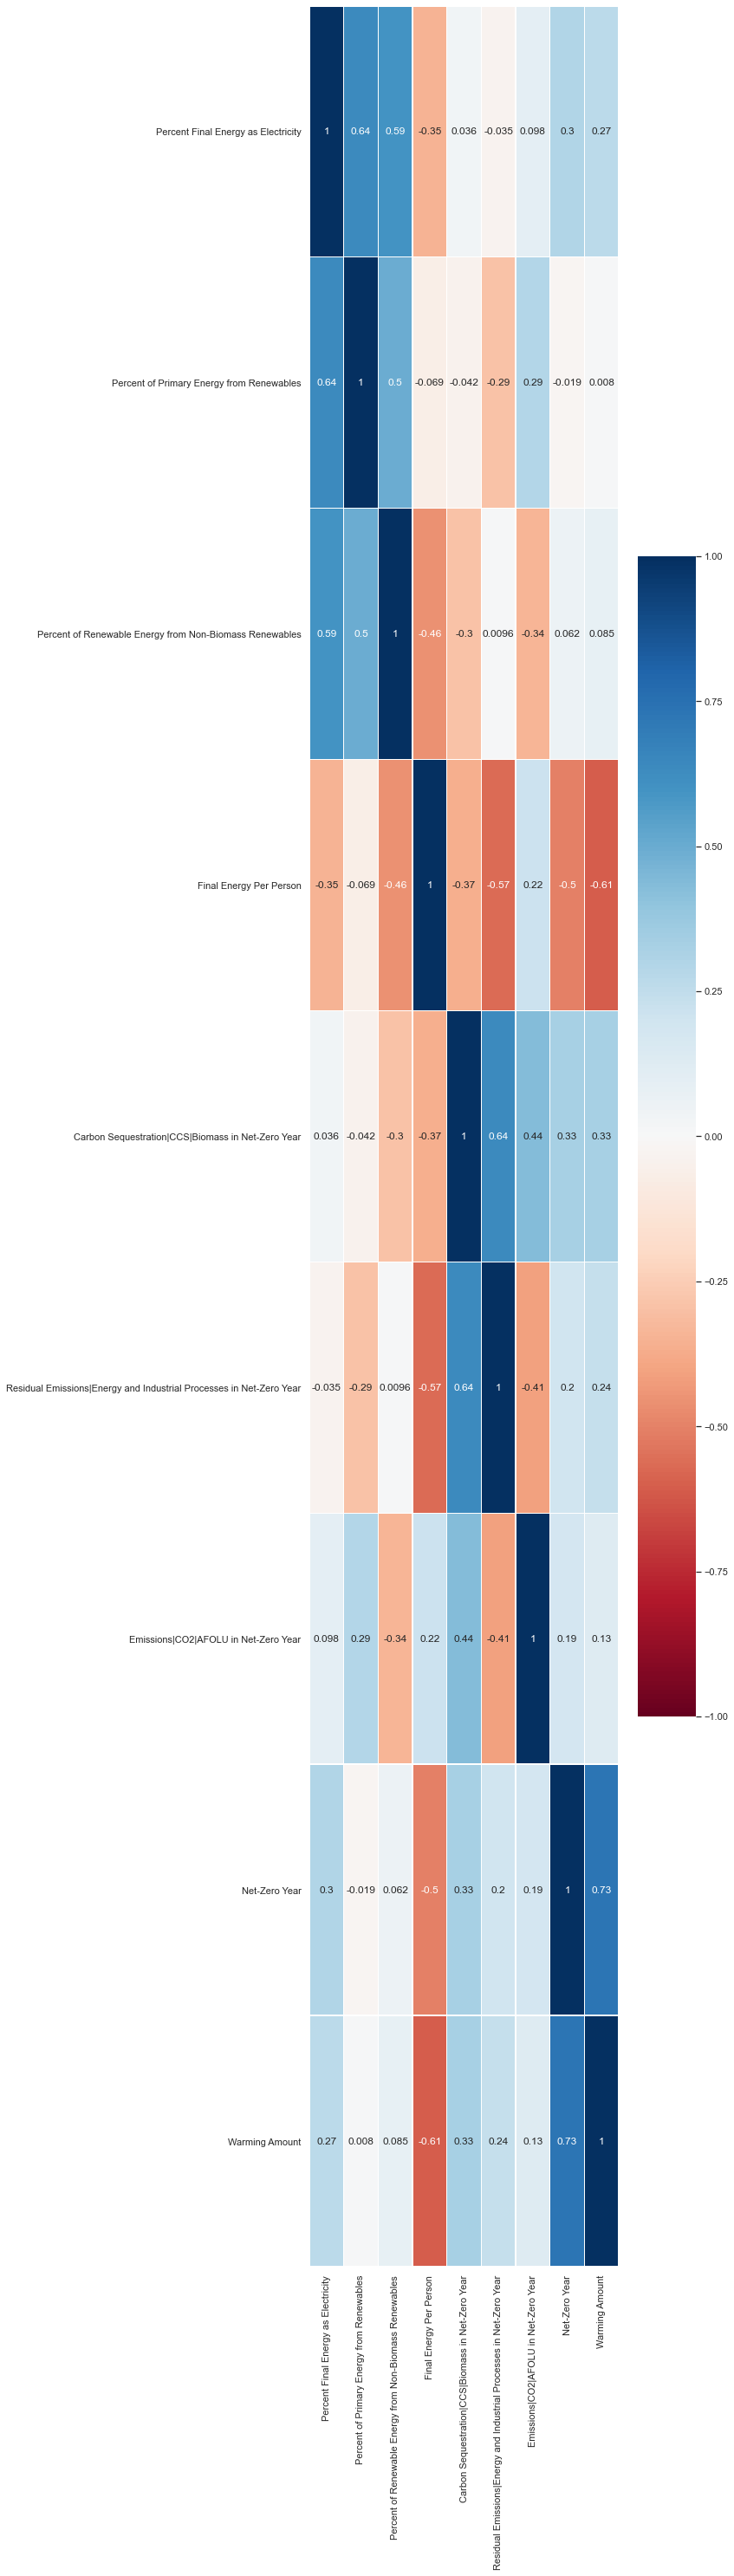

In [14]:
# making sorted tables of scenarios for selected parameters
# used to calculate correlation coefficients in main text fig. 4

from pandas.plotting import table 
from scipy import stats
from scipy.stats import zscore
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors


table_vars1 = more_vars10[['Scenario', 'Model', 'Warming', 'Net-Zero Year', 'Final Energy Per Person', 'Percent Final Energy as Electricity', \
                         'Percent of Primary Energy from Renewables', \
                         'Percent of Renewable Energy from Non-Biomass Renewables', \
                         'Carbon Sequestration|CCS|Biomass in Net-Zero Year', 'Residual Emissions|Energy and Industrial Processes in Net-Zero Year', \
                         'Emissions|CO2|AFOLU in Net-Zero Year']]
table_vars1['Scenario-Model'] = table_vars1['Scenario'].str.cat(table_vars1['Model'],sep=", ")
# print(table_vars1['Scenario-Model'])

table = table_vars1[['Scenario-Model', 'Warming', 'Net-Zero Year', 'Final Energy Per Person', 'Percent Final Energy as Electricity', \
                         'Percent of Primary Energy from Renewables', \
                         'Percent of Renewable Energy from Non-Biomass Renewables', \
                         'Carbon Sequestration|CCS|Biomass in Net-Zero Year', 'Residual Emissions|Energy and Industrial Processes in Net-Zero Year', \
                         'Emissions|CO2|AFOLU in Net-Zero Year']]

table2 = table[['Percent Final Energy as Electricity', 'Percent of Primary Energy from Renewables', 
                         'Percent of Renewable Energy from Non-Biomass Renewables', \
                         'Final Energy Per Person', \
                         'Carbon Sequestration|CCS|Biomass in Net-Zero Year', 'Residual Emissions|Energy and Industrial Processes in Net-Zero Year', \
                         'Emissions|CO2|AFOLU in Net-Zero Year', 'Net-Zero Year']].apply(zscore)

tablescen = table[['Scenario-Model']]
tablewarming = table[['Warming']]
tableplot = pd.merge(tablewarming, table2, left_index = True, right_index = True)
tableplot = pd.merge(tablescen, tableplot, left_index = True, right_index = True)

tableplot = tableplot.set_index('Scenario-Model')
tableplot['Final Energy Per Person'] = tableplot['Final Energy Per Person'] * -1

# Can sort by any column in this line
tableplot = tableplot.sort_values(by='Emissions|CO2|AFOLU in Net-Zero Year', ascending=False)
# print(tableplot)

tableplot2 = tableplot

def warmingnum(row):
    if row['Warming'] == '1.5C':
        return 1.5
    if row['Warming'] == '2C':
        return 2.0
    if row['Warming'] == '>2C':
        return 2.5
    
tableplot2['Warming Amount'] = tableplot2.apply(lambda row: warmingnum(row), axis = 1)
# print(tableplot2)

# Some stats:
print('\n')
print('Mean % Final Energy as Electricity: '+ str(more_vars10['Percent Final Energy as Electricity'].mean()) + ' %, stdv = ' + str(more_vars10['Percent Final Energy as Electricity'].std()))
print('Mean % Primary Energy from Non-Bio Renewables: '+ str(more_vars10['Percent of Renewable Energy from Non-Biomass Renewables'].mean()) + ' %, stdv = ' + str(more_vars10['Percent of Renewable Energy from Non-Biomass Renewables'].std()))
print('Mean % Primary Energy from Renewables: '+ str(more_vars10['Percent of Primary Energy from Renewables'].mean()) + ' %, stdv = ' + str(more_vars10['Percent of Primary Energy from Renewables'].std()))
print('Mean Final Energy Per Person: '+ str(more_vars10['Final Energy Per Person'].mean()*1000) + ' GJ/person, stdv = ' + str(more_vars10['Final Energy Per Person'].std()*1000))
print('Mean Carbon Sequestration|BECCS: '+ str(more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'].mean()) + ' Mt CO2, stdv = ' + str(more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'].std()))
print('Mean Net Land Use Emissions: '+ str(more_vars10['Emissions|CO2|AFOLU in Net-Zero Year'].mean()) + ' Mt CO2, stdv = ' + str(more_vars10['Emissions|CO2|AFOLU in Net-Zero Year'].std()))
print('\n')


# Plotting:
colors = ['royalblue', 'cornflowerblue', 'lightsteelblue', 'white', 'moccasin', 'orange', 'darkorange']
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
nodes = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
cmap2 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

# From StackOverflow @Mattijn:
def reverse_colormap(cmap, name = 'my_cmap_r'):
    reverse = []
    k = []   

    for key in cmap._segmentdata:    
        k.append(key)
        channel = cmap._segmentdata[key]
        data = []

        for t in channel:                    
            data.append((1-t[0],t[2],t[1]))            
        reverse.append(sorted(data))    

    LinearL = dict(zip(k,reverse))
    my_cmap_r = mpl.colors.LinearSegmentedColormap(name, LinearL) 
    return my_cmap_r
# End section from StackOverflow

cmapnew = reverse_colormap(cmap2)
# For correlation matrix, make figsize 8x8
fig, ax = plt.subplots(figsize=[8,48])
# sns.heatmap(tableplot, cmap=cmapnew, linewidths=.5, ax=ax, vmin=-4, vmax=4)

# For correlation matrix, comment out above line and uncomment below lines:
corr = tableplot.corr()
sns.heatmap(corr, annot=True, cmap='RdBu', linewidths=.5, ax=ax, vmin=-1, vmax=1)

from scipy import stats

tablevars = ['Percent Final Energy as Electricity', 'Percent of Primary Energy from Renewables', 
                         'Percent of Renewable Energy from Non-Biomass Renewables', \
                         'Final Energy Per Person', \
                         'Carbon Sequestration|CCS|Biomass in Net-Zero Year', 'Residual Emissions|Energy and Industrial Processes in Net-Zero Year', \
                         'Emissions|CO2|AFOLU in Net-Zero Year', 'Net-Zero Year', 'Warming Amount']
corr_df = pd.DataFrame(columns=['r', 'p'])

for i in range(len(tablevars)):
    for col in tableplot2:
        if pd.api.types.is_numeric_dtype(tableplot2[col]):
            r, p = stats.pearsonr(tableplot2[tablevars[i]], tableplot2[col])
            corr_df.loc[col] = [round(r,3), p]
    print(corr_df)

# plt.savefig('scenariozscore_table', bbox_inches='tight')
# plt.savefig('scenariozscore_table.pdf', bbox_inches='tight')
# plt.savefig('scenariozscore_table.eps', format='eps', bbox_inches='tight') 
 

In [22]:
# for making REGIONAL scatter plots of primary energy sources/mixes, energy demand, trajectories, and residual ems
# NOTE: must run global scatterplot cell first to get reference dataframe for global net-zero years
# from cycler import cycler # for mpl>2.2

import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
pd.options.mode.chained_assignment = None
import sys
np.set_printoptions(threshold=sys.maxsize)

scat_var = np.array(['Population', 'GDP|PPP', 'Primary Energy', 'Primary Energy|Fossil', 'Primary Energy|Nuclear', 'Primary Energy|Biomass', 'Primary Energy|Solar', 'Primary Energy|Wind', 'Final Energy'])


full_scenario_data = pd.DataFrame()
all_nz_index = pd.DataFrame()
nz_index = pd.DataFrame()
nz_index_ref = pd.DataFrame()
all_max_index = pd.DataFrame()
temp_cat_all = pd.DataFrame()
ssp_cat_all = pd.DataFrame()
reg_cat_all = pd.DataFrame()
reg_cat_supp_all = pd.DataFrame()
model_ver_all = pd.DataFrame()
full_co2_data = pd.DataFrame()
full_co2_world = pd.DataFrame()
regional_nz_co2 = pd.DataFrame()
full_residual_data1 = pd.DataFrame()
full_residual_data2 = pd.DataFrame()
full_pop_data = pd.DataFrame()
full_gdp_data = pd.DataFrame()
full_penergy_data = pd.DataFrame()
full_fossil_data = pd.DataFrame()
full_nuc_data = pd.DataFrame()
full_bio_data = pd.DataFrame()
full_ccs_bio_data = pd.DataFrame()
full_finen = pd.DataFrame()
full_finelec = pd.DataFrame()
full_invest_eff = pd.DataFrame()
full_invest_elec = pd.DataFrame()
full_traj = pd.DataFrame()
pop2 = pd.DataFrame()
pop4 = pd.DataFrame()
res21 = pd.DataFrame()
res41 = pd.DataFrame()
res22 = pd.DataFrame()
res42 = pd.DataFrame()
gdp2 = pd.DataFrame()
gdp4 = pd.DataFrame()
penergy4 = pd.DataFrame()
fossil4 = pd.DataFrame()
nuc4 = pd.DataFrame()
bio4 = pd.DataFrame()
ccs_bio2 = pd.DataFrame()
ccs_bio4 = pd.DataFrame()
finen2 = pd.DataFrame()
finen4 = pd.DataFrame()
finelec2 = pd.DataFrame()
finelec4 = pd.DataFrame()
investeff2 = pd.DataFrame()
investeff4 = pd.DataFrame()
investelec2 = pd.DataFrame()
investelec4 = pd.DataFrame()
# renewable = pd.DataFrame()
# nonbio_renewable = pd.DataFrame()
color_dict = { '1.5C':'blue', '2C':'orange', '>2C':'red' }
k = ['1.5C', '2C', '>2C']
region = ['R5ASIA', 'R5LAM', 'R5MAF', 'R5OECD90+EU', 'R5REF']

## IF JUST LOOKING AT SCENARIOS WITH INVESTMENT OUTPUTS: set inv variable below = 1, otherwise set = 0
inv=0

# Getting regional scenario data:
for j in range(len(region)):
    co2_data = filteredco2all.groupby('Variable').get_group('Emissions|CO2').groupby('Region').get_group(region[j])
    full_co2_data = pd.concat([full_co2_data, co2_data])
    co2_world = filteredco2all.groupby('Variable').get_group('Emissions|CO2').groupby('Region').get_group('World')
    full_co2_world = pd.concat([full_co2_world, co2_world])
    residual_data1 = filteredco2all.groupby('Variable').get_group('Emissions|CO2|AFOLU').groupby('Region').get_group(region[j])
    full_residual_data1 = pd.concat([full_residual_data1, residual_data1])
    residual_data2 = filteredco2all.groupby('Variable').get_group('Emissions|CO2|Energy and Industrial Processes').groupby('Region').get_group(region[j])
    full_residual_data2 = pd.concat([full_residual_data2, residual_data2])
    pop_data = filteredco2all.groupby('Variable').get_group('Population').groupby('Region').get_group(region[j])
    full_pop_data = pd.concat([full_pop_data, pop_data])
    gdp_data = filteredco2all.groupby('Variable').get_group('GDP|PPP').groupby('Region').get_group(region[j])
    full_gdp_data = pd.concat([full_gdp_data, gdp_data])
    penergy_data = filteredco2all.groupby('Variable').get_group('Primary Energy').groupby('Region').get_group(region[j])
    full_penergy_data = pd.concat([full_penergy_data, penergy_data])
    fossil_data = filteredco2all.groupby('Variable').get_group('Primary Energy|Fossil').groupby('Region').get_group(region[j])
    full_fossil_data = pd.concat([full_fossil_data, fossil_data])
    nuc_data = filteredco2all.groupby('Variable').get_group('Primary Energy|Nuclear').groupby('Region').get_group(region[j])
    full_nuc_data = pd.concat([full_nuc_data, nuc_data])
    bio_data = filteredco2all.groupby('Variable').get_group('Primary Energy|Biomass').groupby('Region').get_group(region[j])
    full_bio_data = pd.concat([full_bio_data, bio_data])
    ccs_bio_data = filteredco2all.groupby('Variable').get_group('Carbon Sequestration|CCS|Biomass').groupby('Region').get_group(region[j])
    full_ccs_bio_data = pd.concat([full_ccs_bio_data, ccs_bio_data])
    final_energy = filteredco2all.groupby('Variable').get_group('Final Energy').groupby('Region').get_group(region[j])
    full_finen = pd.concat([full_finen, final_energy])
    final_electric = filteredco2all.groupby('Variable').get_group('Final Energy|Electricity').groupby('Region').get_group(region[j])
    full_finelec = pd.concat([full_finelec, final_electric])
    if inv==1:
        invest_elec = filteredco2all.groupby('Variable').get_group('Investment|Energy Supply|Electricity|Non-fossil').groupby('Region').get_group(region[j])
        full_invest_elec = pd.concat([full_invest_elec, invest_elec])
    scenario_data = filteredco2all.groupby('Region').get_group(region[j])
    full_scenario_data = pd.concat([full_scenario_data, scenario_data])
    # print(len(full_co2_data))

# picking list of model/scenario combos to merge with individual dataframes:

# this is necessary because variables are selected by scenario, but not all model/scenario combos have all output variables
# example: getting 'Primary Energy|Biomass' from scenario 'ADVANCE_2020_1.5C-2100' will return all models that ran 'ADVANCE_2020_1.5C-2100' and have that output variable.
# example continued: if five models ran 'ADVANCE_2020_1.5C-2100' but only three have a 'Primary Energy|Biomass' output...
# example continued: ...but for 'Final Energy', all five models for 'ADVANCE_2020_1.5C-2100' have a 'Final Energy' output...
# example continued: ...then the list of model/scenarios for each variable is not the same and must be merged on the shortest list...
# example continued: ...so that only the three model/scenarios that these two varaibles have in common are assessed.

# even after the first merge, the list of model/scenarios still might not match across all variables. 
# Why? Going back to our example, considering models A-E, let's say that for 'ADVANCE_2020_1.5C-2100', models A, B, and C have 'Primary Energy|Biomass' data...
# example continued: ...but models B, C, D, and E have data for 'GDP|PPP'. After the first merge...
# example continued: ...the variables are merged on the shortest list of models (in this case, models A,B, and C)...
# example continued: ...and the variable lists only keep the rows that have models in common. So, since 'GDP\PPP' has models B and C...
# example continued: ...but not model A, then our 'GDP\PPP' list will only have B and C, while 'Primary Energy|Biomass' has A-C.
# example continued: ...so by doing one more round of selecting the shortest list of model/scenarios and merging all variables with that list...
# example continued: ...we guarantee that the model/scenarios will match across all variables.
# example continued: For our example, we would then select the model/scenario list from 'GDP|PPP' since it is the shortest...
# example continued: ...and merge that list with 'Primary Energy|Biomass' so that the final 'Primary Energy|Biomass' list only has common model/scenarios with 'GDP|PPP' ('ADVANCE_2020_1.5C-2100, model B' and 'ADVANCE_2020_1.5C-2100, model C')

# So, we need to keep merging on the shortest model/scenario list for each iteration until all model/scenarios match (until length of new shortest list is the same as the length of the previous shortest list):

j=0
while j==0 or j > len(model_scenario_listvar):
# for i in range(0,13):
    varlist = [full_co2_data, full_residual_data1, full_residual_data2, full_pop_data, full_gdp_data, full_penergy_data, \
               full_fossil_data, full_nuc_data, full_bio_data, full_ccs_bio_data, full_finen, full_finelec] # , full_invest_elec
    # print(varlist[0])
    if inv==1:
        varlist = [full_co2_data, full_residual_data1, full_residual_data2, full_pop_data, full_gdp_data, full_penergy_data, \
               full_fossil_data, full_nuc_data, full_bio_data, full_ccs_bio_data, full_finen, full_finelec, full_invest_elec]
    # print(varlist[0])
    if j==0:
        hold = ['1'] * len(varlist)
        model_scenario_listvar = varlist[0]
    for i in range(len(varlist)):
        # print(i)
        if i==0 or len(varlist[i]) < len(model_scenario_listvar):
            hold[i] = model_scenario_listvar
            j=len(hold[i])
            model_scenario_listvar = varlist[i]
    # print(len(model_scenario_listvar))
    # print(model_scenario_listvar)
    # print(j)

    nz_models_reg1 = model_scenario_listvar['Model']
    nz_models_reg = nz_models_reg1.reset_index(drop=True)
    # print(nz_models_all)

    nz_scenarios_reg1 = model_scenario_listvar['Scenario']
    nz_scenarios_reg = nz_scenarios_reg1.reset_index(drop=True)
    # print(full_scenario_data)

    nz_regions_reg1 = model_scenario_listvar['Region']
    nz_regions_reg = nz_regions_reg1.reset_index(drop=True)

    nz_temp_reg1 = model_scenario_listvar['Temp']
    nz_temp_reg = nz_temp_reg1.reset_index(drop=True)

    nz_ssp_reg1 = model_scenario_listvar['SSP']
    nz_ssp_reg = nz_ssp_reg1.reset_index(drop=True)

    nz_combo_reg = nz_models_reg.to_frame('Model').join(nz_scenarios_reg.to_frame('Scenario'), how='outer')
    nz_combo_reg['Region'] = nz_regions_reg
    nz_combo_reg['Temp'] = nz_temp_reg
    nz_combo_reg['SSP'] = nz_ssp_reg

    # merging with the global scenarios so only scenarios that reach net-zero globally are included in the regional plots 
    nz_combo_reg1 = nz_combo_reg.merge(nz_combo_world, on = ['Scenario','Model'], how = 'inner')
    nz_combo_reg2 = nz_combo_reg1.sort_values(by=['Region','Scenario','Model'], ascending=True)
    nz_combo_reg3 = nz_combo_reg2.reset_index(drop=True)
    nz_combo_reg = nz_combo_reg3
    # print(len(nz_combo_reg))
    
    # removing rows where the scenario does not have outputs for all 5 regions:
    filtered_reg_list = pd.DataFrame()
    reg_scenarios_hold1 = nz_combo_reg['Scenario']
    reg_scenarios_hold2 = np.unique(reg_scenarios_hold1)
    for i in range(len(reg_scenarios_hold2)):
        reg_scenarios_hold1 = model_scenario_listvar.groupby('Scenario').get_group(reg_scenarios_hold2[i])
        reg_scenarios_hold = reg_scenarios_hold1[['Model','Scenario','Region','Temp','SSP']]
        # print(reg_scenarios_hold3)
        if len(reg_scenarios_hold) >= 5:
            filtered_reg_list = pd.concat([filtered_reg_list,reg_scenarios_hold])
            filtered_reg_list = filtered_reg_list.sort_values(by=['Region','Scenario','Model'], ascending=True)
    # print(len(filtered_reg_list))
    nz_combo_reg1 = nz_combo_reg.merge(filtered_reg_list, on = ['Region','Scenario','Model','Temp','SSP'], how = 'inner')
    nz_combo_reg2 = nz_combo_reg1.sort_values(by=['Region','Scenario','Model'], ascending=True)
    nz_combo_reg3 = nz_combo_reg2.reset_index(drop=True)
    nz_combo_reg = nz_combo_reg3
    # print(len(nz_combo_reg))

    # Ensuring that model-scenario combos in new dataframes match the nz_combo_reg reference dataframes (both name and order)
    # Data frames used to plot were also cross-checked for accuracy against original data spreadsheet
    # NOTE: the 'sort_values' lines are super important for model-scenarios and net-zero years to match...if you add another variable to plot, you MUST also add this line after the merge line!
    full_co2_data = full_co2_data.merge(nz_combo_reg, on = ['Region','Scenario','Model','Temp','SSP'], how = 'inner')
    full_co2_data = full_co2_data.sort_values(by=['Region','Scenario','Model'], ascending=True)
    full_residual_data1 = full_residual_data1.merge(nz_combo_reg, on = ['Region','Scenario','Model','Temp','SSP'], how = 'inner')
    full_residual_data1 = full_residual_data1.sort_values(by=['Region','Scenario','Model'], ascending=True)
    full_residual_data2 = full_residual_data2.merge(nz_combo_reg, on = ['Region','Scenario','Model','Temp','SSP'], how = 'inner')
    full_residual_data2 = full_residual_data2.sort_values(by=['Region','Scenario','Model'], ascending=True)
    full_pop_data = full_pop_data.merge(nz_combo_reg, on = ['Region','Scenario','Model','Temp','SSP'], how = 'inner')
    full_pop_data = full_pop_data.sort_values(by=['Region','Scenario','Model'], ascending=True)
    full_gdp_data = full_gdp_data.merge(nz_combo_reg, on = ['Region','Scenario','Model','Temp','SSP'], how = 'inner')
    full_gdp_data = full_gdp_data.sort_values(by=['Region','Scenario','Model'], ascending=True)
    full_penergy_data = full_penergy_data.merge(nz_combo_reg, on = ['Region','Scenario','Model','Temp','SSP'], how = 'inner')
    full_penergy_data = full_penergy_data.sort_values(by=['Region','Scenario','Model'], ascending=True)
    full_fossil_data = full_fossil_data.merge(nz_combo_reg, on = ['Region','Scenario','Model','Temp','SSP'], how = 'inner')
    full_fossil_data = full_fossil_data.sort_values(by=['Region','Scenario','Model'], ascending=True)
    full_nuc_data = full_nuc_data.merge(nz_combo_reg, on = ['Region','Scenario','Model','Temp','SSP'], how = 'inner')
    full_nuc_data = full_nuc_data.sort_values(by=['Region','Scenario','Model'], ascending=True)
    full_bio_data = full_bio_data.merge(nz_combo_reg, on = ['Region','Scenario','Model','Temp','SSP'], how = 'inner')
    full_bio_data = full_bio_data.sort_values(by=['Region','Scenario','Model'], ascending=True)
    full_ccs_bio_data = full_ccs_bio_data.merge(nz_combo_reg, on = ['Region','Scenario','Model','Temp','SSP'], how = 'inner')
    full_ccs_bio_data = full_ccs_bio_data.sort_values(by=['Region','Scenario','Model'], ascending=True)
    full_finen = full_finen.merge(nz_combo_reg, on = ['Region','Scenario','Model','Temp','SSP'], how = 'inner')
    full_finen = full_finen.sort_values(by=['Region','Scenario','Model'], ascending=True)
    full_finelec = full_finelec.merge(nz_combo_reg, on = ['Region','Scenario','Model','Temp','SSP'], how = 'inner')
    full_finelec = full_finelec.sort_values(by=['Region','Scenario','Model'], ascending=True)
    if inv==1:
        full_invest_elec = full_invest_elec.merge(nz_combo_reg, on = ['Region','Scenario','Model','Temp','SSP'], how = 'inner')
        full_invest_elec = full_invest_elec.sort_values(by=['Region','Scenario','Model'], ascending=True)
    # print(full_finelec)
    # print('loop')

# print(full_co2_data[['Model','Scenario','Region']])
# print(full_penergy_data[['Model','Scenario','Region']])

nz_models_reg = nz_combo_reg['Model']
# print(len(nz_models_reg))
nz_scenarios_reg = nz_combo_reg['Scenario']
# print(len(nz_scenarios_reg))
nz_regions_reg = nz_combo_reg['Region']
# print(len(nz_regions_reg))
nz_temp_reg = nz_combo_reg['Temp']
# print(len(nz_temp_reg))
nz_ssp_reg = nz_combo_reg['SSP']
# print(len(nz_ssp_reg))
# print(nz_combo_reg)


# now that the model/sceanrio/region lists match exactly for each variable...
# getting the global net-zero year and max emissions yearfor each regional model/scenario

nz_index_ref = pd.DataFrame()

def worldnzyear(row):
    model = row['Model']
    scenario = row['Scenario']
    meta = more_vars51.loc[(more_vars51['Scenario'] == scenario) & (more_vars51['Model'] == model)]
    nz_year = meta['Net-Zero Year'].values
    # print(type(nz_year))
    # print(nz_year)
    return str(nz_year).strip('[]')
    
nz_index_ref['Net-Zero Year'] = full_co2_data.apply(lambda row: worldnzyear(row), axis = 1)
# print(nz_index_ref)

def worldmaxyear(row):
    model = row['Model']
    scenario = row['Scenario']
    meta = more_vars51.loc[(more_vars51['Scenario'] == scenario) & (more_vars51['Model'] == model)]
    max_year = meta['Max Emissions Year'].values
    # print(type(max_year))
    # print(max_year)
    return str(max_year).strip('[]')
    
all_max_index['World Max Emissions Year'] = full_co2_data.apply(lambda row: worldmaxyear(row), axis = 1)

# Assigning each regional scenario a number to match up with net-zero year
full_co2_data['traj number'] = np.arange(len(full_co2_data))
full_residual_data1['traj number'] = np.arange(len(full_residual_data1))
full_residual_data2['traj number'] = np.arange(len(full_residual_data2))
full_pop_data['traj number'] = np.arange(len(full_pop_data))
full_gdp_data['traj number'] = np.arange(len(full_gdp_data))
full_penergy_data['traj number'] = np.arange(len(full_penergy_data))
full_fossil_data['traj number'] = np.arange(len(full_fossil_data))
full_nuc_data['traj number'] = np.arange(len(full_nuc_data))
full_bio_data['traj number'] = np.arange(len(full_bio_data))
full_ccs_bio_data['traj number'] = np.arange(len(full_ccs_bio_data))
full_finen['traj number'] = np.arange(len(full_finen))
full_finelec['traj number'] = np.arange(len(full_finelec))
if inv==1:
    full_invest_elec['traj number'] = np.arange(len(full_invest_elec))
# print(len(full_co2_data))    

# Reformatting to get final list of net-zero years
nz_index_ref2 = pd.DataFrame(nz_index_ref)
# all_nz_index3 = all_nz_index2.rename(columns={'0': 'Net-Zero Year'})
# print(all_nz_index2)
full_nz_ref = nz_index_ref2.reset_index(drop=True)
full_nz_ref.columns = ['Net-Zero Year']
full_nz_ref2 = full_nz_ref.transpose()
nz_ref = full_nz_ref2.to_numpy()
nz_years_hold = list(nz_ref)
nz_years = np.array(nz_years_hold, dtype=object).ravel()
# print(nz_years)

all_max_index2 = pd.DataFrame(all_max_index)
full_max_index = all_max_index2.reset_index(drop=True)
full_max_index.columns = ['Max Emissions Year']
full_max_index['Max Emissions Year'] = full_max_index['Max Emissions Year'].astype(int)
# print(len(full_max_index))
    
temp_cat_all2 = pd.DataFrame(nz_temp_reg)
full_temp_cat = temp_cat_all2.reset_index(drop=True)
full_temp_cat.columns = ['Warming']
# print(len(full_temp_cat))

ssp_cat_all2 = pd.DataFrame(nz_ssp_reg)
full_ssp_cat = ssp_cat_all2.reset_index(drop=True)
full_ssp_cat.columns = ['SSP Group']
# print(full_ssp_cat)
                                                            
reg_cat_all2 = pd.DataFrame(nz_regions_reg)
full_reg_cat = reg_cat_all2.reset_index(drop=True)
full_reg_cat.columns = ['Region']
# print(len(full_reg_cat))                                                            

 
# Getting net-zero year data for variables and re-naming columns
# NOTE: in order for these loops to grab the correct net-zero year for each model-scenario combo, the regional dataframe and global dataframe must both be sorted by region, THEN scenario, THEN model. 
# this is already done in the code above, but any changes/additions to the dataframe should be sorted in that same order. 

for i in range(len(full_pop_data)):
    pop1 = full_pop_data.groupby('traj number').get_group(i)[nz_years[i]]
    # print(pop1)
    pop2 = pd.DataFrame(pop1)
    pop3 = pop2.rename(columns={nz_years[i]: 'Population in Net-Zero Year'})
    pop4 = pd.concat([pop4, pop3])
    pop = pop4.reset_index(drop=True)
# print(len(pop))

pop_base = full_pop_data['2010']
pop_base = pd.DataFrame(pop_base)
pop_base = pop_base.rename(columns={'2010':'Population in 2010'})
pop_base = pop_base.reset_index(drop=True)

for i in range(len(full_residual_data1)):
    res11 = full_residual_data1.groupby('traj number').get_group(i)[nz_years[i]]
    # print(pop1)
    res21 = pd.DataFrame(res11)
    res31 = res21.rename(columns={nz_years[i]: 'Emissions|CO2|AFOLU in Net-Zero Year'})
    res41 = pd.concat([res41, res31])
    res1 = res41.reset_index(drop=True)
# print(len(res1))

for i in range(len(full_residual_data2)):
    res12 = full_residual_data2.groupby('traj number').get_group(i)[nz_years[i]]
    # print(pop1)
    res22 = pd.DataFrame(res12)
    res32 = res22.rename(columns={nz_years[i]: 'Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'})
    res42 = pd.concat([res42, res32])
    res2 = res42.reset_index(drop=True)
# print(len(res2))

for i in range(len(full_gdp_data)):
    gdp1 = full_gdp_data.groupby('traj number').get_group(i)[nz_years[i]]
    # print(gdp1)
    gdp2 = pd.DataFrame(gdp1)
    gdp3 = gdp2.rename(columns={nz_years[i]: 'GDP|PPP in Net-Zero Year'})
    gdp4 = pd.concat([gdp4, gdp3])
    gdp = gdp4.reset_index(drop=True)
# print(len(gdp))

for i in range(len(full_penergy_data)):
    # print(nz_years[i])
    penergy1 = full_penergy_data.groupby('traj number').get_group(i)[nz_years[i]]
    penergy2 = pd.DataFrame(penergy1)
    penergy3 = penergy2.rename(columns={nz_years[i]: 'Primary Energy in Net-Zero Year'})
    penergy4 = pd.concat([penergy4, penergy3])
    penergy = penergy4.reset_index(drop=True)
# print(len(penergy))

for i in range(len(full_fossil_data)):
    fossil1 = full_fossil_data.groupby('traj number').get_group(i)[nz_years[i]]
    fossil2 = pd.DataFrame(fossil1)
    fossil3 = fossil2.rename(columns={nz_years[i]: 'Primary Energy|Fossil in Net-Zero Year'})
    fossil4 = pd.concat([fossil4, fossil3])
    fossil = fossil4.reset_index(drop=True)
# print(len(fossil))

for i in range(len(full_nuc_data)):
    nuc1 = full_nuc_data.groupby('traj number').get_group(i)[nz_years[i]]
    nuc2 = pd.DataFrame(nuc1)
    nuc3 = nuc2.rename(columns={nz_years[i]: 'Primary Energy|Nuclear in Net-Zero Year'})
    nuc4 = pd.concat([nuc4, nuc3])
    nuc = nuc4.reset_index(drop=True)
# print(len(nuc))

for i in range(len(full_bio_data)):
    bio1 = full_bio_data.groupby('traj number').get_group(i)[nz_years[i]]
    bio2 = pd.DataFrame(bio1)
    bio3 = bio2.rename(columns={nz_years[i]: 'Primary Energy|Biomass in Net-Zero Year'})
    bio4 = pd.concat([bio4, bio3])
    bio = bio4.reset_index(drop=True)
# print(len(bio))

for i in range(len(full_ccs_bio_data)):
    ccs_bio1 = full_ccs_bio_data.groupby('traj number').get_group(i)[nz_years[i]]
    ccs_bio2 = pd.DataFrame(ccs_bio1)
    ccs_bio3 = ccs_bio2.rename(columns={nz_years[i]: 'Carbon Sequestration|CCS|Biomass in Net-Zero Year'})
    ccs_bio4 = pd.concat([ccs_bio4, ccs_bio3])
    ccs_bio = ccs_bio4.reset_index(drop=True)
# print(len(ccs_bio))

for i in range(len(full_finen)):
    finen1 = full_finen.groupby('traj number').get_group(i)[nz_years[i]]
    finen2 = pd.DataFrame(finen1)
    finen3 = finen2.rename(columns={nz_years[i]: 'Final Energy in Net-Zero Year'})
    finen4 = pd.concat([finen4, finen3])
    finen = finen4.reset_index(drop=True)
# print(len(finen))

finen_base = full_finen['2010']
finen_base = pd.DataFrame(finen_base)
finen_base = finen_base.rename(columns={'2010':'Final Energy in 2010'})
finen_base = finen_base.reset_index(drop=True)

for i in range(len(full_finelec)):
    finelec1 = full_finelec.groupby('traj number').get_group(i)[nz_years[i]]
    finelec2 = pd.DataFrame(finelec1)
    finelec3 = finelec2.rename(columns={nz_years[i]: 'Final Energy|Electricity in Net-Zero Year'})
    finelec4 = pd.concat([finelec4, finelec3])
    finelec = finelec4.reset_index(drop=True)
# print(len(finelec))

if inv==1:
    for i in range(len(full_invest_elec)):
        investelec1 = full_invest_elec.groupby('traj number').get_group(i)
        investelec2 = pd.DataFrame(investelec1)
        # print(investelec2)
        cols = investelec2.columns
        inv_nz_index = cols.get_loc(nz_years[i])
        investelec_cols = investelec2.iloc[:,0:inv_nz_index]
        # print(investelec_cols)
        investelec_cumulative = investelec_cols.sum(axis=1)
        investelec3 = pd.DataFrame(investelec_cumulative)
        investelec3.columns = ['Cumulative Investment|Energy Supply|Electricity|Non-fossil up to Net-Zero Year']
        investelec4 = pd.concat([investelec4, investelec3])
        investelec = investelec4.reset_index(drop=True)
    # print(investelec)
    # print(len(full_invest_elec))
    # print(len(investelec))
    investelec['Model'] = full_invest_elec['Model']
    investelec['Scenario'] = full_invest_elec['Scenario']
    investelec['Region'] = full_invest_elec['Region']
    # print(investelec.loc[0])


# Making dataframes for plotting
some_vars = pd.merge(nz_scenarios_reg, nz_models_reg, left_index = True, right_index = True)
some_vars2 = pd.merge(some_vars, gdp, left_index = True, right_index = True)
demand_vars = pd.merge(some_vars2, pop, left_index = True, right_index = True)
more_vars = pd.merge(demand_vars, pop_base, left_index = True, right_index = True)
more_vars = pd.merge(more_vars, penergy, left_index = True, right_index = True)
more_vars2 = pd.merge(more_vars, fossil, left_index = True, right_index = True)
more_vars3 = pd.merge(more_vars2, nuc, left_index = True, right_index = True)
more_vars4 = pd.merge(more_vars3, bio, left_index = True, right_index = True)
more_vars5 = pd.merge(more_vars4, full_nz_ref, left_index = True, right_index = True)
more_vars6 = pd.merge(more_vars5, full_max_index, left_index = True, right_index = True)
more_vars7 = pd.merge(more_vars6, full_temp_cat, left_index = True, right_index = True)
more_vars8 = pd.merge(more_vars7, res1, left_index = True, right_index = True)
more_vars9 = pd.merge(more_vars8, res2, left_index = True, right_index = True)
more_vars10 = pd.merge(more_vars9, full_ssp_cat, left_index = True, right_index = True)
more_vars10 = pd.merge(more_vars10, full_reg_cat, left_index = True, right_index = True)
more_vars10 = pd.merge(more_vars10, ccs_bio, left_index = True, right_index = True)
more_vars10 = pd.merge(more_vars10, finen, left_index = True, right_index = True)
more_vars10 = pd.merge(more_vars10, finen_base, left_index = True, right_index = True)
more_vars10 = pd.merge(more_vars10, finelec, left_index = True, right_index = True)
if inv==1:
    more_vars10 = pd.merge(more_vars10, investelec, on = ['Model','Scenario','Region'], how = 'inner')
# more_vars_supp = pd.merge(full_reg_cat_supp, investelec, left_index = True, right_index = True)
# more_vars_supp = pd.merge(more_vars_supp, finen, left_index = True, right_index = True)

# Function to cross-check regional more_vars10 plotting dataframe against original dataframe (filteredco2all) to make sure that data was sorted and compiled correctly for net-zero year
def datacheck(row):
    model = row['Model']
    scenario = row['Scenario']
    region = row['Region']
    netzero_year = str(row['Net-Zero Year'])
    meta1 = filteredco2all.loc[(filteredco2all['Region'] == region) & (filteredco2all['Scenario'] == scenario) & (filteredco2all['Model'] == model)]
    meta = meta1.groupby('Variable').get_group('Primary Energy')[netzero_year].values
    # meta = meta.ravel()
    plot_data = row['Primary Energy in Net-Zero Year']
    # print(type(nz_year))
    print(model)
    print(scenario)
    print(region)
    print(netzero_year)
    print(plot_data)
    print(meta)
    if plot_data == meta:
        print('Data imported correctly.')
    else:
        print('WARNING: Data in plotting dataframe does not match original dataframe for each model/scenario.')  

# Uncomment lines below to check against original file that plotting dataframe was compiled correctly
# more_vars10.apply(lambda row: datacheck(row), axis = 1)
# print('\nData checks complete.') 


# adding some more columns/calculations
more_vars10['Primary Energy|Non-Biomass Renewables in Net-Zero Year'] = more_vars10['Primary Energy in Net-Zero Year'] - \
                                            more_vars10['Primary Energy|Fossil in Net-Zero Year'] - \
                                            more_vars10['Primary Energy|Nuclear in Net-Zero Year'] - \
                                            more_vars10['Primary Energy|Biomass in Net-Zero Year']
more_vars10['Primary Energy|Renewables in Net-Zero Year'] = more_vars10['Primary Energy in Net-Zero Year'] - \
                                            more_vars10['Primary Energy|Fossil in Net-Zero Year'] - \
                                            more_vars10['Primary Energy|Nuclear in Net-Zero Year']
more_vars10['Ratio Non-Biomass Renewables:Biomass'] = more_vars10['Primary Energy|Non-Biomass Renewables in Net-Zero Year'] / \
                                                more_vars10['Primary Energy|Biomass in Net-Zero Year']
more_vars10['Relative Ratio Non-Biomass:Biomass Renewables'] = more_vars10['Ratio Non-Biomass Renewables:Biomass'].apply(lambda x: (-1/x) if 0 < x < 1 else x)
more_vars10['Ratio Nuclear:Fossil'] = more_vars10['Primary Energy|Nuclear in Net-Zero Year'] / \
                                  more_vars10['Primary Energy|Fossil in Net-Zero Year']
more_vars10['Relative Ratio Nuclear:Fossil'] = more_vars10['Ratio Nuclear:Fossil'].apply(lambda x: (-1/x) if 0 < x < 1 else x)
more_vars10['Ratio Renewables:Fossil'] = (more_vars9['Primary Energy|Biomass in Net-Zero Year'] + \
                                  more_vars10['Primary Energy|Non-Biomass Renewables in Net-Zero Year']) / \
                                  more_vars10['Primary Energy|Fossil in Net-Zero Year']
more_vars10['Relative Ratio Renewables:Fossil'] = more_vars10['Ratio Renewables:Fossil'].apply(lambda x: (-1/x) if 0 < x < 1 else x)


more_vars10['Residual Emissions in Net-Zero Year'] = more_vars10[['Emissions|CO2|AFOLU in Net-Zero Year','Emissions|CO2|Energy and Industrial Processes in Net-Zero Year']].max(axis=1)
more_vars10['Residual Emissions|Energy and Industrial Processes in Net-Zero Year'] = more_vars10[['Emissions|CO2|AFOLU in Net-Zero Year','Emissions|CO2|Energy and Industrial Processes in Net-Zero Year']].max(axis=1)
more_vars10['Residual Emissions|AFOLU in Net-Zero Year'] = more_vars10[['Emissions|CO2|AFOLU in Net-Zero Year','Emissions|CO2|Energy and Industrial Processes in Net-Zero Year']].max(axis=1)
more_vars10['Negative Emissions|BECCS'] = more_vars10[['Emissions|CO2|AFOLU in Net-Zero Year','Emissions|CO2|Energy and Industrial Processes in Net-Zero Year']].max(axis=1)
more_vars10['Negative Emissions|AFOLU'] = more_vars10[['Emissions|CO2|AFOLU in Net-Zero Year','Emissions|CO2|Energy and Industrial Processes in Net-Zero Year']].max(axis=1)
more_vars10['Negative Emissions in Net-Zero Year'] = more_vars10[['Emissions|CO2|AFOLU in Net-Zero Year','Emissions|CO2|Energy and Industrial Processes in Net-Zero Year']].max(axis=1)
for i in range(len(more_vars10)):
    if more_vars10['Emissions|CO2|AFOLU in Net-Zero Year'][i] < more_vars10['Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'][i]:
        more_vars10['Residual Emissions in Net-Zero Year'][i] = more_vars10['Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'][i] \
        + more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'][i]
        more_vars10['Residual Emissions|Energy and Industrial Processes in Net-Zero Year'][i] = more_vars10['Residual Emissions in Net-Zero Year'][i]
        more_vars10['Residual Emissions|AFOLU in Net-Zero Year'][i] = 0
        more_vars10['Negative Emissions|BECCS'][i] = -1 * more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'][i]
        more_vars10['Negative Emissions|AFOLU'][i] = more_vars10['Emissions|CO2|AFOLU in Net-Zero Year'][i]
        more_vars10['Negative Emissions in Net-Zero Year'][i] = more_vars10['Negative Emissions|BECCS'][i] + more_vars10['Negative Emissions|AFOLU'][i]
    elif more_vars10['Emissions|CO2|AFOLU in Net-Zero Year'][i] > more_vars10['Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'][i]: 
        more_vars10['Residual Emissions in Net-Zero Year'][i] = more_vars10['Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'][i] \
        + more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'][i] + more_vars10['Emissions|CO2|AFOLU in Net-Zero Year'][i]
        more_vars10['Residual Emissions|Energy and Industrial Processes in Net-Zero Year'][i] = more_vars10['Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'][i] \
        + more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'][i]
        more_vars10['Residual Emissions|AFOLU in Net-Zero Year'][i] = more_vars10['Emissions|CO2|AFOLU in Net-Zero Year'][i]
        more_vars10['Negative Emissions|BECCS'][i] = -1 * more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'][i]
        more_vars10['Negative Emissions|AFOLU'][i] = 0
        more_vars10['Negative Emissions in Net-Zero Year'][i] = more_vars10['Negative Emissions|BECCS'][i]
more_vars10['Residual Emissions in Net-Zero Year'] = more_vars10['Residual Emissions in Net-Zero Year'].mask(more_vars10['Residual Emissions in Net-Zero Year'].lt(0),0)

more_vars10['Ratio Residual Emissions:Primary Energy'] = more_vars10['Residual Emissions in Net-Zero Year'] / \
                                                    more_vars10['Primary Energy in Net-Zero Year']
more_vars10['Ratio Primary Energy:GDP'] = more_vars10['Primary Energy in Net-Zero Year'] / \
                                    more_vars10['GDP|PPP in Net-Zero Year']
more_vars10['Per Capita GDP in Net-Zero Year'] = more_vars10['GDP|PPP in Net-Zero Year'] / \
                                    more_vars10['Population in Net-Zero Year']
more_vars10['Per Capita Emissions|CO2 in Net-Zero Year'] = (more_vars10['Emissions|CO2|AFOLU in Net-Zero Year'] + \
                                    more_vars10['Emissions|CO2|Energy and Industrial Processes in Net-Zero Year']) / \
                                    more_vars10['Population in Net-Zero Year']
more_vars10['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'] = \
                                    (more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'] + \
                                    more_vars10['Emissions|CO2|Energy and Industrial Processes in Net-Zero Year']) / \
                                    more_vars10['Population in Net-Zero Year']
more_vars10['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'] = \
                                    more_vars10['Carbon Sequestration|CCS|Biomass in Net-Zero Year'] / \
                                    more_vars10['Population in Net-Zero Year']                                                          
more_vars10['Percent of Primary Energy from Nuclear'] = (more_vars10['Primary Energy|Nuclear in Net-Zero Year'] / \
                                    more_vars10['Primary Energy in Net-Zero Year']) * 100
more_vars10['Percent of Primary Energy from Fossil'] = (more_vars10['Primary Energy|Fossil in Net-Zero Year'] / \
                                    more_vars10['Primary Energy in Net-Zero Year']) * 100
more_vars10['Percent of Primary Energy from Renewables'] = (more_vars10['Primary Energy|Renewables in Net-Zero Year'] / \
                                    more_vars10['Primary Energy in Net-Zero Year']) * 100
more_vars10['Percent of Renewable Energy from Biomass'] = (more_vars10['Primary Energy|Biomass in Net-Zero Year'] / \
                                    more_vars10['Primary Energy|Renewables in Net-Zero Year']) * 100
more_vars10['Percent of Renewable Energy from Non-Biomass Renewables'] = (more_vars10['Primary Energy|Non-Biomass Renewables in Net-Zero Year'] / \
                                    more_vars10['Primary Energy|Renewables in Net-Zero Year']) * 100
more_vars10['Percent Primary Energy to Final Energy'] = (more_vars10['Final Energy in Net-Zero Year'] / \
                                    more_vars10['Primary Energy in Net-Zero Year']) * 100
more_vars10['Percent Final Energy as Electricity'] = (more_vars10['Final Energy|Electricity in Net-Zero Year'] / \
                                    more_vars10['Final Energy in Net-Zero Year']) * 100
more_vars10['Primary Energy Per Person'] = more_vars10['Primary Energy in Net-Zero Year'] / \
                                    more_vars10['Population in Net-Zero Year']
more_vars10['Final Energy Per Person'] = more_vars10['Final Energy in Net-Zero Year'] / \
                                    more_vars10['Population in Net-Zero Year'] * 1000
more_vars10['Final Energy Per Person in 2010'] = more_vars10['Final Energy in 2010'] / \
                                    more_vars10['Population in 2010'] * 1000

more_vars10 = more_vars10.fillna(0)

Number of regional 1.5C net-zero pathways with all outputs: 346
Number of regional 2C net-zero pathways with all outputs: 383
Number of regional >2C net-zero pathways with all outputs: 95
160
160
172
160
172
F_onewayResult(statistic=191.11507133272036, pvalue=1.1189543129141616e-115)
F_onewayResult(statistic=844.292465698107, pvalue=8.926867177927103e-289)




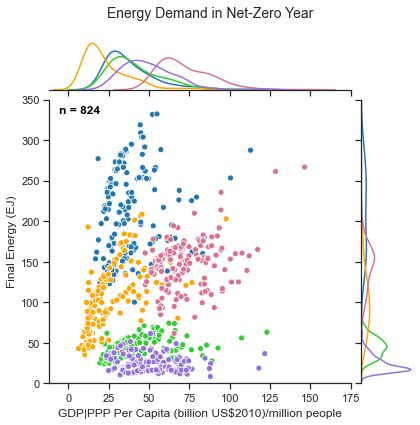

F_onewayResult(statistic=191.11507133272036, pvalue=1.1189543129141616e-115)
F_onewayResult(statistic=424.1268634758632, pvalue=7.521852816827279e-198)




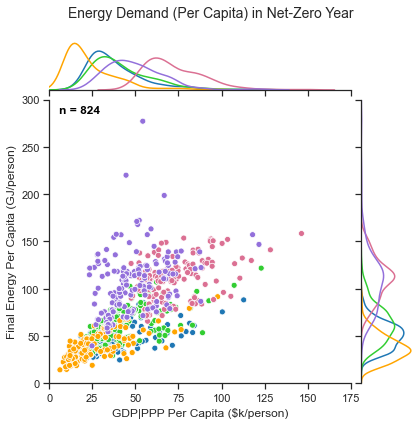



Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year
F_onewayResult(statistic=141.5711334871596, pvalue=5.7000606394665315e-92)


Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year
F_onewayResult(statistic=70.73218908704516, pvalue=1.7938295455435814e-51)




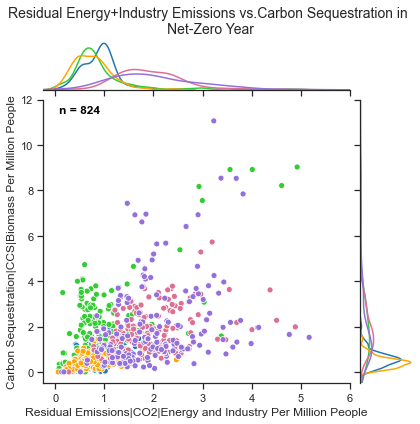

F_onewayResult(statistic=46.342527709716286, pvalue=3.966096315129476e-35)
F_onewayResult(statistic=22.644631363889953, pvalue=9.239679217746126e-18)




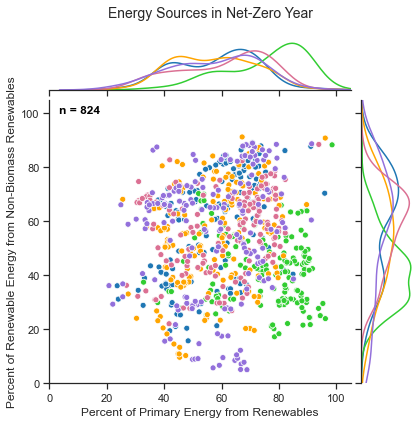

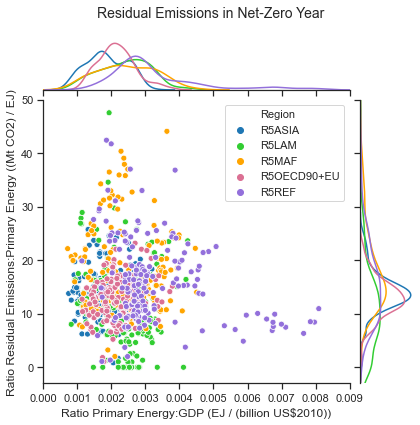

F_onewayResult(statistic=424.1268634758632, pvalue=7.521852816827279e-198)
F_onewayResult(statistic=28.049043569191564, pvalue=7.401134786668008e-22)




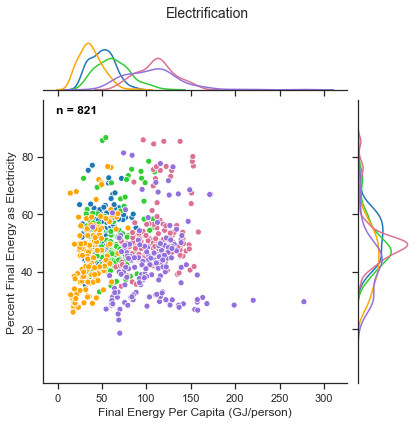

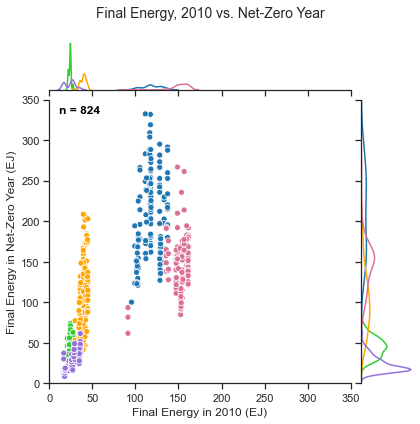

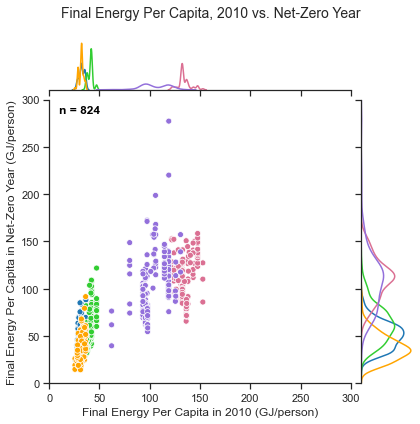

In [16]:
# Getting summary data
# print(len(more_vars10))
group1p5 = more_vars10.groupby('Warming').get_group('1.5C')
print('Number of regional 1.5C net-zero pathways with all outputs: ' + str(len(group1p5)))
group2 = more_vars10.groupby('Warming').get_group('2C')
print('Number of regional 2C net-zero pathways with all outputs: ' + str(len(group2)))
group2plus = more_vars10.groupby('Warming').get_group('>2C')
print('Number of regional >2C net-zero pathways with all outputs: ' + str(len(group2plus)))

groupASIA = more_vars10.groupby('Region').get_group('R5ASIA')
print(len(groupASIA))
groupLAM = more_vars10.groupby('Region').get_group('R5LAM')
print(len(groupLAM))
groupMAF = more_vars10.groupby('Region').get_group('R5MAF')
print(len(groupMAF))
groupOECDEU = more_vars10.groupby('Region').get_group('R5OECD90+EU')
print(len(groupOECDEU))
groupREF = more_vars10.groupby('Region').get_group('R5REF')
print(len(groupREF))

regional_scenarios_stats = pd.DataFrame()
more_vars10['Model-Scenario Combos'] = more_vars10[['Model', 'Scenario']].agg('-'.join, axis=1)
regional_scenarios_stats['Unique Model-Scenario Combos'] = np.unique(more_vars10['Model-Scenario Combos'])
# print(len(regional_scenarios_stats['Unique Model-Scenario Combos']))


# Plotting
temp_colors = ['tab:blue', 'limegreen', 'orange', 'palevioletred', 'mediumpurple']
sns.set(style="ticks")
sns.set_palette(sns.color_palette(temp_colors))

xvar='Per Capita GDP in Net-Zero Year'
yvar='Final Energy in Net-Zero Year'
demgrid = sns.JointGrid(x=xvar, y=yvar, xlim=[-12,175], ylim=[0,350], data=more_vars10)
dem = demgrid.plot_joint(sns.scatterplot, hue='Region', legend=False, data=more_vars10)
grid = dem
for i in range(len(region)):
    sns.kdeplot(more_vars10.loc[more_vars10['Region']==region[i], xvar], ax=grid.ax_marg_x, legend=False)
    sns.kdeplot(more_vars10.loc[more_vars10['Region']==region[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
plt.subplots_adjust(top=0.9)
grid.fig.suptitle('Energy Demand in Net-Zero Year', fontsize=14)
demgrid.set_axis_labels('GDP|PPP Per Capita (billion US$2010)/million people', scat_var[8]+' (EJ)', fontsize=12)
grid.fig.text(0.15, 0.7325, 'n = ' + str(len(more_vars10)), horizontalalignment='left', size='medium', color='black', weight='semibold')
# plt.savefig('Demand_NetZero_EnergyRegion', bbox_inches='tight')
# plt.savefig('Demand_NetZero_EnergyRegion.pdf', bbox_inches='tight')
# plt.savefig('Demand_NetZero_EnergyRegion.eps', format='eps', bbox_inches='tight')
print(stats.f_oneway(more_vars10['Per Capita GDP in Net-Zero Year'][more_vars10['Region'] == 'R5ASIA'],
               more_vars10['Per Capita GDP in Net-Zero Year'][more_vars10['Region'] == 'R5LAM'],
               more_vars10['Per Capita GDP in Net-Zero Year'][more_vars10['Region'] == 'R5MAF'],
               more_vars10['Per Capita GDP in Net-Zero Year'][more_vars10['Region'] == 'R5OECD90+EU'],
               more_vars10['Per Capita GDP in Net-Zero Year'][more_vars10['Region'] == 'R5REF']))
print(stats.f_oneway(more_vars10['Final Energy in Net-Zero Year'][more_vars10['Region'] == 'R5ASIA'],
               more_vars10['Final Energy in Net-Zero Year'][more_vars10['Region'] == 'R5LAM'],
               more_vars10['Final Energy in Net-Zero Year'][more_vars10['Region'] == 'R5MAF'],
               more_vars10['Final Energy in Net-Zero Year'][more_vars10['Region'] == 'R5OECD90+EU'],
               more_vars10['Final Energy in Net-Zero Year'][more_vars10['Region'] == 'R5REF']))
print('\n')
plt.show()


xvar='Per Capita GDP in Net-Zero Year'
yvar='Final Energy Per Person'
demgrid = sns.JointGrid(x=xvar, y=yvar, xlim=[0,175], ylim=[0,300], data=more_vars10) # ylim=[0,350], 
dem = demgrid.plot_joint(sns.scatterplot, hue='Region', legend=False, data=more_vars10)
grid = dem
for i in range(len(region)):
    sns.kdeplot(more_vars10.loc[more_vars10['Region']==region[i], xvar], ax=grid.ax_marg_x, legend=False)
    sns.kdeplot(more_vars10.loc[more_vars10['Region']==region[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
plt.subplots_adjust(top=0.9)
grid.fig.suptitle('Energy Demand (Per Capita) in Net-Zero Year', fontsize=14)
demgrid.set_axis_labels('GDP|PPP Per Capita ($k/person)', 'Final Energy Per Capita (GJ/person)', fontsize=12)
plt.xticks(np.arange(0,176,25))
grid.fig.text(0.15, 0.7325, 'n = ' + str(len(more_vars10)), horizontalalignment='left', size='medium', color='black', weight='semibold')
# plt.savefig('Demand_NetZero_EnergyRegion', bbox_inches='tight')
# plt.savefig('Demand_PerCapita_NetZero_EnergyRegion.pdf', bbox_inches='tight')
# plt.savefig('Demand_PerCapita_NetZero_EnergyRegion.eps', format='eps', bbox_inches='tight')
print(stats.f_oneway(more_vars10['Per Capita GDP in Net-Zero Year'][more_vars10['Region'] == 'R5ASIA'],
               more_vars10['Per Capita GDP in Net-Zero Year'][more_vars10['Region'] == 'R5LAM'],
               more_vars10['Per Capita GDP in Net-Zero Year'][more_vars10['Region'] == 'R5MAF'],
               more_vars10['Per Capita GDP in Net-Zero Year'][more_vars10['Region'] == 'R5OECD90+EU'],
               more_vars10['Per Capita GDP in Net-Zero Year'][more_vars10['Region'] == 'R5REF']))
print(stats.f_oneway(more_vars10['Final Energy Per Person'][more_vars10['Region'] == 'R5ASIA'],
               more_vars10['Final Energy Per Person'][more_vars10['Region'] == 'R5LAM'],
               more_vars10['Final Energy Per Person'][more_vars10['Region'] == 'R5MAF'],
               more_vars10['Final Energy Per Person'][more_vars10['Region'] == 'R5OECD90+EU'],
               more_vars10['Final Energy Per Person'][more_vars10['Region'] == 'R5REF']))
print('\n')
plt.show()


xvar='Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'
yvar='Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'
trajgrid = sns.JointGrid(x=xvar, y=yvar, xlim=[-0.25,6], ylim=[-0.5,12],data=more_vars10)
traj = trajgrid.plot_joint(sns.scatterplot, hue='Region', legend=False, data=more_vars10)
grid = traj
for i in range(len(region)):
    sns.kdeplot(more_vars10.loc[more_vars10['Region']==region[i], xvar], ax=grid.ax_marg_x, legend=False)
    sns.kdeplot(more_vars10.loc[more_vars10['Region']==region[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
plt.subplots_adjust(top=0.9)
grid.fig.suptitle('Residual Energy+Industry Emissions vs.Carbon Sequestration in \nNet-Zero Year', fontsize=14)
trajgrid.set_axis_labels('Residual Emissions|CO2|Energy and Industry Per Million People', 'Carbon Sequestration|CCS|Biomass Per Million People', fontsize=12)
grid.fig.text(0.15, 0.7325, 'n = ' + str(len(more_vars10)), horizontalalignment='left', size='medium', color='black', weight='semibold')
# plt.savefig('PerCapitaEms_NetZero_EnergyRegion', bbox_inches='tight')
# plt.savefig('PerCapitaEms_NetZero_EnergyRegion.pdf', bbox_inches='tight')
# plt.savefig('PerCapitaEms_NetZero_EnergyRegion.eps', format='eps', bbox_inches='tight')
print('\n')
print('Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year')
print(stats.f_oneway(more_vars10['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'][more_vars10['Region'] == 'R5ASIA'],
               more_vars10['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'][more_vars10['Region'] == 'R5LAM'],
               more_vars10['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'][more_vars10['Region'] == 'R5MAF'],
               more_vars10['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'][more_vars10['Region'] == 'R5OECD90+EU'],
               more_vars10['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'][more_vars10['Region'] == 'R5REF']))
print('\n')
print('Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year')
print(stats.f_oneway(more_vars10['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'][more_vars10['Region'] == 'R5ASIA'],
               more_vars10['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'][more_vars10['Region'] == 'R5LAM'],
               more_vars10['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'][more_vars10['Region'] == 'R5MAF'],
               more_vars10['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'][more_vars10['Region'] == 'R5OECD90+EU'],
               more_vars10['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'][more_vars10['Region'] == 'R5REF']))
print('\n')
plt.show()


xvar='Percent of Primary Energy from Renewables'
yvar='Percent of Renewable Energy from Non-Biomass Renewables'
supgrid = sns.JointGrid(x=xvar, y=yvar, xlim=[0,105], ylim=[0,105], data=more_vars10)
sup = supgrid.plot_joint(sns.scatterplot, hue='Region', legend=False, data=more_vars10)
grid = sup
for i in range(len(region)):
    sns.kdeplot(more_vars10.loc[more_vars10['Region']==region[i], xvar], ax=grid.ax_marg_x, legend=False)
    sns.kdeplot(more_vars10.loc[more_vars10['Region']==region[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
plt.subplots_adjust(top=0.9)
grid.fig.suptitle('Energy Sources in Net-Zero Year', fontsize=14)
supgrid.set_axis_labels('Percent of Primary Energy from Renewables', 'Percent of Renewable Energy from Non-Biomass Renewables', fontsize=12)
grid.fig.text(0.15, 0.7325, 'n = ' + str(len(more_vars10)), horizontalalignment='left', size='medium', color='black', weight='semibold')
# plt.savefig('Supply_NetZero_EnergyRegion', bbox_inches='tight')
# plt.savefig('Supply_NetZero_EnergyRegion.pdf', bbox_inches='tight')
# plt.savefig('Supply_NetZero_EnergyRegion.eps', format='eps', bbox_inches='tight')
print(stats.f_oneway(more_vars10['Percent of Primary Energy from Renewables'][more_vars10['Region'] == 'R5ASIA'],
               more_vars10['Percent of Primary Energy from Renewables'][more_vars10['Region'] == 'R5LAM'],
               more_vars10['Percent of Primary Energy from Renewables'][more_vars10['Region'] == 'R5MAF'],
               more_vars10['Percent of Primary Energy from Renewables'][more_vars10['Region'] == 'R5OECD90+EU'],
               more_vars10['Percent of Primary Energy from Renewables'][more_vars10['Region'] == 'R5REF']))
print(stats.f_oneway(more_vars10['Percent of Renewable Energy from Non-Biomass Renewables'][more_vars10['Region'] == 'R5ASIA'],
               more_vars10['Percent of Renewable Energy from Non-Biomass Renewables'][more_vars10['Region'] == 'R5LAM'],
               more_vars10['Percent of Renewable Energy from Non-Biomass Renewables'][more_vars10['Region'] == 'R5MAF'],
               more_vars10['Percent of Renewable Energy from Non-Biomass Renewables'][more_vars10['Region'] == 'R5OECD90+EU'],
               more_vars10['Percent of Renewable Energy from Non-Biomass Renewables'][more_vars10['Region'] == 'R5REF']))
print('\n')
plt.show()


xvar='Ratio Primary Energy:GDP'
yvar='Ratio Residual Emissions:Primary Energy'
resgrid = sns.JointGrid(x=xvar, y=yvar, xlim=[0,0.009], ylim=[-3,50], data=more_vars10)
res = resgrid.plot_joint(sns.scatterplot, hue='Region', data=more_vars10)
grid = res
for i in range(len(region)):
    sns.kdeplot(more_vars10.loc[more_vars10['Region']==region[i], xvar], ax=grid.ax_marg_x, legend=False)
    sns.kdeplot(more_vars10.loc[more_vars10['Region']==region[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
plt.subplots_adjust(top=0.9)
grid.fig.suptitle('Residual Emissions in Net-Zero Year', fontsize=14)
resgrid.set_axis_labels('Ratio Primary Energy:GDP (EJ / (billion US$2010))', 'Ratio Residual Emissions:Primary Energy ((Mt CO2) / EJ)', fontsize=12)
# plt.savefig('Residual_NetZero_EnergyRegion', bbox_inches='tight')
# plt.savefig('Residual_NetZero_EnergyRegion.pdf', bbox_inches='tight')
# plt.savefig('Residual_NetZero_EnergyRegion.eps', format='eps', bbox_inches='tight')
plt.show()


xvar='Final Energy Per Person'
yvar='Percent Final Energy as Electricity'
elecgrid = sns.JointGrid(x=xvar, y=yvar, data=more_vars10)
elec = elecgrid.plot_joint(sns.scatterplot, hue='Region', legend=False, data=more_vars10)
grid = elec
for i in range(len(region)):
    sns.kdeplot(more_vars10.loc[more_vars10['Region']==region[i], xvar], ax=grid.ax_marg_x, legend=False)
    sns.kdeplot(more_vars10.loc[more_vars10['Region']==region[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
plt.subplots_adjust(top=0.9)
grid.fig.suptitle('Electrification', fontsize=14)
elecgrid.set_axis_labels('Final Energy Per Capita (GJ/person)', 'Percent Final Energy as Electricity', fontsize=12)
grid.fig.text(0.15, 0.7325, 'n = ' + str(len(more_vars10)-3), horizontalalignment='left', size='medium', color='black', weight='semibold')
# plt.savefig('Electric_NetZero_EnergyRegion', bbox_inches='tight')
# plt.savefig('Electric_NetZero_EnergyRegion.pdf', bbox_inches='tight')
# plt.savefig('Electric_NetZero_EnergyRegion.eps', format='eps', bbox_inches='tight')
print(stats.f_oneway(more_vars10['Final Energy Per Person'][more_vars10['Region'] == 'R5ASIA'],
               more_vars10['Final Energy Per Person'][more_vars10['Region'] == 'R5LAM'],
               more_vars10['Final Energy Per Person'][more_vars10['Region'] == 'R5MAF'],
               more_vars10['Final Energy Per Person'][more_vars10['Region'] == 'R5OECD90+EU'],
               more_vars10['Final Energy Per Person'][more_vars10['Region'] == 'R5REF']))
print(stats.f_oneway(more_vars10['Percent Final Energy as Electricity'][more_vars10['Region'] == 'R5ASIA'],
               more_vars10['Percent Final Energy as Electricity'][more_vars10['Region'] == 'R5LAM'],
               more_vars10['Percent Final Energy as Electricity'][more_vars10['Region'] == 'R5MAF'],
               more_vars10['Percent Final Energy as Electricity'][more_vars10['Region'] == 'R5OECD90+EU'],
               more_vars10['Percent Final Energy as Electricity'][more_vars10['Region'] == 'R5REF']))
print('\n')
plt.show()


xvar='Final Energy in 2010'
yvar='Final Energy in Net-Zero Year'
fengrid = sns.JointGrid(x=xvar, y=yvar, xlim=[0,350], ylim=[0,350], data=more_vars10)
fen = fengrid.plot_joint(sns.scatterplot, hue='Region', legend=False, data=more_vars10)
grid = fen
for i in range(len(region)):
    sns.kdeplot(more_vars10.loc[more_vars10['Region']==region[i], xvar], ax=grid.ax_marg_x, legend=False)
    sns.kdeplot(more_vars10.loc[more_vars10['Region']==region[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
plt.subplots_adjust(top=0.9)
grid.fig.suptitle('Final Energy, 2010 vs. Net-Zero Year', fontsize=14)
fengrid.set_axis_labels('Final Energy in 2010 (EJ)', 'Final Energy in Net-Zero Year (EJ)', fontsize=12)
grid.fig.text(0.15, 0.7325, 'n = ' + str(len(more_vars10)), horizontalalignment='left', size='medium', color='black', weight='semibold')
# plt.savefig('FinalEnergy_NetZero_EnergyRegion', bbox_inches='tight')
# plt.savefig('FinalEnergy_NetZero_EnergyRegion.pdf', bbox_inches='tight')
# plt.savefig('FinalEnergy_NetZero_EnergyRegion.eps', format='eps', bbox_inches='tight')
plt.show()


xvar='Final Energy Per Person in 2010'
yvar='Final Energy Per Person'
fengrid2 = sns.JointGrid(x=xvar, y=yvar, xlim=[0,300], ylim=[0,300],data=more_vars10) 
fen2 = fengrid2.plot_joint(sns.scatterplot, hue='Region', legend=False, data=more_vars10)
grid = fen2
for i in range(len(region)):
    sns.kdeplot(more_vars10.loc[more_vars10['Region']==region[i], xvar], ax=grid.ax_marg_x, legend=False)
    sns.kdeplot(more_vars10.loc[more_vars10['Region']==region[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
plt.subplots_adjust(top=0.9)
grid.fig.suptitle('Final Energy Per Capita, 2010 vs. Net-Zero Year', fontsize=14)
fengrid2.set_axis_labels('Final Energy Per Capita in 2010 (GJ/person)', 'Final Energy Per Capita in Net-Zero Year (GJ/person)', fontsize=12)
grid.fig.text(0.15, 0.7325, 'n = ' + str(len(more_vars10)), horizontalalignment='left', size='medium', color='black', weight='semibold')


# plt.savefig('FinalEnergy2_NetZero_EnergyRegion', bbox_inches='tight')
# plt.savefig('FinalEnergy2_NetZero_EnergyRegion.pdf', bbox_inches='tight')
# plt.savefig('FinalEnergy2_NetZero_EnergyRegion.eps', format='eps', bbox_inches='tight')
plt.show()

more_vars10.to_excel('SR1.5_regional_netzero_dataframe.xlsx')
# more_vars51.to_excel('AR6_world_netzero_dataframe.xlsx')


if inv==1:
    # getting rid of rows where investment is zero to make two supp investment plots:
    investment_vars = more_vars10.loc[more_vars10['Cumulative Investment|Energy Supply|Electricity|Non-fossil up to Net-Zero Year'] != 0]
    investment_vars = investment_vars.reset_index(drop=True)
    # print(investment_vars)
    # print(len(investment_vars))

    investment_vars['Per Capita Cumulative Investment|Energy Supply|Electricity|Non-fossil up to Net-Zero Year'] = \
                    investment_vars['Cumulative Investment|Energy Supply|Electricity|Non-fossil up to Net-Zero Year'] / \
                    investment_vars['Population in Net-Zero Year']

    groupASIA_inv = investment_vars.groupby('Region').get_group('R5ASIA')
    groupLAM_inv = investment_vars.groupby('Region').get_group('R5LAM')
    groupMAF_inv = investment_vars.groupby('Region').get_group('R5MAF')
    groupOECDEU_inv = investment_vars.groupby('Region').get_group('R5OECD90+EU')
    groupREF_inv = investment_vars.groupby('Region').get_group('R5REF')

    # print(investment_vars)


    xvar='Per Capita Cumulative Investment|Energy Supply|Electricity|Non-fossil up to Net-Zero Year'
    yvar='Percent Final Energy as Electricity'
    elecgrid = sns.JointGrid(x=xvar, y=yvar, xlim=[0,40], ylim=[20,100], data=investment_vars) #xlim=[0,60000], 
    elec = elecgrid.plot_joint(sns.scatterplot, hue='Region', legend=False, data=investment_vars)
    grid = elec
    for i in range(len(region)):
        sns.kdeplot(investment_vars.loc[investment_vars['Region']==region[i], xvar], ax=grid.ax_marg_x, legend=False)
        sns.kdeplot(investment_vars.loc[investment_vars['Region']==region[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
    plt.subplots_adjust(top=0.9)
    grid.fig.suptitle('Electrification vs Investment', fontsize=14)
    elecgrid.set_axis_labels('Per Capita Cumulative Investment in Non-Fossil Electricity Supply up to Global Net-Zero Year ($billion)', 'Percent Final Energy as Electricity', fontsize=12)
    grid.fig.text(0.15, 0.7325, 'n = ' + str(len(investment_vars)), horizontalalignment='left', size='medium', color='black', weight='semibold')
    # plt.savefig('Electric_NetZero_EnergyRegion', bbox_inches='tight')
    # plt.savefig('Electric_NetZero_EnergyRegion.pdf', bbox_inches='tight')
    # plt.savefig('Investment_vs_Electric_NetZero_EnergyRegion.eps', format='eps', bbox_inches='tight')
    plt.show()

    xvar='Per Capita Cumulative Investment|Energy Supply|Electricity|Non-fossil up to Net-Zero Year'
    yvar='Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'
    trajgrid = sns.JointGrid(x=xvar, y=yvar, xlim=[0,40], ylim=[-0.1,8], data=investment_vars) #xlim=[0,60000], 
    traj = trajgrid.plot_joint(sns.scatterplot, hue='Region', legend=False, data=investment_vars)
    grid = traj
    for i in range(len(region)):
        sns.kdeplot(investment_vars.loc[investment_vars['Region']==region[i], xvar], ax=grid.ax_marg_x, legend=False)
        sns.kdeplot(investment_vars.loc[investment_vars['Region']==region[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
    plt.subplots_adjust(top=0.9)
    grid.fig.suptitle('Residual Energy+Industry Emissions vs.Investment in Non-Fossil Electricity Supply in \nNet-Zero Year', fontsize=14)
    trajgrid.set_axis_labels('Per Capita Cumulative Investment in Non-Fossil Electricity Supply up to Global Net-Zero Year ($billion/million people)', 'Residual Emissions|CO2|Energy and Industry Per Million People (Mt CO2/million people)', fontsize=12)
    grid.fig.text(0.15, 0.7325, 'n = ' + str(len(investment_vars)), horizontalalignment='left', size='medium', color='black', weight='semibold')
    # plt.savefig('PerCapitaEms_NetZero_EnergyRegion', bbox_inches='tight')
    # plt.savefig('PerCapitaEms_NetZero_EnergyRegion.pdf', bbox_inches='tight')
    # plt.savefig('Investment_vs_PerCapitaResidualEms_NetZero_EnergyRegion.eps', format='eps', bbox_inches='tight')
    plt.show()

    xvar='Per Capita Cumulative Investment|Energy Supply|Electricity|Non-fossil up to Net-Zero Year'
    yvar='Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'
    trajgrid = sns.JointGrid(x=xvar, y=yvar, xlim=[0,40], ylim=[-0.1,8], data=investment_vars) #xlim=[0,60000], 
    traj = trajgrid.plot_joint(sns.scatterplot, hue='Region', legend=False, data=investment_vars)
    grid = traj
    for i in range(len(region)):
        sns.kdeplot(investment_vars.loc[investment_vars['Region']==region[i], xvar], ax=grid.ax_marg_x, legend=False)
        sns.kdeplot(investment_vars.loc[investment_vars['Region']==region[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
    plt.subplots_adjust(top=0.9)
    grid.fig.suptitle('BECCS per capita vs.Investment in Non-Fossil Electricity Supply in \nNet-Zero Year', fontsize=14)
    trajgrid.set_axis_labels('Per Capita Cumulative Investment in Non-Fossil Electricity Supply up to Global Net-Zero Year ($billion/million people)', 'Carbon Sequestration|CCS|Biomass Per Million People (Mt CO2/million people)', fontsize=12)
    grid.fig.text(0.15, 0.7325, 'n = ' + str(len(investment_vars) / 5), horizontalalignment='left', size='medium', color='black', weight='semibold')
    # plt.savefig('PerCapitaEms_NetZero_EnergyRegion', bbox_inches='tight')
    # plt.savefig('PerCapitaEms_NetZero_EnergyRegion.pdf', bbox_inches='tight')
    # plt.savefig('Investment_vs_PerCapitaEms_NetZero_EnergyRegion.eps', format='eps', bbox_inches='tight')
    # plt.savefig('Investment_vs_PerCapitaBECCS_NetZero_EnergyRegion.eps', format='eps', bbox_inches='tight')
    plt.show()


    xvar='Cumulative Investment|Energy Supply|Electricity|Non-fossil up to Net-Zero Year'
    yvar='Percent Final Energy as Electricity'
    elecgrid = sns.JointGrid(x=xvar, y=yvar, xlim=[0,60000], ylim=[20,100], data=investment_vars) #xlim=[0,60000], 
    elec = elecgrid.plot_joint(sns.scatterplot, hue='Region', legend=False, data=investment_vars)
    grid = elec
    for i in range(len(region)):
        sns.kdeplot(investment_vars.loc[investment_vars['Region']==region[i], xvar], ax=grid.ax_marg_x, legend=False)
        sns.kdeplot(investment_vars.loc[investment_vars['Region']==region[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
    plt.subplots_adjust(top=0.9)
    grid.fig.suptitle('Electrification vs Investment', fontsize=14)
    elecgrid.set_axis_labels('Cumulative Investment in Non-Fossil Electricity Supply up to Global Net-Zero Year ($billion)', 'Percent Final Energy as Electricity', fontsize=12)
    grid.fig.text(0.15, 0.7325, 'n = ' + str(len(investment_vars)), horizontalalignment='left', size='medium', color='black', weight='semibold')
    # plt.savefig('Electric_NetZero_EnergyRegion', bbox_inches='tight')
    # plt.savefig('Electric_NetZero_EnergyRegion.pdf', bbox_inches='tight')
    # plt.savefig('Investment_vs_Electric_NetZero_EnergyRegion.eps', format='eps', bbox_inches='tight')
    plt.show()

    xvar='Cumulative Investment|Energy Supply|Electricity|Non-fossil up to Net-Zero Year'
    yvar='Residual Emissions|Energy and Industrial Processes in Net-Zero Year'
    trajgrid = sns.JointGrid(x=xvar, y=yvar, xlim=[0,60000], ylim=[0,8000], data=investment_vars) #xlim=[0,60000], 
    traj = trajgrid.plot_joint(sns.scatterplot, hue='Region', legend=False, data=investment_vars)
    grid = traj
    for i in range(len(region)):
        sns.kdeplot(investment_vars.loc[investment_vars['Region']==region[i], xvar], ax=grid.ax_marg_x, legend=False)
        sns.kdeplot(investment_vars.loc[investment_vars['Region']==region[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
    plt.subplots_adjust(top=0.9)
    grid.fig.suptitle('Residual Energy+Industry Emissions vs.Investment in Non-Fossil Electricity Supply in \nNet-Zero Year', fontsize=14)
    trajgrid.set_axis_labels('Cumulative Investment in Non-Fossil Electricity Supply up to Global Net-Zero Year ($billion)', 'Residual Emissions|CO2|Energy and Industry (Mt CO2)', fontsize=12)
    grid.fig.text(0.15, 0.7325, 'n = ' + str(len(investment_vars)), horizontalalignment='left', size='medium', color='black', weight='semibold')
    # plt.savefig('PerCapitaEms_NetZero_EnergyRegion', bbox_inches='tight')
    # plt.savefig('PerCapitaEms_NetZero_EnergyRegion.pdf', bbox_inches='tight')
    # plt.savefig('Investment_vs_ResidualEms_NetZero_EnergyRegion.eps', format='eps', bbox_inches='tight')
    plt.show()


    xvar='Cumulative Investment|Energy Supply|Electricity|Non-fossil up to Net-Zero Year'
    yvar='Carbon Sequestration|CCS|Biomass in Net-Zero Year'
    trajgrid = sns.JointGrid(x=xvar, y=yvar, xlim=[0,60000], ylim=[0,8000], data=investment_vars) #xlim=[0,60000], 
    traj = trajgrid.plot_joint(sns.scatterplot, hue='Region', legend=False, data=investment_vars)
    grid = traj
    for i in range(len(region)):
        sns.kdeplot(investment_vars.loc[investment_vars['Region']==region[i], xvar], ax=grid.ax_marg_x, legend=False)
        sns.kdeplot(investment_vars.loc[investment_vars['Region']==region[i], yvar], ax=grid.ax_marg_y, vertical=True, legend=False)
    plt.subplots_adjust(top=0.9)
    grid.fig.suptitle('BECCS vs.Investment in Non-Fossil Electricity Supply in \nNet-Zero Year', fontsize=14)
    trajgrid.set_axis_labels('Cumulative Investment in Non-Fossil Electricity Supply up to Global Net-Zero Year ($billion)', 'Carbon Sequestration|CCS|Biomass (Mt CO2)', fontsize=12)
    grid.fig.text(0.15, 0.7325, 'n = ' + str(len(investment_vars) / 5), horizontalalignment='left', size='medium', color='black', weight='semibold')
    # plt.savefig('PerCapitaEms_NetZero_EnergyRegion', bbox_inches='tight')
    # plt.savefig('PerCapitaEms_NetZero_EnergyRegion.pdf', bbox_inches='tight')
    # plt.savefig('Investment_vs_PerCapitaEms_NetZero_EnergyRegion.eps', format='eps', bbox_inches='tight')
    # plt.savefig('Investment_vs_BECCS_NetZero_EnergyRegion.eps', format='eps', bbox_inches='tight')
    plt.show()

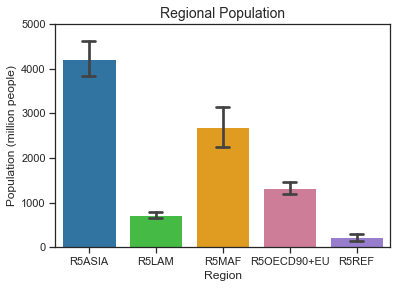

In [17]:
# Making figure of regional population in global net-zero years

popgrid = sns.barplot(x='Region', y='Population in Net-Zero Year', data=more_vars10, ci='sd', capsize=0.2)

plt.subplots_adjust(top=0.9)
plt.ylim(0,5000)
plt.title('Regional Population', fontsize=14)
plt.xlabel('Region')
plt.ylabel('Population (million people)')
plt.savefig('Population_NetZero_EnergyRegion', bbox_inches='tight')
plt.savefig('Population_NetZero_EnergyRegion.pdf', bbox_inches='tight')
plt.savefig('Population_NetZero_EnergyRegion.eps', format='eps', bbox_inches='tight')
plt.show()
   

In [18]:
# getting aggregate statistics for regions:

print('\n')
print('Net positive vs. Net negative regions, net emissions fig. 2d')
print('Percent net-negative scenarios, Asia: '+ str((((groupASIA['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'] < groupASIA['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year']).sum())/(len(groupASIA))) * 100) + ' %')
print('Percent net-negative scenarios, Latin America: '+ str((((groupLAM['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'] < groupLAM['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year']).sum())/(len(groupLAM))) * 100) + ' %')
print('Percent net-negative scenarios, Mideast+Africa: '+ str((((groupMAF['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'] < groupMAF['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year']).sum())/(len(groupMAF))) * 100) + ' %')
print('Percent net-negative scenarios, OECD+EU: '+ str((((groupOECDEU['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'] < groupOECDEU['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year']).sum())/(len(groupOECDEU))) * 100) + ' %')
print('Percent net-negative scenarios, E.Europe+Russia: '+ str((((groupREF['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'] < groupREF['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year']).sum())/(len(groupREF))) * 100) + ' %')
print('\n')
print('Regional GDP per capita')
print('Median GDP per capita, Asia: '+ str(groupASIA['Per Capita GDP in Net-Zero Year'].median()))
print('Median GDP per capita, Latin America: '+ str(groupLAM['Per Capita GDP in Net-Zero Year'].median()))
print('Median GDP per capita, Mideast+Africa: '+ str(groupMAF['Per Capita GDP in Net-Zero Year'].median()))
print('Min GDP per capita, Mideast+Africa: '+ str(groupMAF['Per Capita GDP in Net-Zero Year'].min()))
print('Max GDP per capita, Mideast+Africa: '+ str(groupMAF['Per Capita GDP in Net-Zero Year'].max()))
print('Median GDP per capita, OECD+EU: '+ str(groupOECDEU['Per Capita GDP in Net-Zero Year'].median()))
print('Min GDP per capita, OECD+EU: '+ str(groupOECDEU['Per Capita GDP in Net-Zero Year'].min()))
print('Max GDP per capita, OECD+EU: '+ str(groupOECDEU['Per Capita GDP in Net-Zero Year'].max()))
print('Median GDP per capita, E.Europe+Russia: '+ str(groupREF['Per Capita GDP in Net-Zero Year'].median()))
print('\n')
print('Regional final energy per capita (GJ/person), Net-Zero Year')
print('Median final energy per capita, Asia: '+ str(groupASIA['Final Energy Per Person'].median()))
print('Median final energy per capita, Latin America: '+ str(groupLAM['Final Energy Per Person'].median()))
print('Median final energy per capita, Mideast+Africa: '+ str(groupMAF['Final Energy Per Person'].median()))
print('Median final energy per capita, OECD+EU: '+ str(groupOECDEU['Final Energy Per Person'].median()))
print('Median final energy per capita, E.Europe+Russia: '+ str(groupREF['Final Energy Per Person'].median()))
print('\n')
print('Regional final energy per capita (GJ/person), 2010')
print('Median final energy per capita, Asia: '+ str(groupASIA['Final Energy Per Person in 2010'].median()))
print('Median final energy per capita, Latin America: '+ str(groupLAM['Final Energy Per Person in 2010'].median()))
print('Median final energy per capita, Mideast+Africa: '+ str(groupMAF['Final Energy Per Person in 2010'].median()))
print('Median final energy per capita, OECD+EU: '+ str(groupOECDEU['Final Energy Per Person in 2010'].median()))
print('Median final energy per capita, E.Europe+Russia: '+ str(groupREF['Final Energy Per Person in 2010'].median()))
print('\n')
print('Regional final energy (EJ), Net-Zero Year')
print('Median final energy, Asia: '+ str(groupASIA['Final Energy in Net-Zero Year'].median()))
print('Median final energy, Latin America: '+ str(groupLAM['Final Energy in Net-Zero Year'].median()))
print('Median final energy, Mideast+Africa: '+ str(groupMAF['Final Energy in Net-Zero Year'].median()))
print('Median final energy, OECD+EU: '+ str(groupOECDEU['Final Energy in Net-Zero Year'].median()))
print('Median final energy, E.Europe+Russia: '+ str(groupREF['Final Energy in Net-Zero Year'].median()))
print('\n')
print('Regional final energy (EJ), 2010')
print('Median final energy, Asia: '+ str(groupASIA['Final Energy in 2010'].median()))
print('Median final energy, Latin America: '+ str(groupLAM['Final Energy in 2010'].median()))
print('Median final energy, Mideast+Africa: '+ str(groupMAF['Final Energy in 2010'].median()))
print('Median final energy, OECD+EU: '+ str(groupOECDEU['Final Energy in 2010'].median()))
print('Median final energy, E.Europe+Russia: '+ str(groupREF['Final Energy in 2010'].median()))
print('\n')
print('Primary energy from renewables')
print('Median % primary energy from renewables, Asia: '+ str(groupASIA['Percent of Primary Energy from Renewables'].median()))
print('Median % primary energy from renewables, Latin America: '+ str(groupLAM['Percent of Primary Energy from Renewables'].median()))
print('Min % primary energy from renewables, Latin America: '+ str(groupLAM['Percent of Primary Energy from Renewables'].min()))
print('Max % primary energy from renewables, Latin America: '+ str(groupLAM['Percent of Primary Energy from Renewables'].max()))
print('Median % primary energy from renewables, Mideast+Africa: '+ str(groupMAF['Percent of Primary Energy from Renewables'].median()))
print('Median % primary energy from renewables, OECD+EU: '+ str(groupOECDEU['Percent of Primary Energy from Renewables'].median()))
print('Median % primary energy from renewables, E.Europe+Russia: '+ str(groupREF['Percent of Primary Energy from Renewables'].median()))
print('\n')
print('Renewable energy from biomass')
print('Median % biomass renewable energy, Asia: '+ str(groupASIA['Percent of Renewable Energy from Biomass'].median()))
print('Median % biomass renewable energy, Latin America: '+ str(groupLAM['Percent of Renewable Energy from Biomass'].median()))
print('Min % biomass renewable energy, Latin America: '+ str(groupLAM['Percent of Renewable Energy from Biomass'].min()))
print('Max % biomass renewable energy, Latin America: '+ str(groupLAM['Percent of Renewable Energy from Biomass'].max()))
print('Median % biomass renewable energy, Mideast+Africa: '+ str(groupMAF['Percent of Renewable Energy from Biomass'].median()))
print('Median % biomass renewable energy, OECD+EU: '+ str(groupOECDEU['Percent of Renewable Energy from Biomass'].median()))
print('Median % biomass renewable energy, E.Europe+Russia: '+ str(groupREF['Percent of Renewable Energy from Biomass'].median()))
print('\n')
print('Renewable energy from non-biomass renewables')
print('Median % non-biomass renewable energy, Asia: '+ str(groupASIA['Percent of Renewable Energy from Non-Biomass Renewables'].median()))
print('Median % non-biomass renewable energy, Latin America: '+ str(groupLAM['Percent of Renewable Energy from Non-Biomass Renewables'].median()))
print('Min % non-biomass renewable energy, Latin America: '+ str(groupLAM['Percent of Renewable Energy from Non-Biomass Renewables'].min()))
print('Max % non-biomass renewable energy, Latin America: '+ str(groupLAM['Percent of Renewable Energy from Non-Biomass Renewables'].max()))
print('Median % non-biomass renewable energy, Mideast+Africa: '+ str(groupMAF['Percent of Renewable Energy from Non-Biomass Renewables'].median()))
print('Median % non-biomass renewable energy, OECD+EU: '+ str(groupOECDEU['Percent of Renewable Energy from Non-Biomass Renewables'].median()))
print('Median % non-biomass renewable energy, E.Europe+Russia: '+ str(groupREF['Percent of Renewable Energy from Non-Biomass Renewables'].median()))
print('\n')
print('Electrification')
print('Median % electrification, Asia: '+ str(groupASIA['Percent Final Energy as Electricity'].median()))
print('Median % electrification, Latin America: '+ str(groupLAM['Percent Final Energy as Electricity'].median()))
print('Median % electrification, Mideast+Africa: '+ str(groupMAF['Percent Final Energy as Electricity'].median()))
print('Median % electrification, OECD+EU: '+ str(groupOECDEU['Percent Final Energy as Electricity'].median()))
print('Median % electrification, E.Europe+Russia: '+ str(groupREF['Percent Final Energy as Electricity'].median()))
print('\n')
print('Residual emissions per capita')
print('Median residual energy+industry emissions per capita, Asia: '+ str(groupASIA['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
print('Median residual energy+industry emissions per capita, Latin America: '+ str(groupLAM['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
print('Median residual energy+industry emissions per capita, Mideast+Africa: '+ str(groupMAF['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
print('Median residual energy+industry emissions per capita, OECD+EU: '+ str(groupOECDEU['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
print('Min residual energy+industry emissions per capita, OECD+EU: '+ str(groupOECDEU['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].min()))
print('Max residual energy+industry emissions per capita, OECD+EU: '+ str(groupOECDEU['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].max()))
print('Median residual energy+industry emissions per capita, E.Europe+Russia: '+ str(groupREF['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
print('Min residual energy+industry emissions per capita, E.Europe+Russia: '+ str(groupREF['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].min()))
print('Max residual energy+industry emissions per capita, E.Europe+Russia: '+ str(groupREF['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].max()))
print('\n')
print('AVG Residual emissions TOTAL')
print('Mean residual energy+industry emissions, Asia: '+ str(groupASIA['Residual Emissions|Energy and Industrial Processes in Net-Zero Year'].mean()))
print('Median residual energy+industry emissions, Asia: '+ str(groupASIA['Residual Emissions|Energy and Industrial Processes in Net-Zero Year'].median()))
print('Min residual energy+industry emissions, Asia: '+ str(groupASIA['Residual Emissions|Energy and Industrial Processes in Net-Zero Year'].min()))
print('Max residual energy+industry emissions, Asia: '+ str(groupASIA['Residual Emissions|Energy and Industrial Processes in Net-Zero Year'].max()))
print('Mean residual energy+industry emissions, Latin America: '+ str(groupLAM['Residual Emissions|Energy and Industrial Processes in Net-Zero Year'].mean()))
print('Mean residual energy+industry emissions, Mideast+Africa: '+ str(groupMAF['Residual Emissions|Energy and Industrial Processes in Net-Zero Year'].mean()))
print('Mean residual energy+industry emissions, OECD+EU: '+ str(groupOECDEU['Residual Emissions|Energy and Industrial Processes in Net-Zero Year'].mean()))
print('Mean residual energy+industry emissions, E.Europe+Russia: '+ str(groupREF['Residual Emissions|Energy and Industrial Processes in Net-Zero Year'].mean()))
print('\n')
print('BECCS per capita')
print('Median BECCS per capita, Asia: '+ str(groupASIA['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
print('Median BECCS per capita, Latin America: '+ str(groupLAM['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
print('Median BECCS per capita, Mideast+Africa: '+ str(groupMAF['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
print('Median BECCS per capita, OECD+EU: '+ str(groupOECDEU['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
print('Median BECCS per capita, E.Europe+Russia: '+ str(groupREF['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
print('\n')
print('AVG BECCS TOTAL')
print('Mean BECCS, Asia: '+ str(groupASIA['Carbon Sequestration|CCS|Biomass in Net-Zero Year'].mean()))
print('Median BECCS, Asia: '+ str(groupASIA['Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
print('Min BECCS, Asia: '+ str(groupASIA['Carbon Sequestration|CCS|Biomass in Net-Zero Year'].min()))
print('Max BECCS, Asia: '+ str(groupASIA['Carbon Sequestration|CCS|Biomass in Net-Zero Year'].max()))
print('Mean BECCS, Latin America: '+ str(groupLAM['Carbon Sequestration|CCS|Biomass in Net-Zero Year'].mean()))
print('Mean BECCS, Mideast+Africa: '+ str(groupMAF['Carbon Sequestration|CCS|Biomass in Net-Zero Year'].mean()))
print('Mean BECCS, OECD+EU: '+ str(groupOECDEU['Carbon Sequestration|CCS|Biomass in Net-Zero Year'].mean()))
print('Median BECCS, OECD+EU: '+ str(groupOECDEU['Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
print('Min BECCS, OECD+EU: '+ str(groupOECDEU['Carbon Sequestration|CCS|Biomass in Net-Zero Year'].min()))
print('Max BECCS, OECD+EU: '+ str(groupOECDEU['Carbon Sequestration|CCS|Biomass in Net-Zero Year'].max()))
print('Mean BECCS, E.Europe+Russia: '+ str(groupREF['Carbon Sequestration|CCS|Biomass in Net-Zero Year'].mean()))
print('\n')
print('AVG Land Use Ems TOTAL')
print('Mean Land Use Ems, Asia: '+ str(groupASIA['Emissions|CO2|AFOLU in Net-Zero Year'].mean()))
print('Mean Land Use Ems, Latin America: '+ str(groupLAM['Emissions|CO2|AFOLU in Net-Zero Year'].mean()))
print('Median Land Use Ems, Latin America: '+ str(groupLAM['Emissions|CO2|AFOLU in Net-Zero Year'].median()))
print('Min Land Use Ems, Latin America: '+ str(groupLAM['Emissions|CO2|AFOLU in Net-Zero Year'].min()))
print('Max Land Use Ems, Latin America: '+ str(groupLAM['Emissions|CO2|AFOLU in Net-Zero Year'].max()))
print('Mean Land Use Ems, Mideast+Africa: '+ str(groupMAF['Emissions|CO2|AFOLU in Net-Zero Year'].mean()))
print('Mean Land Use Ems, OECD+EU: '+ str(groupOECDEU['Emissions|CO2|AFOLU in Net-Zero Year'].mean()))
print('Mean Land Use Ems, E.Europe+Russia: '+ str(groupREF['Emissions|CO2|AFOLU in Net-Zero Year'].mean()))
print('\n')

if inv==1:
    print('Per Capita Investment in non-fossil electricity (cumulative thru net-zero year)')
    print('Median non-fossil electricity investment, Asia: '+ str((groupASIA_inv['Per Capita Cumulative Investment|Energy Supply|Electricity|Non-fossil up to Net-Zero Year'].median())) + ' ($Billion)')
    print('Median non-fossil electricity investment, Latin America: '+ str((groupLAM_inv['Per Capita Cumulative Investment|Energy Supply|Electricity|Non-fossil up to Net-Zero Year'].median())) + ' ($Billion)')
    print('Median non-fossil electricity investment, Mideast+Africa: '+ str((groupMAF_inv['Per Capita Cumulative Investment|Energy Supply|Electricity|Non-fossil up to Net-Zero Year'].median())) + ' ($Billion)')
    print('Median non-fossil electricity investment, OECD+EU: '+ str((groupOECDEU_inv['Per Capita Cumulative Investment|Energy Supply|Electricity|Non-fossil up to Net-Zero Year'].median())) + ' ($Billion)')
    print('Median non-fossil electricity investment, E.Europe+Russia: '+ str((groupREF_inv['Per Capita Cumulative Investment|Energy Supply|Electricity|Non-fossil up to Net-Zero Year'].median())) + ' ($Billion)')
    print('\n')
    print('Per Capita BECCS, investment scenarios')
    print('Median BECCS, Asia: '+ str(groupASIA_inv['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
    print('Median BECCS, Latin America: '+ str(groupLAM_inv['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
    print('Median BECCS, Mideast+Africa: '+ str(groupMAF_inv['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
    print('Median BECCS, OECD+EU: '+ str(groupOECDEU_inv['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
    print('Median BECCS, E.Europe+Russia: '+ str(groupREF_inv['Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year'].median()))
    print('\n')
    print('Per Capita Residual emissions, investment scenarios')
    print('Median residual energy+industry emissions, Asia: '+ str(groupASIA_inv['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
    print('Median residual energy+industry emissions, Latin America: '+ str(groupLAM_inv['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
    print('Median residual energy+industry emissions, Mideast+Africa: '+ str(groupMAF_inv['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
    print('Median residual energy+industry emissions, OECD+EU: '+ str(groupOECDEU_inv['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
    print('Median residual energy+industry emissions, E.Europe+Russia: '+ str(groupREF_inv['Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year'].median()))
    print('\n')
    print('Electrification, investment scenarios')
    print('Median % electrification, Asia: '+ str(groupASIA_inv['Percent Final Energy as Electricity'].median()))
    print('Median % electrification, Latin America: '+ str(groupLAM_inv['Percent Final Energy as Electricity'].median()))
    print('Median % electrification, Mideast+Africa: '+ str(groupMAF_inv['Percent Final Energy as Electricity'].median()))
    print('Median % electrification, OECD+EU: '+ str(groupOECDEU_inv['Percent Final Energy as Electricity'].median()))
    print('Median % electrification, E.Europe+Russia: '+ str(groupREF_inv['Percent Final Energy as Electricity'].median()))
    print('\n')



Net positive vs. Net negative regions, net emissions fig. 2d
Percent net-negative scenarios, Asia: 19.375 %
Percent net-negative scenarios, Latin America: 78.125 %
Percent net-negative scenarios, Mideast+Africa: 13.953488372093023 %
Percent net-negative scenarios, OECD+EU: 49.375 %
Percent net-negative scenarios, E.Europe+Russia: 40.116279069767444 %


Regional GDP per capita
Median GDP per capita, Asia: 34.50456336832956
Median GDP per capita, Latin America: 37.35523911565845
Median GDP per capita, Mideast+Africa: 18.959762397500068
Min GDP per capita, Mideast+Africa: 6.262978928579029
Max GDP per capita, Mideast+Africa: 97.7205448829396
Median GDP per capita, OECD+EU: 67.94357035083767
Min GDP per capita, OECD+EU: 47.53377732549053
Max GDP per capita, OECD+EU: 146.34074068054065
Median GDP per capita, E.Europe+Russia: 46.93804064736128


Regional final energy per capita (GJ/person), Net-Zero Year
Median final energy per capita, Asia: 49.991007080751835
Median final energy per capit

In [19]:
# REGIONAL making sorted tables of scenario variable correlations including investment

from pandas.plotting import table 
from scipy import stats
from scipy.stats import zscore
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors

# 'Cumulative Investment|Energy Supply|Electricity|Non-fossil up to Net-Zero Year'
if i==1:
    table_vars1 = investment_vars[['Scenario', 'Model', 'Warming', 'Net-Zero Year', 'Final Energy Per Person', 'Percent Final Energy as Electricity', \
                             'Percent of Primary Energy from Renewables', \
                             'Percent of Renewable Energy from Non-Biomass Renewables', \
                             'Emissions|CO2|AFOLU in Net-Zero Year', \
                             'Per Capita Cumulative Investment|Energy Supply|Electricity|Non-fossil up to Net-Zero Year', \
                             'Carbon Sequestration|CCS|Biomass in Net-Zero Year', \
                             'Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year', \
                             'Residual Emissions|Energy and Industrial Processes in Net-Zero Year', \
                             'Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year']]
    table_vars1['Scenario-Model'] = table_vars1['Scenario'].str.cat(table_vars1['Model'],sep=", ")
    # print(table_vars1['Scenario-Model'])

    table = table_vars1[['Scenario-Model', 'Warming', 'Net-Zero Year', 'Final Energy Per Person', 'Percent Final Energy as Electricity', \
                             'Percent of Primary Energy from Renewables', \
                             'Percent of Renewable Energy from Non-Biomass Renewables', \
                             'Emissions|CO2|AFOLU in Net-Zero Year', \
                             'Per Capita Cumulative Investment|Energy Supply|Electricity|Non-fossil up to Net-Zero Year', \
                             'Carbon Sequestration|CCS|Biomass in Net-Zero Year', \
                             'Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year', \
                             'Residual Emissions|Energy and Industrial Processes in Net-Zero Year', \
                             'Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year']]

    tableplot2 = table

    def warmingnum(row):
        if row['Warming'] == '1.5C':
            return 1.5
        if row['Warming'] == '2C':
            return 2.0
        if row['Warming'] == '>2C':
            return 2.5

    tableplot2['Warming Amount'] = tableplot2.apply(lambda row: warmingnum(row), axis = 1)
    # print(tableplot2)


    from scipy import stats

    tablevars = ['Per Capita Cumulative Investment|Energy Supply|Electricity|Non-fossil up to Net-Zero Year', \
                             'Percent Final Energy as Electricity', \
                             'Carbon Sequestration|CCS|Biomass in Net-Zero Year', \
                             'Per Capita Carbon Sequestration|CCS|Biomass in Net-Zero Year', \
                             'Residual Emissions|Energy and Industrial Processes in Net-Zero Year', \
                             'Per Capita Residual Emissions|CO2|Energy and Industrial Processes in Net-Zero Year', \
                             'Percent of Primary Energy from Renewables', 'Percent of Renewable Energy from Non-Biomass Renewables', \
                             'Final Energy Per Person']
    corr_df = pd.DataFrame(columns=['r', 'p'])

    for i in range(len(tablevars)):
        for col in tableplot2:
            if pd.api.types.is_numeric_dtype(tableplot2[col]):
                r, p = stats.pearsonr(tableplot2[tablevars[i]], tableplot2[col])
                corr_df.loc[col] = [round(r,3), p]
        print(corr_df)


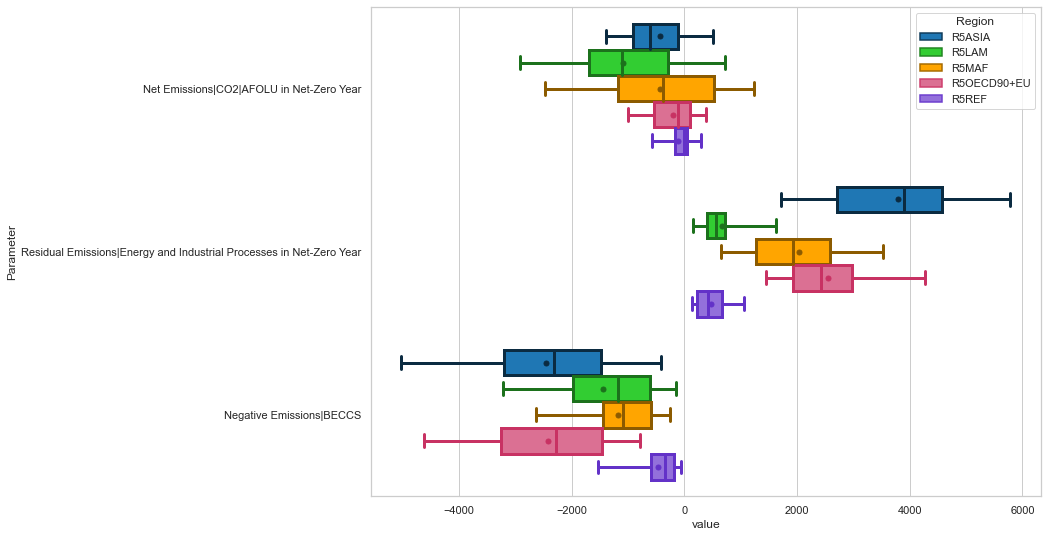

In [20]:
# boxplot for regional residual/negative  emissions

import matplotlib.patches as mpatches
import matplotlib.colors as mc
import colorsys

regions = np.array(['R5ASIA', 'R5LAM', 'R5MAF', 'R5OECD90+EU', 'R5REF'], dtype=object)

x = range(len(full_co2_data))

more_vars27 = pd.DataFrame()
more_vars28 = pd.DataFrame()
more_vars29 = pd.DataFrame()
more_vars30 = pd.DataFrame()
more_vars31 = pd.DataFrame()
more_vars32 = pd.DataFrame()
more_vars33 = pd.DataFrame()
more_vars34 = pd.DataFrame()
more_vars35 = pd.DataFrame()
more_vars36 = pd.DataFrame()
more_vars37 = pd.DataFrame()
more_vars38 = pd.DataFrame()
more_vars45 = pd.DataFrame()
more_vars46 = pd.DataFrame()
more_vars47 = pd.DataFrame()
more_vars48 = pd.DataFrame()
more_vars49 = pd.DataFrame()
more_vars50 = pd.DataFrame()


more_vars27['R5ASIA'] \
    = more_vars10.groupby('Region').get_group('R5ASIA')['Carbon Sequestration|CCS|Biomass in Net-Zero Year'] * -1
more_vars28['R5LAM'] \
    = more_vars10.groupby('Region').get_group('R5LAM')['Carbon Sequestration|CCS|Biomass in Net-Zero Year'] * -1
more_vars29['R5MAF'] \
    = more_vars10.groupby('Region').get_group('R5MAF')['Carbon Sequestration|CCS|Biomass in Net-Zero Year'] * -1
more_vars30['R5OECD90+EU'] \
    = more_vars10.groupby('Region').get_group('R5OECD90+EU')['Carbon Sequestration|CCS|Biomass in Net-Zero Year'] * -1
more_vars31['R5REF'] \
    = more_vars10.groupby('Region').get_group('R5REF')['Carbon Sequestration|CCS|Biomass in Net-Zero Year'] * -1
more_vars32 = pd.concat([more_vars27, more_vars28, more_vars29, more_vars30, more_vars31])
more_vars32['Parameter'] = 'Negative Emissions|BECCS'


more_vars33['R5ASIA'] \
    = more_vars10.groupby('Region').get_group('R5ASIA')['Residual Emissions|Energy and Industrial Processes in Net-Zero Year']
more_vars34['R5LAM'] \
    = more_vars10.groupby('Region').get_group('R5LAM')['Residual Emissions|Energy and Industrial Processes in Net-Zero Year']
more_vars35['R5MAF'] \
    = more_vars10.groupby('Region').get_group('R5MAF')['Residual Emissions|Energy and Industrial Processes in Net-Zero Year']
more_vars36['R5OECD90+EU'] \
    = more_vars10.groupby('Region').get_group('R5OECD90+EU')['Residual Emissions|Energy and Industrial Processes in Net-Zero Year']
more_vars37['R5REF'] \
    = more_vars10.groupby('Region').get_group('R5REF')['Residual Emissions|Energy and Industrial Processes in Net-Zero Year']
more_vars38 = pd.concat([more_vars33, more_vars34, more_vars35, more_vars36, more_vars37])
more_vars38['Parameter'] = 'Residual Emissions|Energy and Industrial Processes in Net-Zero Year'


more_vars45['R5ASIA'] \
    = more_vars10.groupby('Region').get_group('R5ASIA')['Emissions|CO2|AFOLU in Net-Zero Year']
more_vars46['R5LAM'] \
    = more_vars10.groupby('Region').get_group('R5LAM')['Emissions|CO2|AFOLU in Net-Zero Year']
more_vars47['R5MAF'] \
    = more_vars10.groupby('Region').get_group('R5MAF')['Emissions|CO2|AFOLU in Net-Zero Year']
more_vars48['R5OECD90+EU'] \
    = more_vars10.groupby('Region').get_group('R5OECD90+EU')['Emissions|CO2|AFOLU in Net-Zero Year']
more_vars49['R5REF'] \
    = more_vars10.groupby('Region').get_group('R5REF')['Emissions|CO2|AFOLU in Net-Zero Year']
more_vars50 = pd.concat([more_vars45, more_vars46, more_vars47, more_vars48, more_vars49])
more_vars50['Parameter'] = 'Net Emissions|CO2|AFOLU in Net-Zero Year'


# Plotting:

cdf = pd.concat([more_vars50, more_vars38, more_vars32])    
mdf = pd.melt(cdf, id_vars=['Parameter'], var_name=['Region'])

boxprops = dict(linestyle='-')
flierprops = dict(marker='o', markerfacecolor='black', markersize=5,
                  linestyle='none')
medianprops = dict(linestyle='-', linewidth=3, color='black')
meanpointprops = dict(marker='o', markeredgecolor='black',
                      markerfacecolor='orchid', markersize=5)
meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
sns.set(style="whitegrid")
sns.set_palette(sns.color_palette(temp_colors))
fig, ax = plt.subplots(figsize = (12,9))
ax.yaxis.grid(False)
ax.xaxis.grid(True)
sns.boxplot(x='value', y="Parameter", hue='Region', data=mdf, whis=[5,95], linewidth=3, notch=False, \
                 medianprops=medianprops, flierprops=flierprops, meanprops=meanpointprops, \
                 meanline=False, showmeans=True, showfliers = False, saturation=1, ax=ax)

# Lighten color function from StackOverflow:

def lighten_color(color, amount=0.5):  
    # --------------------- SOURCE: @IanHincks ---------------------
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# --------------------- SOURCE: @tmdavison --------------------- 
for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    # col = artist.get_facecolor()
    col = lighten_color(artist.get_facecolor(), 1.45)
    artist.set_edgecolor(col)
    # artist.set_facecolor('None')

    # Each box has 7 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

# Also fix the legend

for legpatch in ax.get_legend().get_patches(): 
    # col = legpatch.get_facecolor()
    col = lighten_color(legpatch.get_facecolor(), 1.35) 
    legpatch.set_edgecolor(col) 
    
    # legpatch.set_facecolor('None')
# ax = sns.swarmplot(x="value", y="Parameter", hue="Warming", data=mdf, color=".25")

# End of StackOverflow section


residual1 = mpatches.Patch(color='xkcd:tomato', label='Residual Emissions|Energy and Industrial Processes')
residual2 = mpatches.Patch(color='orange', label='Residual Emissions|AFOLU')
offset1 = mpatches.Patch(color='royalblue', label='Negative Emissions|BECCS')
offset2 = mpatches.Patch(color='skyblue', label='Negative Emissions|AFOLU')
# plt.legend(handles=[offset1,offset2,residual1,residual2], bbox_to_anchor=(0.5, -0.2), loc='center', ncol=2)

# x_pos = np.arange(20)
# ax.set_xticks(x_pos + 1000)
# ax.set_xlabel('Million people')
# ax.set_title('Regional Populations in Net-Zero Year')
# plt.vlines(x=0,ymin=3,ymax=7, linewidths=0.75)
# ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# plt.savefig('Residual_boxplot_reg3', bbox_inches='tight')
# plt.savefig('Residual_boxplot_reg3.pdf', bbox_inches='tight')
# plt.savefig('Residual_boxplot_reg3.eps', format='eps', bbox_inches='tight')


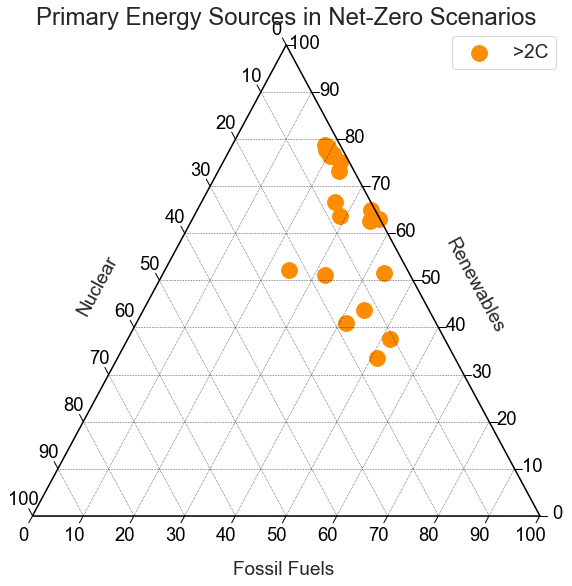

[29.32204097 64.61285889  6.06526505]


In [24]:
# for making global scenario ternary plots
import ternary
from cycler import cycler # for mpl>2.2

# IF regional scatterplot cell was most recently run, uncomment line below to switch more_vars10 back to global data:
# more_vars10 = more_vars51

ternary_var = np.array(['Primary Energy', 'Primary Energy|Fossil', 'Primary Energy|Nuclear', 'Primary Energy|Biomass', 'Primary Energy|Non-Biomass Renewables', 'Primary Energy|Solar', 'Primary Energy|Wind', 'Primary Energy|Hydro'])
scale = 100
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(10, 10)
tax.boundary(linewidth=1.5)
# tax.gridlines(color="black", multiple=2, alpha=0.25)
tax.gridlines(color="black", multiple=10, linewidth=0.6)
fontsize = 18
tax.set_title("Unknown Title\n", fontsize=fontsize)
tax.left_axis_label("Nuclear", fontsize=fontsize+1, offset=0.13)
tax.right_axis_label("Renewables", fontsize=fontsize+1, offset=0.13)
tax.bottom_axis_label("Fossil Fuels", fontsize=fontsize+1, offset=0.02)

tax.ticks(axis='lbr', fontsize=fontsize+0.5, linewidth=1, multiple=10, offset=0.015)
#tax.clear_matplotlib_ticks()
warming = np.array(['1.5C', '2C', '>2C'], dtype = 'object')
tax.set_title('Final Energy Sources', fontsize=fontsize+2)

# Replace warming group in warming_group line below with selected warming group ('1.5C', '2C', or '>2C')
points = []
# for i in range(len(pltscenarios)):
warming_group = more_vars51.groupby('Region').get_group('World').groupby('Warming').get_group('>2C')
liquid_ratio = warming_group['Percent of Non-Electric Final Energy from Liquids']
solid_ratio = warming_group['Percent of Non-Electric Final Energy from Solids+other']
gas_ratio = warming_group['Percent of Non-Electric Final Energy from Gases']
fossil_ratio = warming_group['Primary Energy|Fossil in Net-Zero Year'] / warming_group['Primary Energy in Net-Zero Year'] * scale
nuclear_ratio = warming_group['Primary Energy|Nuclear in Net-Zero Year'] / warming_group['Primary Energy in Net-Zero Year'] * scale
non_renewable_ratio = (warming_group['Primary Energy|Fossil in Net-Zero Year'] + warming_group['Primary Energy|Nuclear in Net-Zero Year']) / warming_group['Primary Energy in Net-Zero Year'] * scale
renewable_ratio = warming_group['Primary Energy|Renewables in Net-Zero Year'] / warming_group['Primary Energy in Net-Zero Year'] * scale
bio_ratio = warming_group['Primary Energy|Biomass in Net-Zero Year'] / warming_group['Primary Energy in Net-Zero Year'] * scale
non_bio_ratio = warming_group['Primary Energy|Non-Biomass Renewables in Net-Zero Year'] / warming_group['Primary Energy in Net-Zero Year'] * scale
# points.append((liquid_ratio, solid_ratio, gas_ratio)) # For final energy plot
points.append((fossil_ratio, renewable_ratio, nuclear_ratio)) # For primary energy plot


# Points2 and Points3 variables are for geometric median calculations. 
# Need to adjust second reshape dimension for warming group (77 for 1.5, 81 for 2.0, 19 for >2.0)
points2 = np.array(points).reshape(3,19)
points3 = np.transpose(points2)
# print(points2)
# print(points3)

n = 250
colors=['tab:blue', 'limegreen', 'darkorange']

# Replace label for relevant warming group
tax.scatter(points, s=n, label = '>2C', marker='o', color = 'darkorange')
tax.get_axes().axis('off')
tax.legend(fontsize=fontsize+1)

tax.set_title('Primary Energy Sources in Net-Zero Scenarios', fontsize=fontsize+6, pad = 1.5)

# tax.savefig('Net-Zero Energy Sources Ternary2plus')
# tax.savefig('Net-Zero Energy Sources Ternary2plus.pdf')
# tax.savefig('Net-Zero Energy Sources Ternary2plus.eps', format='eps')
tax.show()


# the following geometric median code is taken from "geometric_median" by mrwojo on github

from scipy.optimize import minimize
from scipy.spatial.distance import cdist


def geometric_median(points, method='auto', options={}):
    """
    Calculates the geometric median of an array of points.
    method specifies which algorithm to use:
        * 'auto' -- uses a heuristic to pick an algorithm
        * 'minimize' -- scipy.optimize the sum of distances
        * 'weiszfeld' -- Weiszfeld's algorithm
    """

    points = np.asarray(points)

    if len(points.shape) == 1:
        # geometric_median((0, 0)) has too much potential for error.
        # Did the user intend a single 2D point or two scalars?
        # Use np.median if you meant the latter.
        raise ValueError("Expected 2D array")

    if method == 'auto':
        if points.shape[1] > 2:
            # weiszfeld tends to converge faster in higher dimensions
            method = 'weiszfeld'
        else:
            method = 'minimize'

    return _methods[method](points, options)


def minimize_method(points, options={}):
    """
    Geometric median as a convex optimization problem.
    """

    # objective function
    def aggregate_distance(x):
        return cdist([x], points).sum()

    # initial guess: centroid
    centroid = points.mean(axis=0)

    optimize_result = minimize(aggregate_distance, centroid, method='COBYLA')

    return optimize_result.x


def weiszfeld_method(points, options={}):
    """
    Weiszfeld's algorithm as described on Wikipedia.
    """

    default_options = {'maxiter': 1000, 'tol': 1e-7}
    default_options.update(options)
    options = default_options

    def distance_func(x):
        return cdist([x], points)

    # initial guess: centroid
    guess = points.mean(axis=0)

    iters = 0

    while iters < options['maxiter']:
        distances = distance_func(guess).T

        # catch divide by zero
        # TODO: Wikipedia cites how to deal with distance 0
        distances = np.where(distances == 0, 1, distances)

        guess_next = (points/distances).sum(axis=0) / (1./distances).sum(axis=0)

        guess_movement = np.sqrt(((guess - guess_next)**2).sum())

        guess = guess_next

        if guess_movement <= options['tol']:
            break

        iters += 1

    return guess


_methods = {
    'minimize': minimize_method,
    'weiszfeld': weiszfeld_method,
}

# End of GitHub section

# geometric median coordinates print in the order that the points are appended
print(geometric_median(points3, method='minimize'))
